# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
azdias.head()#Demographics data for the general population of Germany

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [5]:
customers.head()#Demographics data for customers of a mail-order company

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0         ...               2.0             6.0             9.0       7.0   
1         ...               3.0             0.0             9.0       NaN   
2         ...              11.0             6.0             9.0       2.0   
3         ...               2.0             NaN             9.0       7.0   
4         ...               4.0             2.0             9.0       3.0   

   ZABEOTYP      PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1         3               FOOD    SINGLE_BUYER               0         1   
2         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3         1           COSMETIC     MULTI_BUYER               0         1   
4         1               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [6]:
print (azdias.shape)
print (customers.shape)

(891221, 366)
(191652, 369)


### Additional columns for customers dataframe

In [7]:
list(set(customers.columns) - set(azdias.columns))

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [8]:
customers[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']].tail()

PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
191647  COSMETIC_AND_FOOD    MULTI_BUYER                0
191648           COSMETIC   SINGLE_BUYER                0
191649  COSMETIC_AND_FOOD    MULTI_BUYER                0
191650               FOOD   SINGLE_BUYER                0
191651  COSMETIC_AND_FOOD    MULTI_BUYER                0

### Converting data to csv file and uploading to S3 aws

In [9]:
#customers.to_csv('customers.csv')
#azdias.to_csv('azdias.csv')

### Cleaning data and preprocessing

In [10]:
# Identifying non values columns
#azdias_subset = azdias.select_dtypes(exclude=[np.float, np.int])
customers_subset = customers.select_dtypes(exclude=[np.float, np.int])

In [11]:
customers_subset.head()

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE  \
0             1A               1              13            D19_UNBEKANNT   
1            NaN             NaN             NaN         D19_BANKEN_GROSS   
2             5D               5              34            D19_UNBEKANNT   
3             4C               4              24   D19_NAHRUNGSERGAENZUNG   
4             7B               7              41               D19_SCHUHE   

         EINGEFUEGT_AM OST_WEST_KZ      PRODUCT_GROUP CUSTOMER_GROUP  
0  1992-02-12 00:00:00           W  COSMETIC_AND_FOOD    MULTI_BUYER  
1                  NaN         NaN               FOOD   SINGLE_BUYER  
2  1992-02-10 00:00:00           W  COSMETIC_AND_FOOD    MULTI_BUYER  
3  1992-02-10 00:00:00           W           COSMETIC    MULTI_BUYER  
4  1992-02-12 00:00:00           W               FOOD    MULTI_BUYER

In [12]:
# Dropping non values columns
#clean_azdias = azdias.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)
clean_customers = customers.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ','EINGEFUEGT_AM', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1)

In [13]:
clean_customers.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
0         2         1.0      10.0          NaN          NaN          NaN   
1        -1         9.0      11.0          NaN          NaN          NaN   
2        -1         1.0       6.0          NaN          NaN          NaN   
3         1         1.0       8.0          NaN          NaN          NaN   
4        -1         1.0      20.0          NaN          NaN          NaN   

   ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0          NaN                  10.0                  1.0           0.0   
1          NaN                   NaN                  NaN           NaN   
2          NaN                   0.0                  1.0           0.0   
3          NaN                   8.0                  0.0           NaN   
4          NaN                  14.0                  7.0           0.0   

           ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0          ...           3.0       5.0         3.0      2.0             6.0   
1          ...           NaN       6.0         6.0      3.0             0.0   
2          ...           4.0      10.0        13.0     11.0             6.0   
3          ...           2.0       6.0         4.0      2.0             NaN   
4          ...           4.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008 WOHNLAGE ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  
0             9.0      7.0        3          1                     4  
1             9.0      NaN        3          1                     4  
2             9.0      2.0        3          2                     4  
3             9.0      7.0        1          1                     4  
4             9.0      3.0        1          1                     3  

[5 rows x 361 columns]

In [14]:
# If possible convert remaining non values data to numeric values otherwise replace with NaN
clean_customers = clean_customers.apply(pd.to_numeric, errors='coerce')
#clean_azdias = clean_azdias.apply(pd.to_numeric, errors='coerce')

At this stage we should only have numercial values and NaN values

In [15]:
clean_customers.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
0         2         1.0      10.0          NaN          NaN          NaN   
1        -1         9.0      11.0          NaN          NaN          NaN   
2        -1         1.0       6.0          NaN          NaN          NaN   
3         1         1.0       8.0          NaN          NaN          NaN   
4        -1         1.0      20.0          NaN          NaN          NaN   

   ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0          NaN                  10.0                  1.0           0.0   
1          NaN                   NaN                  NaN           NaN   
2          NaN                   0.0                  1.0           0.0   
3          NaN                   8.0                  0.0           NaN   
4          NaN                  14.0                  7.0           0.0   

           ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0          ...           3.0       5.0         3.0      2.0             6.0   
1          ...           NaN       6.0         6.0      3.0             0.0   
2          ...           4.0      10.0        13.0     11.0             6.0   
3          ...           2.0       6.0         4.0      2.0             NaN   
4          ...           4.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  
0             9.0       7.0         3          1                     4  
1             9.0       NaN         3          1                     4  
2             9.0       2.0         3          2                     4  
3             9.0       7.0         1          1                     4  
4             9.0       3.0         1          1                     3  

[5 rows x 361 columns]

In [16]:
# Counting NaN values of each columns
clean_customers.apply(lambda x:x.isna().sum())
#clean_azdias.apply(lambda x:x.isna().sum())

AGER_TYP                           0
AKT_DAT_KL                     46596
ALTER_HH                       46596
ALTER_KIND1                   179886
ALTER_KIND2                   186552
ALTER_KIND3                   190377
ALTER_KIND4                   191416
ALTERSKATEGORIE_FEIN           51842
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   52110
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
ANZ_STATISTISCHE_HAUSHALTE     49927
ANZ_TITEL                      46596
ARBEIT                         50476
BALLRAUM                       49959
CAMEO_DEUG_2015                50554
CAMEO_INTL_2015                50554
CJT_GESAMTTYP                   3213
CJT_KATALOGNUTZER               3213
CJT_TYP_1                       3213
CJT_TYP_2                       3213
CJT_TYP_3                       3213
CJT_TYP_4                       3213
CJT_TYP_5                       3213
CJT_TYP_6                       3213
D19_BANKEN_ANZ_12                  0
D

In [17]:
# # Unifying data type to float64
# clean_customers = clean_customers.astype('float64')
# clean_azdias = clean_azdias.astype('float64')

In [18]:
# Check for datatype value
for i in list(clean_customers.dtypes):
    if i != 'float64' and i != 'int64':
        print (i)
    else:
        continue

In [ ]:
clean_customers.shape

In [ ]:
# Droping columns with too many NaN values
clean_customers = clean_customers.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4'], axis=1)
#clean_azdias = clean_azdias.drop(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3', 'ALTER_KIND4'], axis=1)

In [ ]:
clean_customers.head()

In [ ]:
# #Drop NaN value from axis 0
# clean_customers_dropna = clean_customers.dropna(axis = 0)
# clean_azdias = clean_azdias.dropna(axis = 0)

In [ ]:
clean_customers_fillna = clean_customers.fillna(clean_customers.median())


In [44]:
clean_customers_fillna.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0         2         1.0      10.0                  10.0                  1.0   
1        -1         9.0      11.0                  10.0                  1.0   
2        -1         1.0       6.0                   0.0                  1.0   
3         1         1.0       8.0                   8.0                  0.0   
4        -1         1.0      20.0                  14.0                  7.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         1.0   
1           0.0         0.0           3.0                         1.0   
2           0.0         0.0           1.0                         1.0   
3           0.0         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         7.0   

   ANZ_TITEL          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  \
0        0.0          ...           3.0       5.0         3.0      2.0   
1        0.0          ...           2.0       6.0         6.0      3.0   
2        0.0          ...           4.0      10.0        13.0     11.0   
3        0.0          ...           2.0       6.0         4.0      2.0   
4        0.0          ...           4.0       3.0         5.0      4.0   

   W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  \
0             6.0             9.0       7.0         3          1   
1             0.0             9.0       3.0         3          1   
2             6.0             9.0       2.0         3          2   
3             5.0             9.0       7.0         1          1   
4             2.0             9.0       3.0         1          1   

   ALTERSKATEGORIE_GROB  
0                     4  
1                     4  
2                     4  
3                     4  
4                     3  

[5 rows x 357 columns]

### Checking data type and cleaned values

In [71]:
clean_customers_fillna.apply(lambda x:x.isna().sum())


AGER_TYP                      0
AKT_DAT_KL                    0
ALTER_HH                      0
ALTERSKATEGORIE_FEIN          0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CAMEO_DEUG_2015               0
CAMEO_INTL_2015               0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_ANZ_12             0
D19_BANKEN_ANZ_24             0
D19_BANKEN_DATUM              0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_OFFLINE_DATUM      0
D19_BANKEN_ONLINE_DATUM       0
                             ..
SEMIO_KR

In [73]:
set(clean_customers_fillna.dtypes)

{dtype('int64'), dtype('float64')}

### Visuzalization

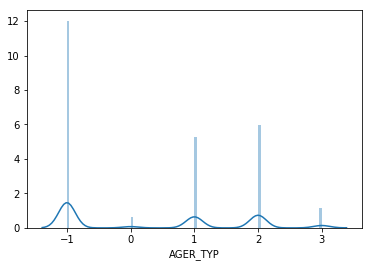

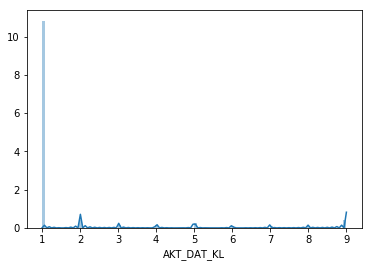

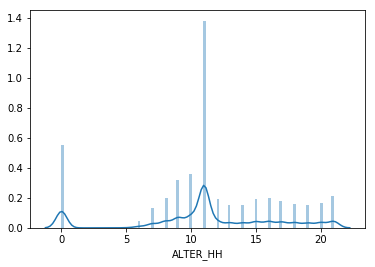

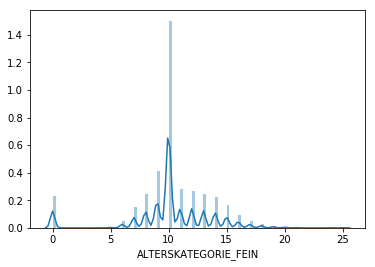

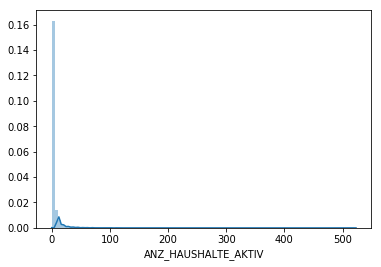

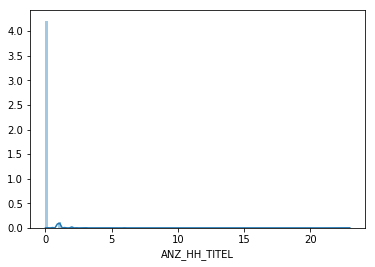

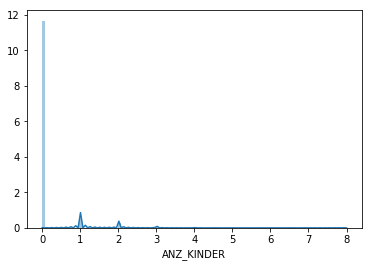

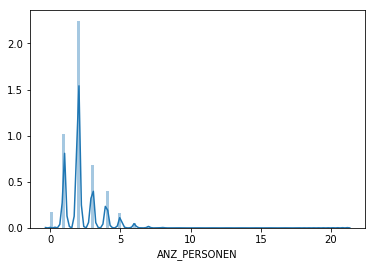

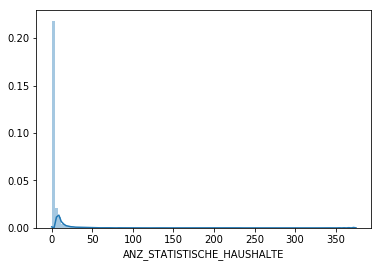

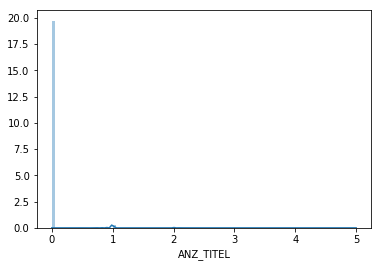

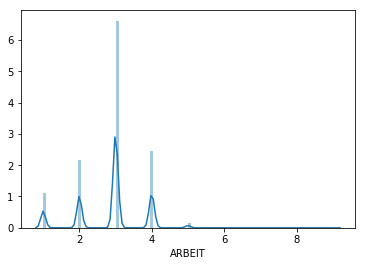

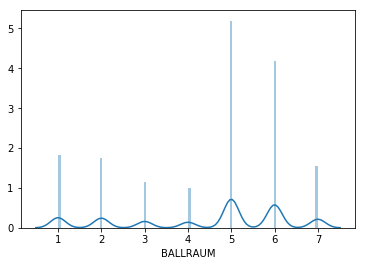

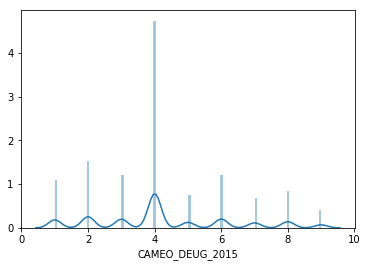

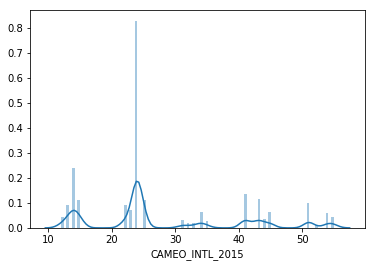

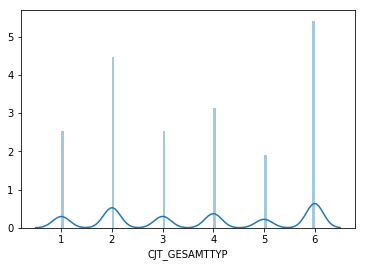

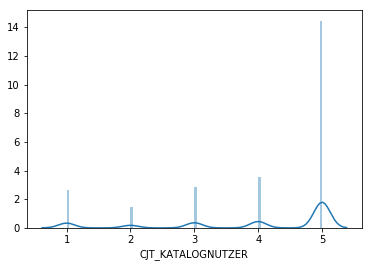

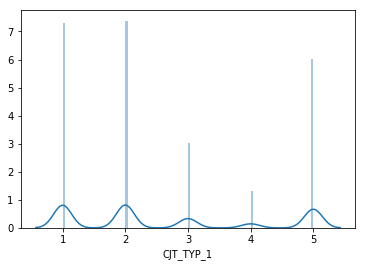

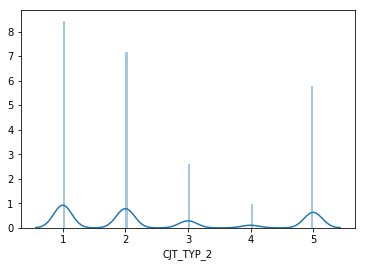

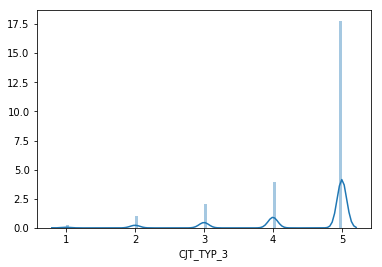

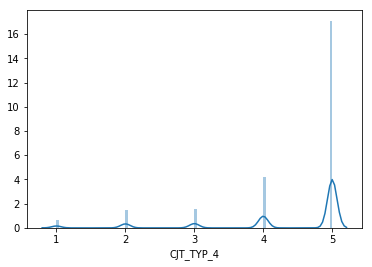

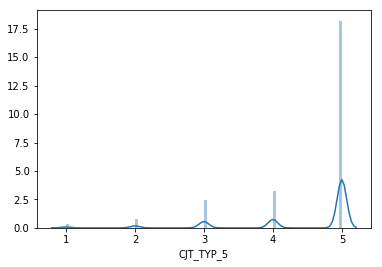

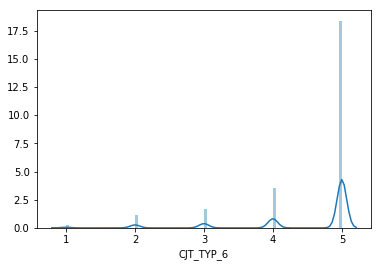

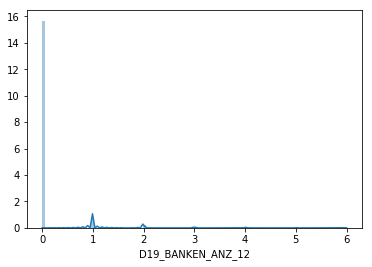

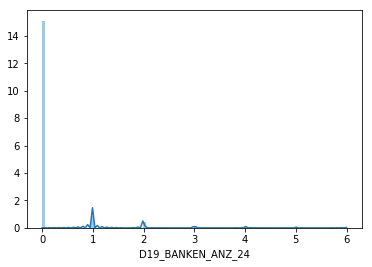

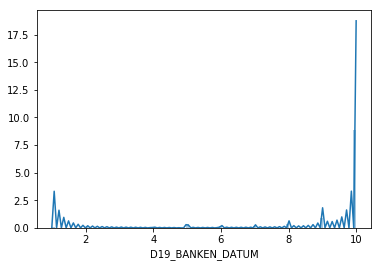

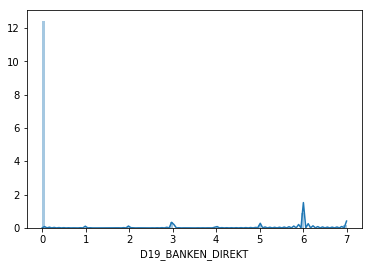

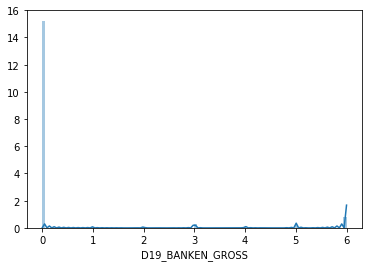

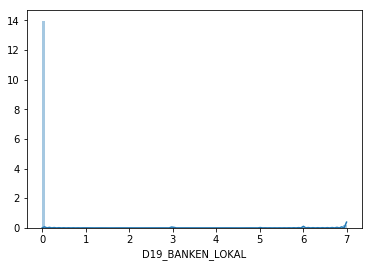

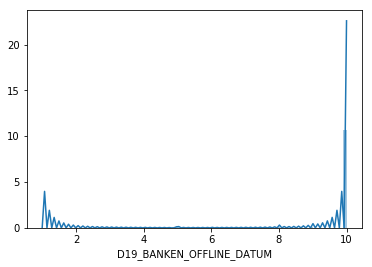

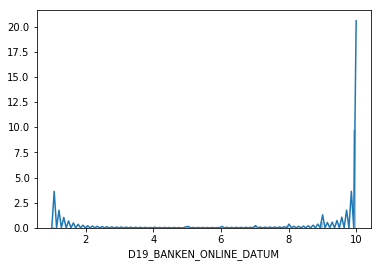

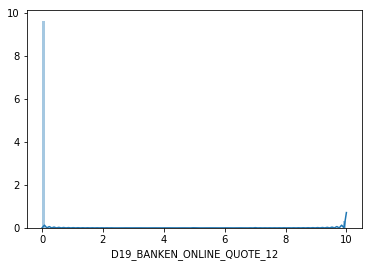

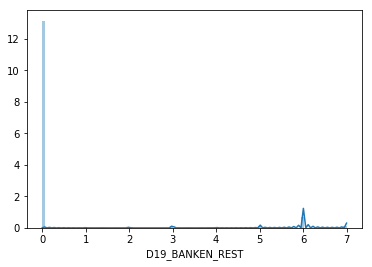

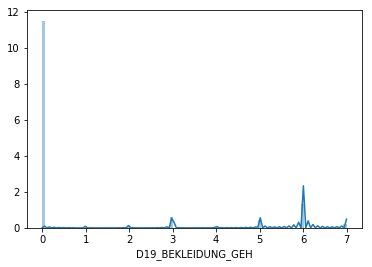

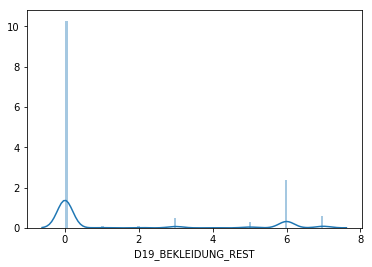

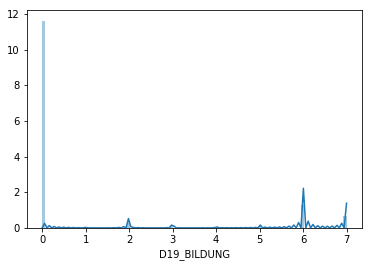

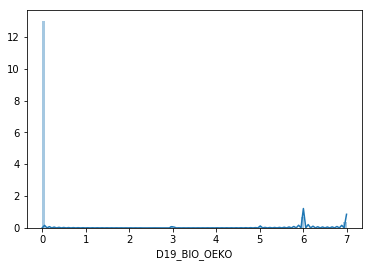

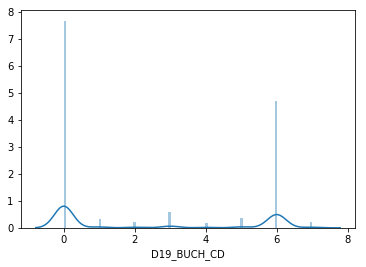

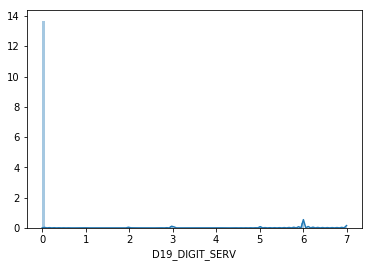

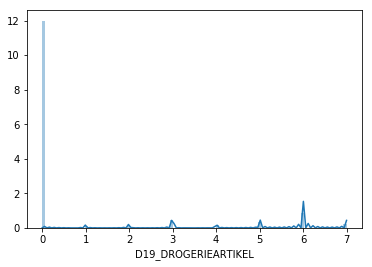

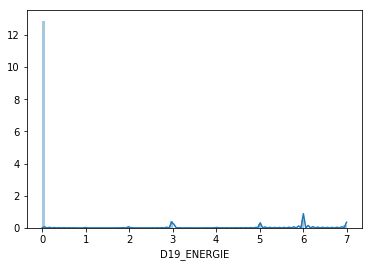

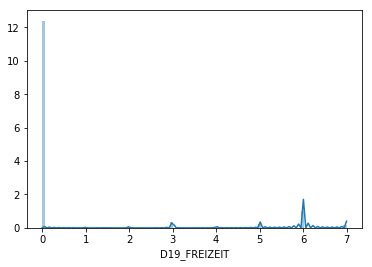

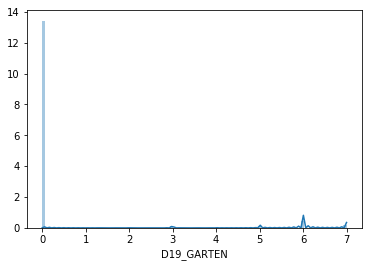

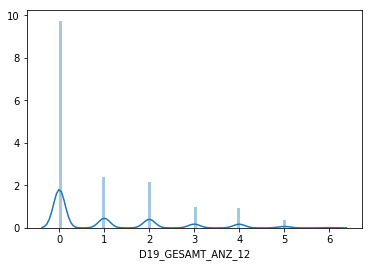

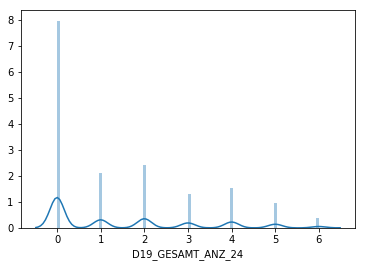

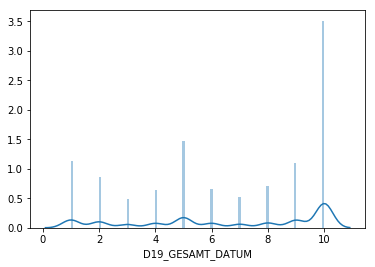

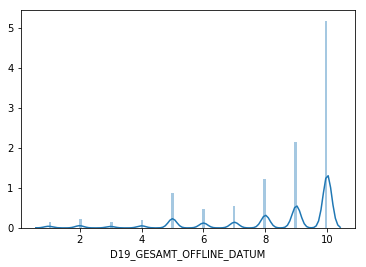

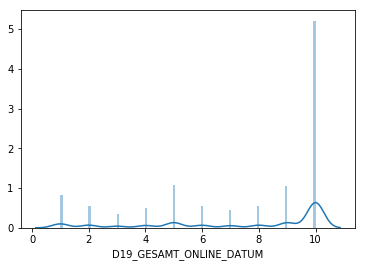

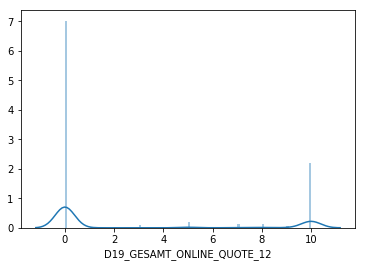

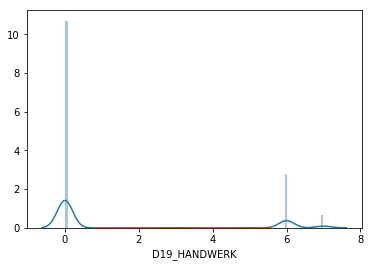

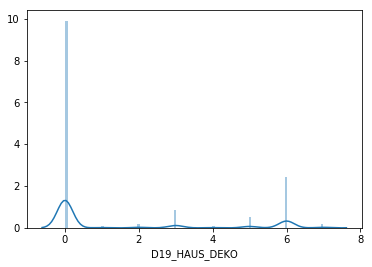

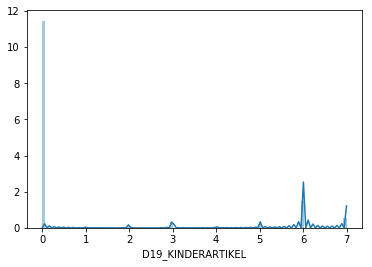

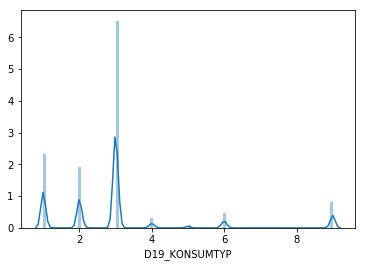

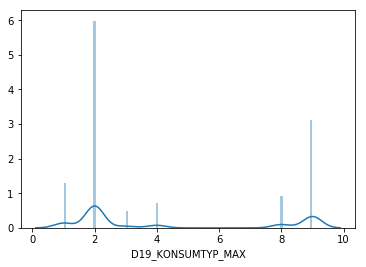

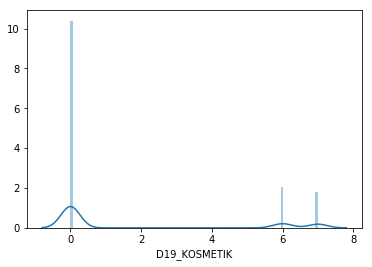

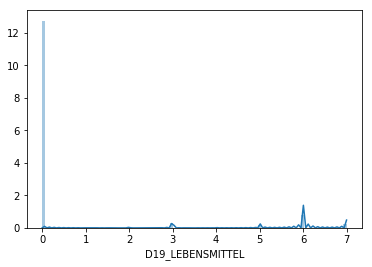

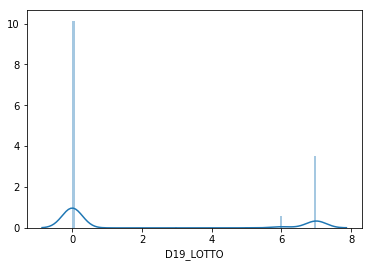

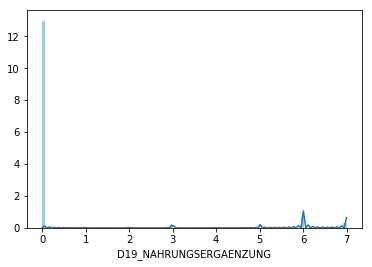

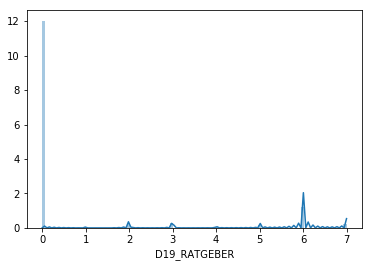

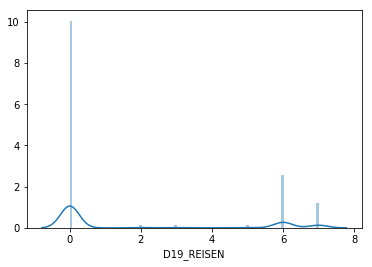

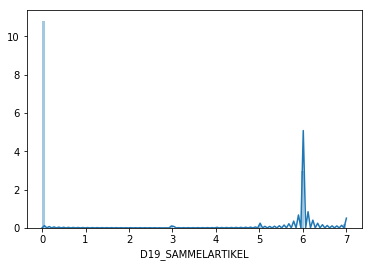

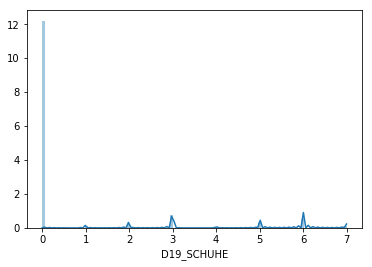

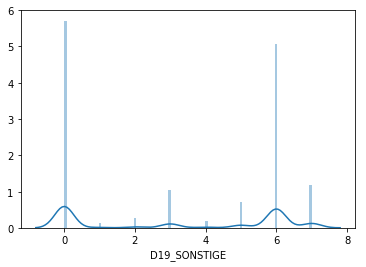

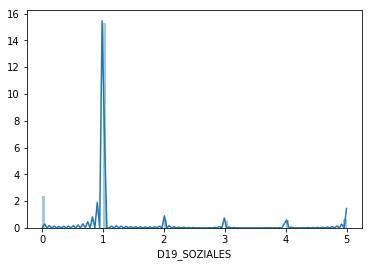

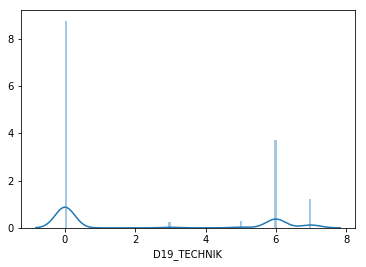

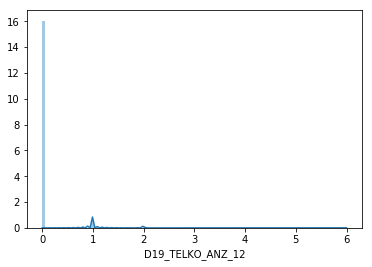

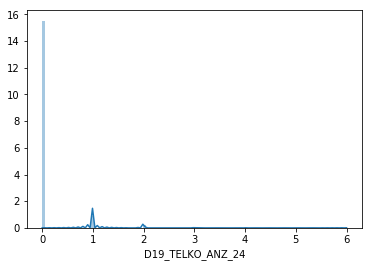

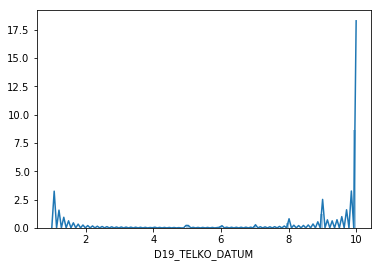

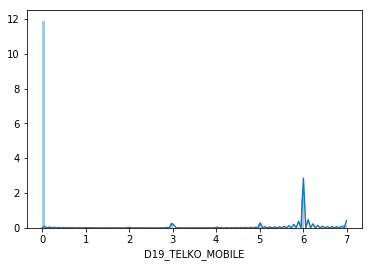

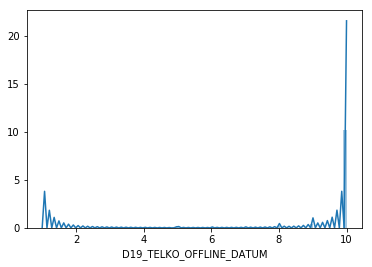

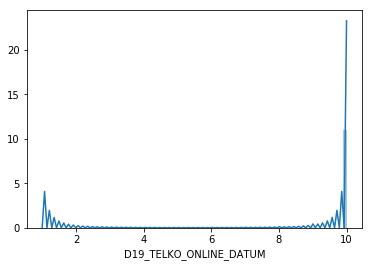

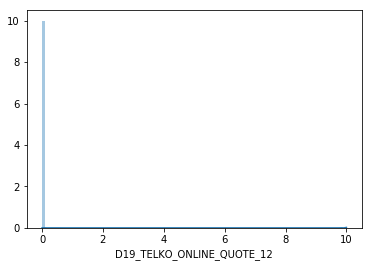

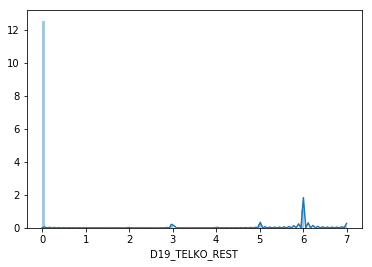

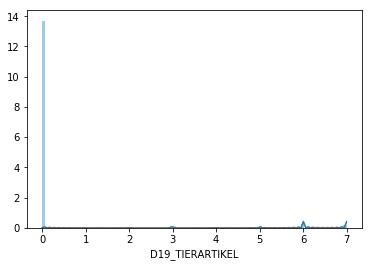

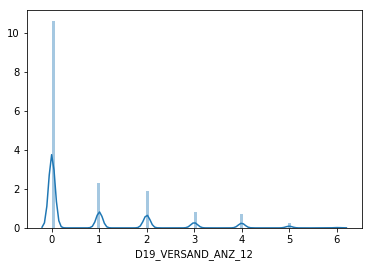

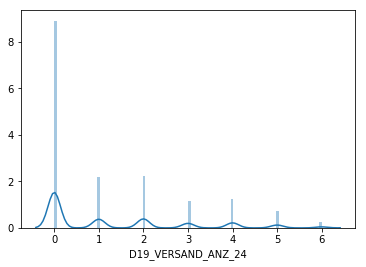

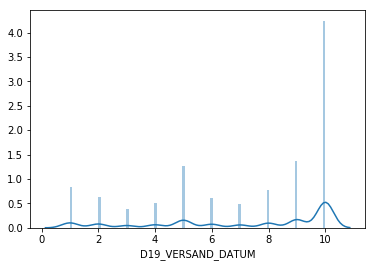

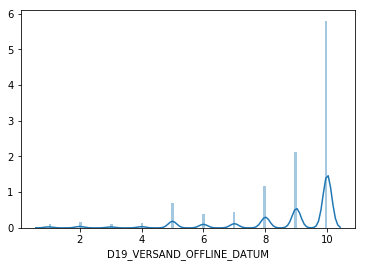

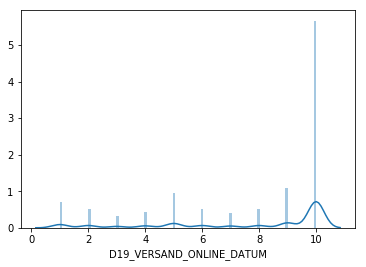

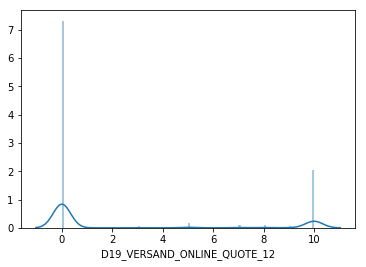

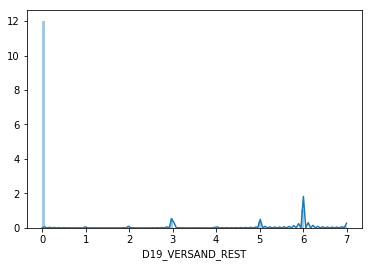

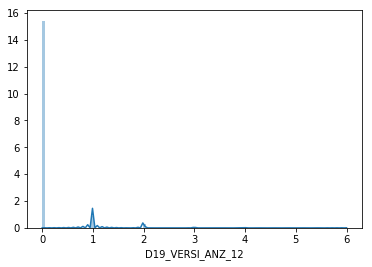

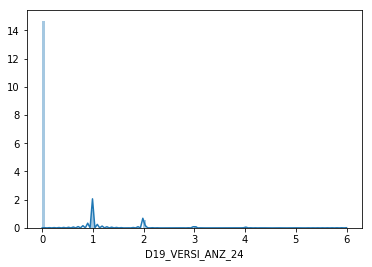

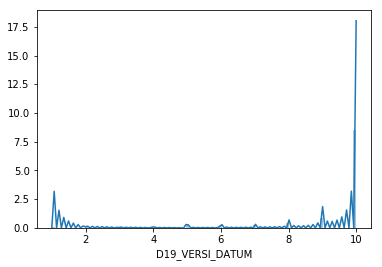

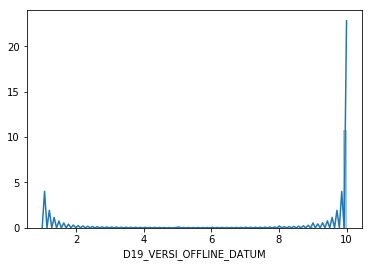

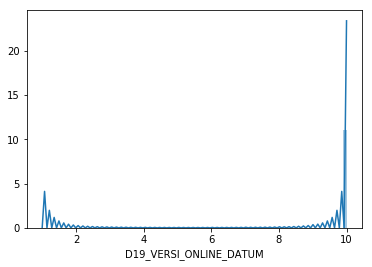

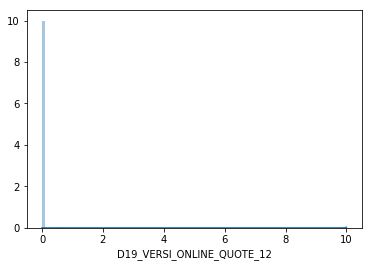

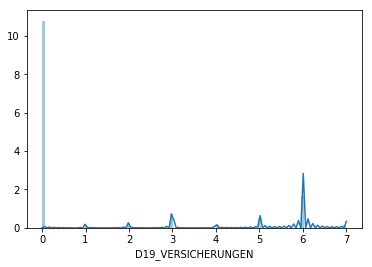

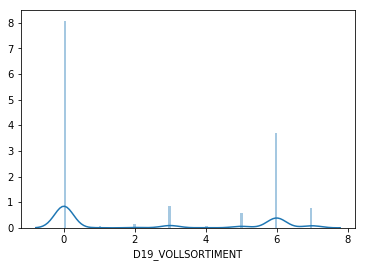

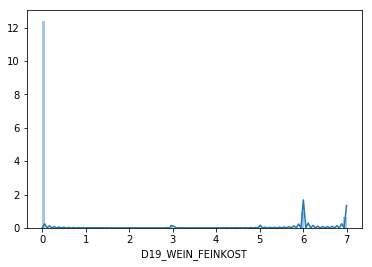

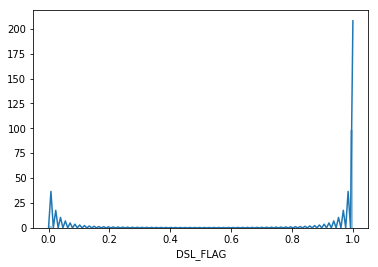

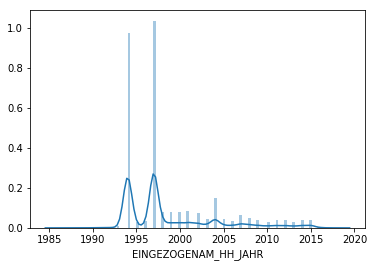

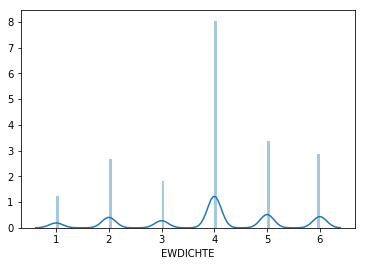

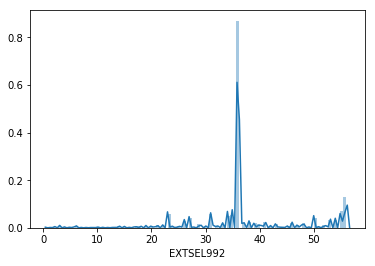

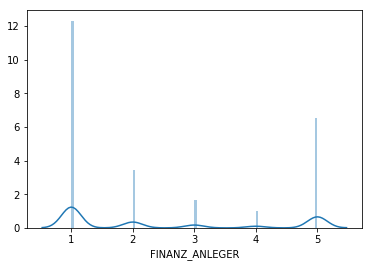

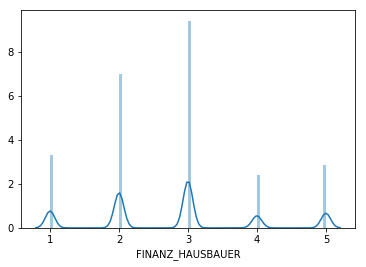

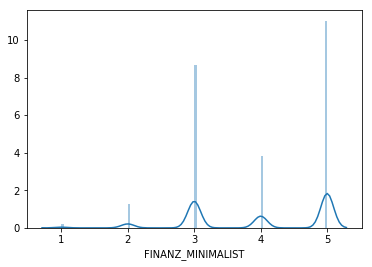

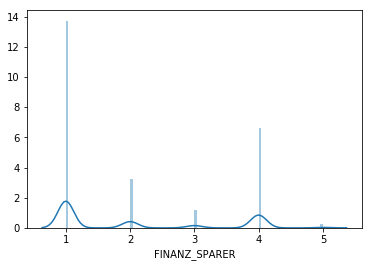

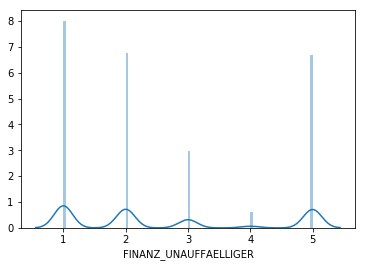

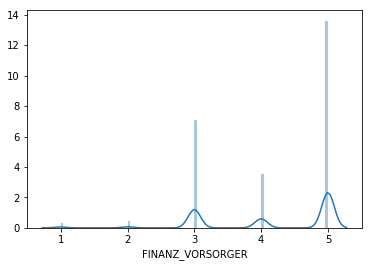

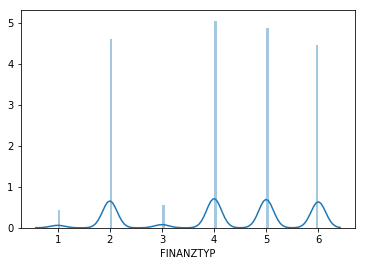

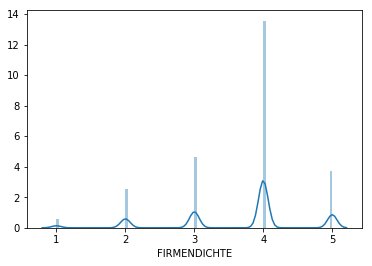

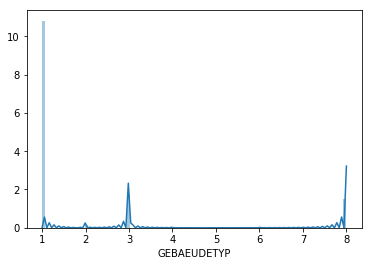

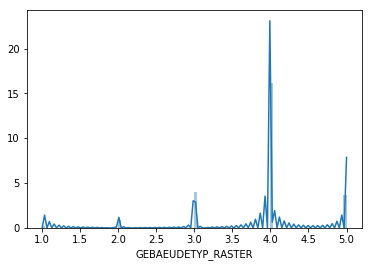

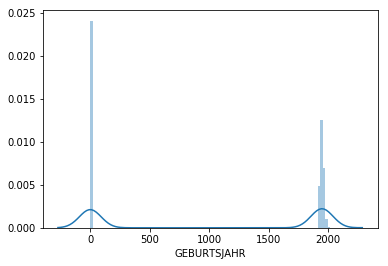

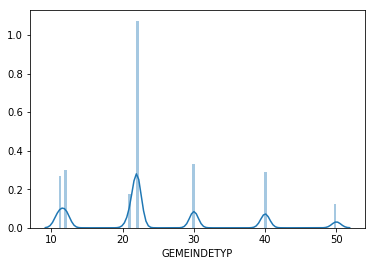

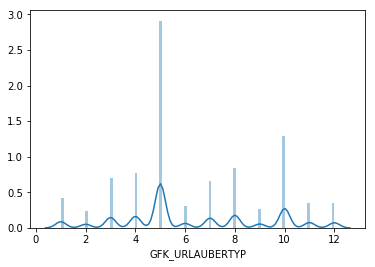

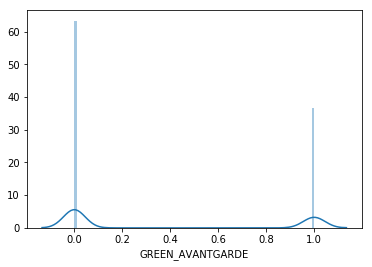

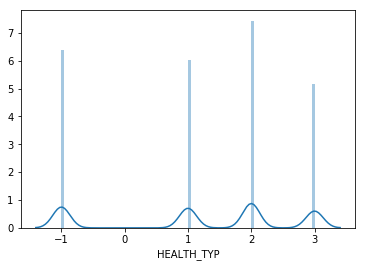

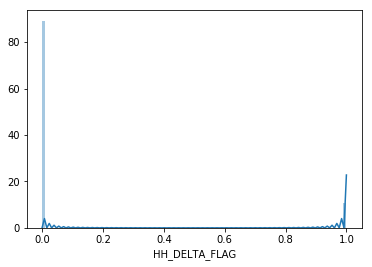

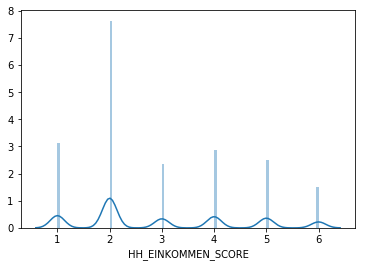

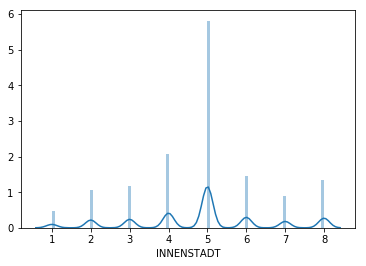

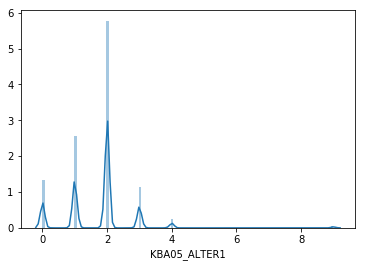

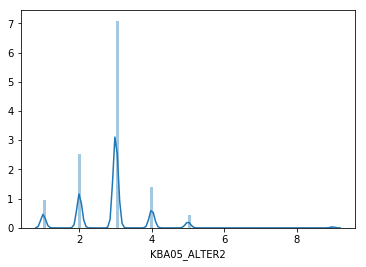

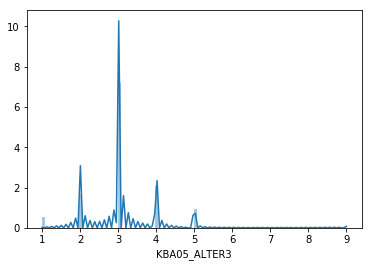

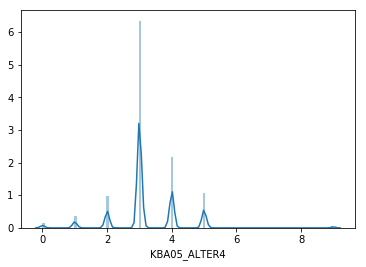

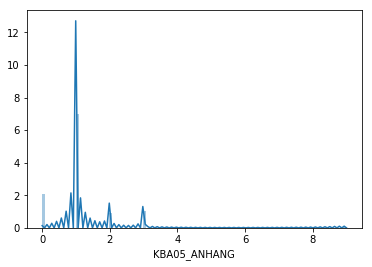

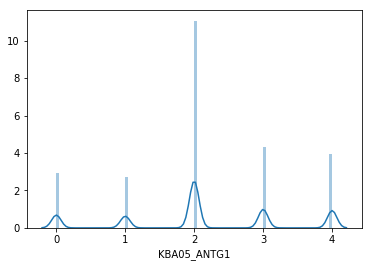

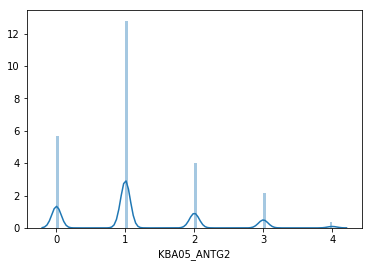

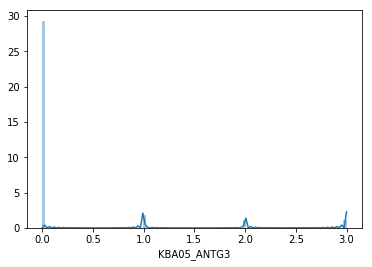

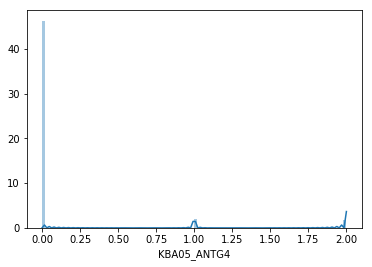

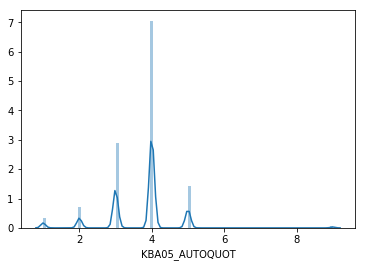

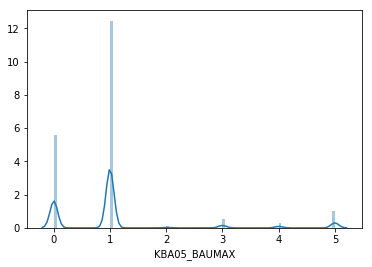

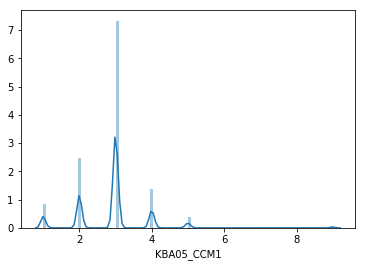

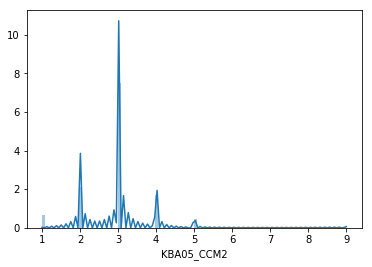

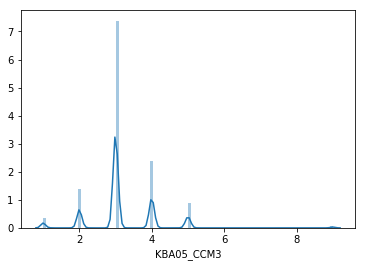

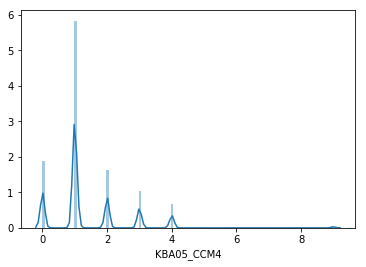

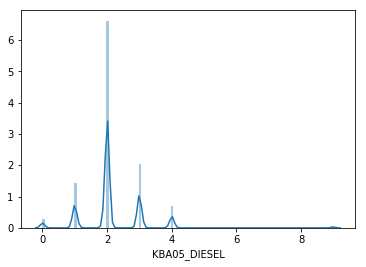

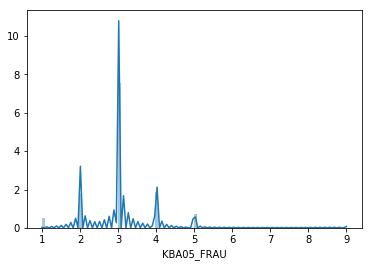

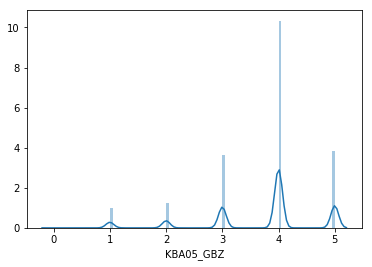

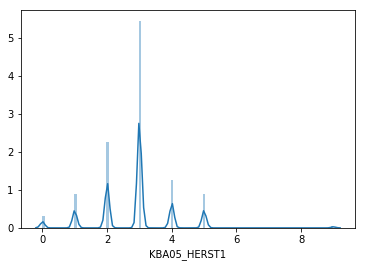

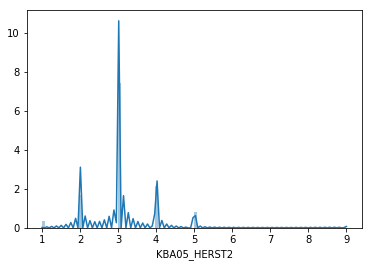

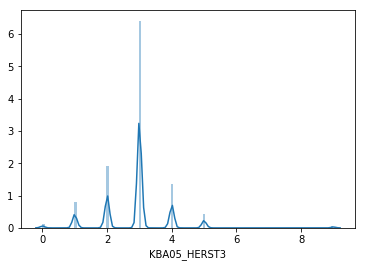

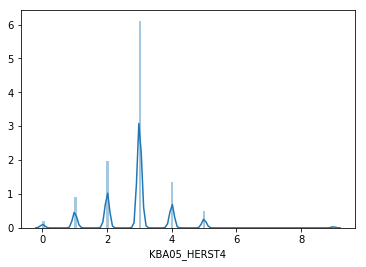

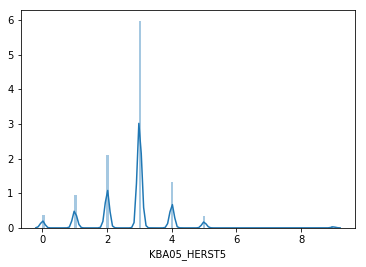

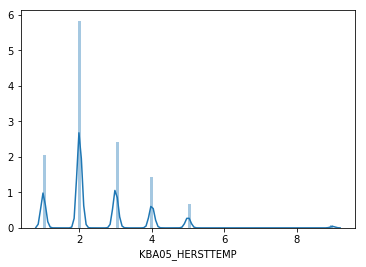

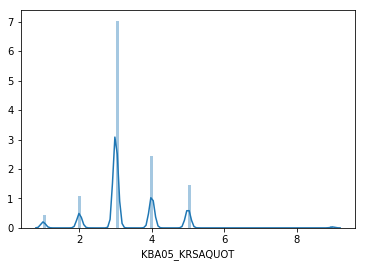

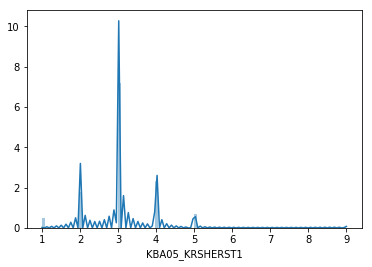

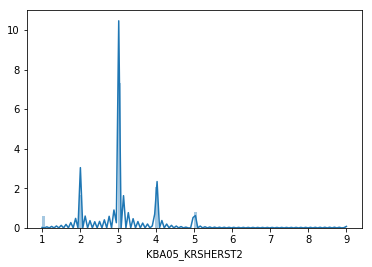

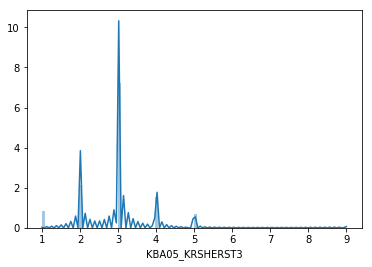

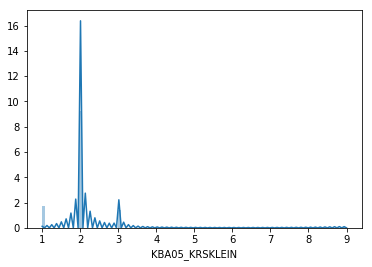

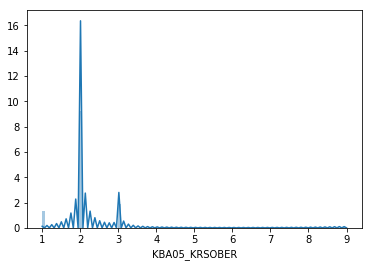

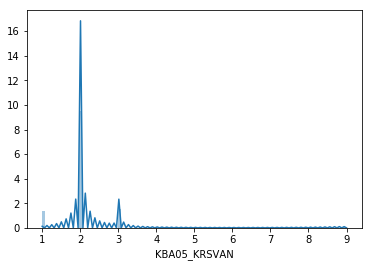

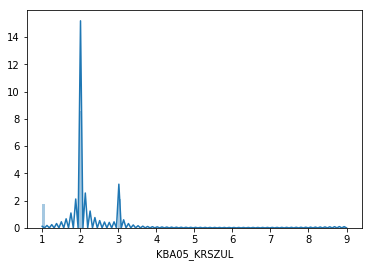

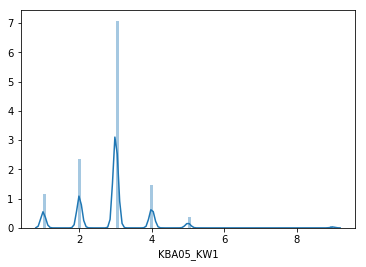

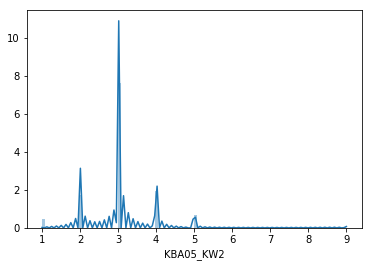

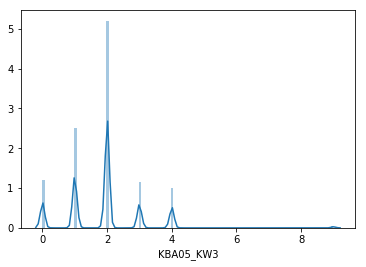

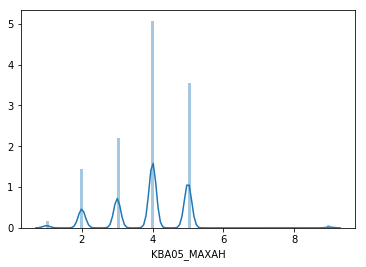

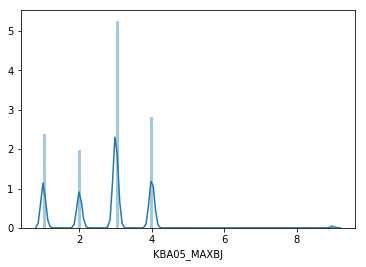

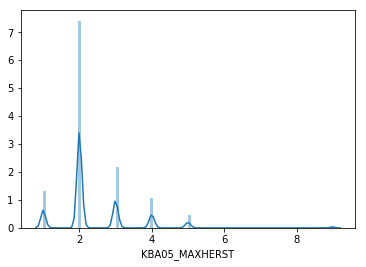

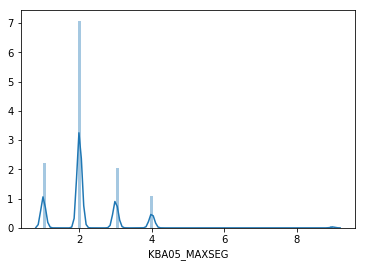

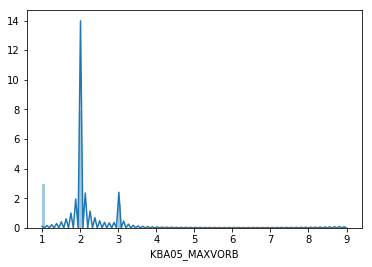

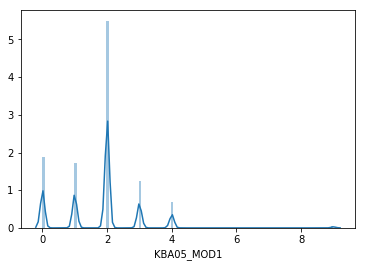

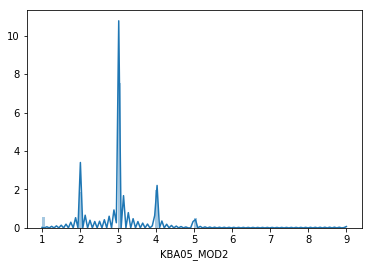

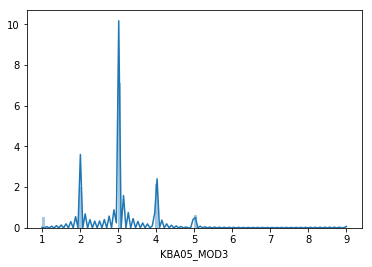

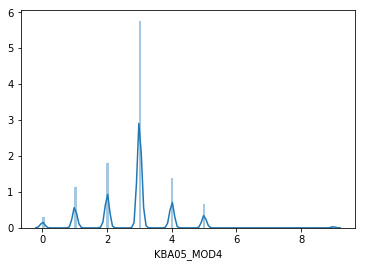

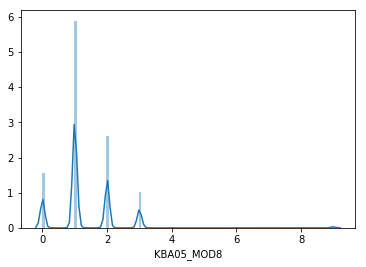

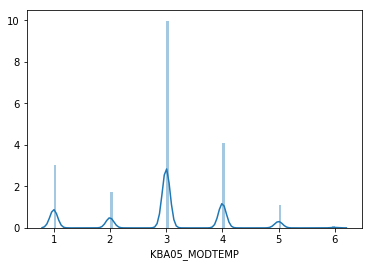

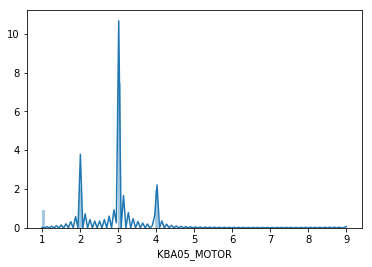

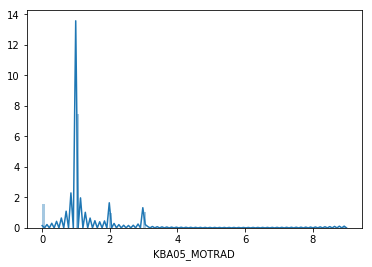

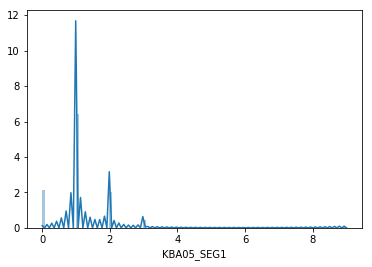

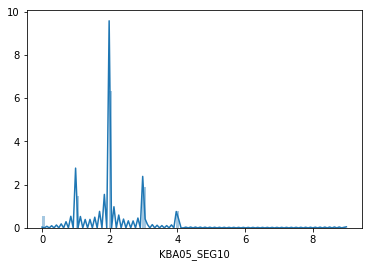

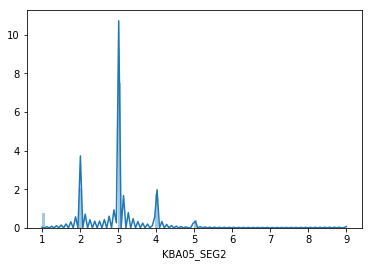

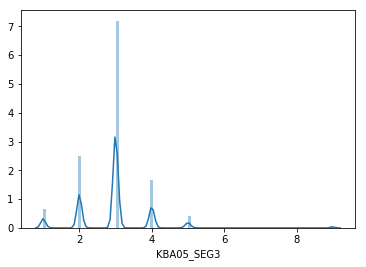

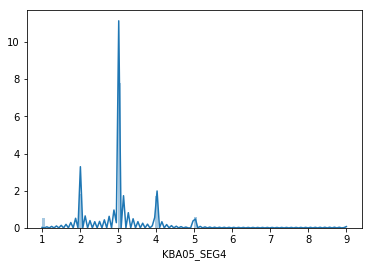

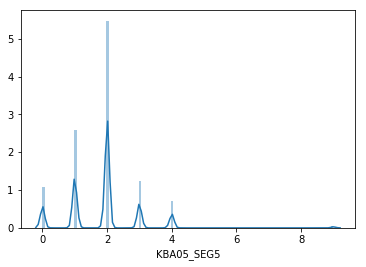

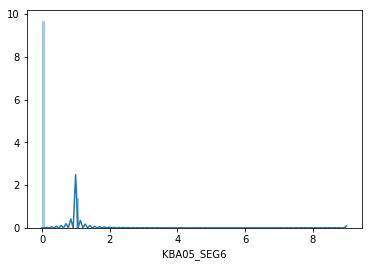

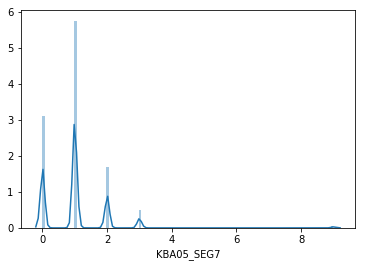

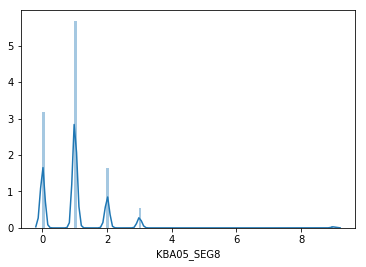

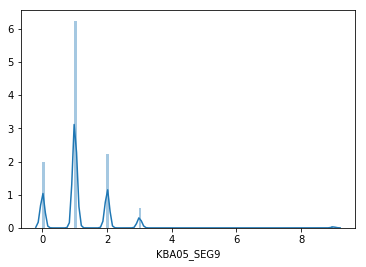

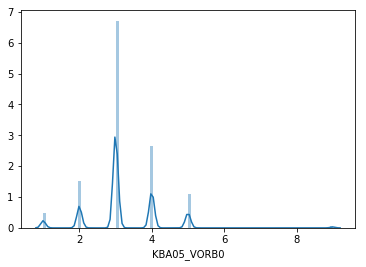

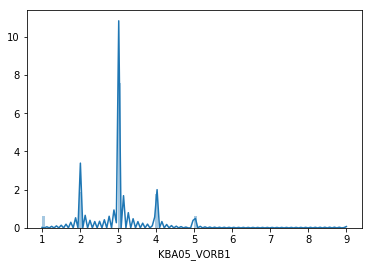

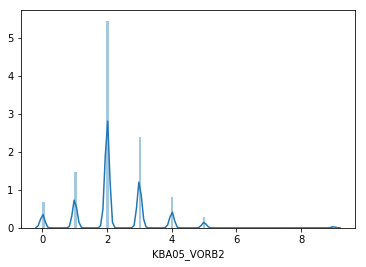

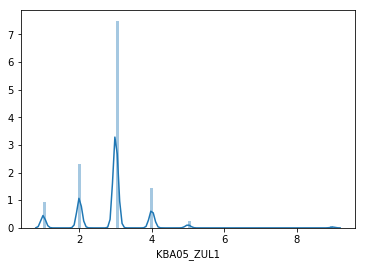

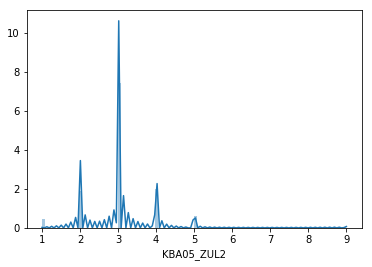

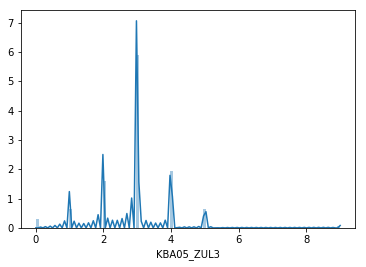

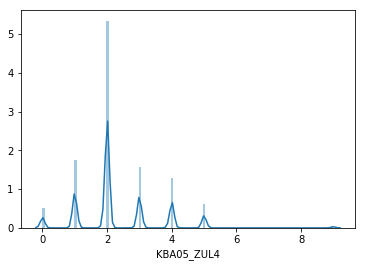

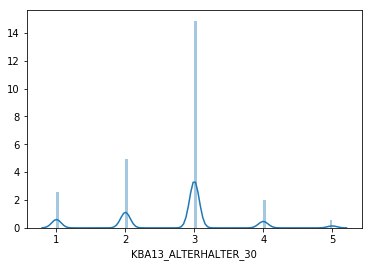

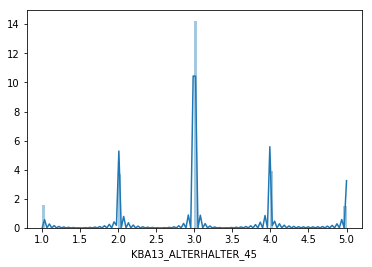

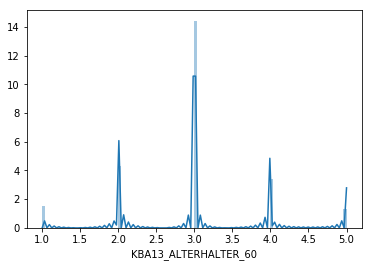

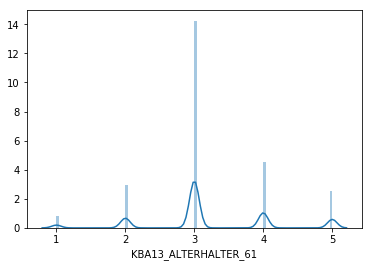

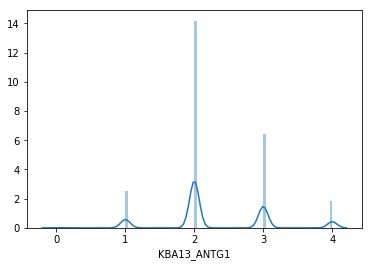

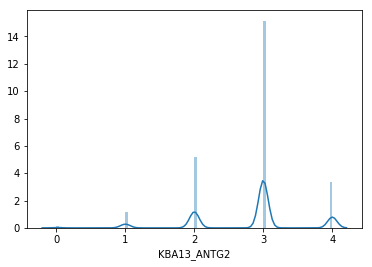

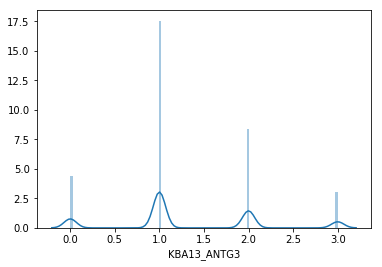

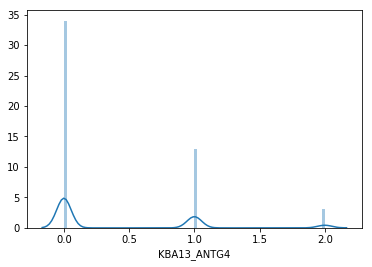

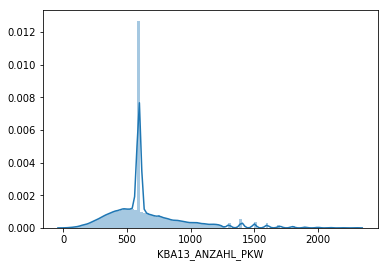

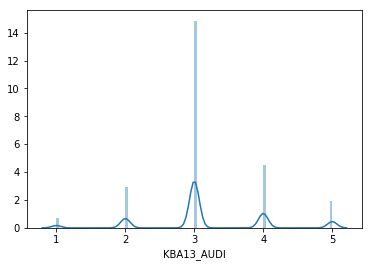

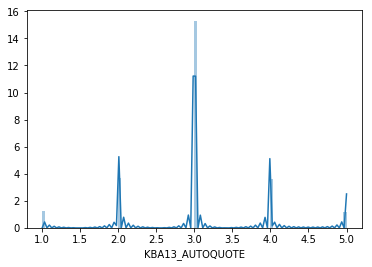

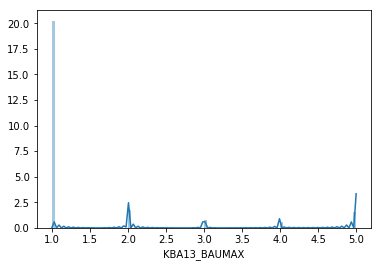

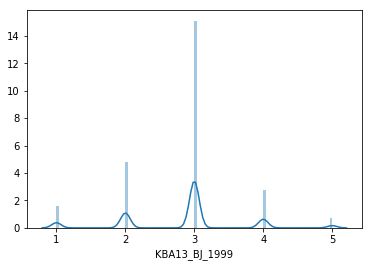

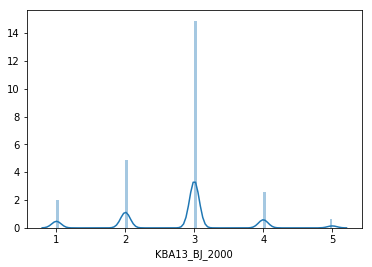

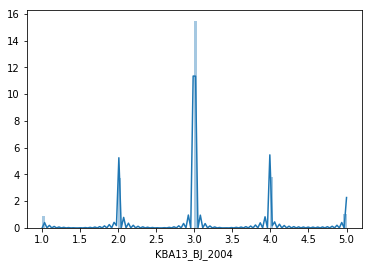

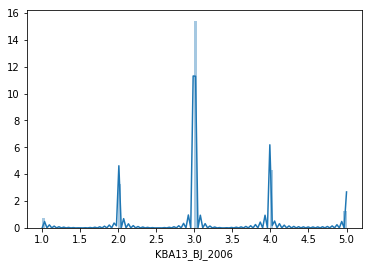

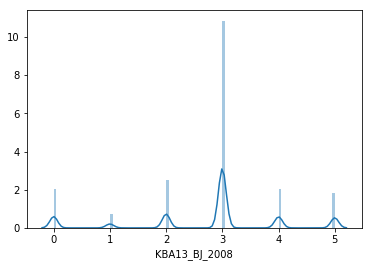

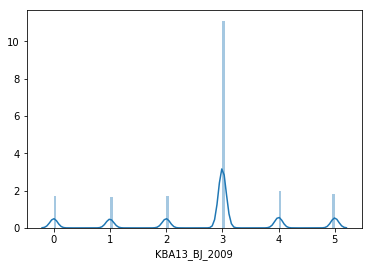

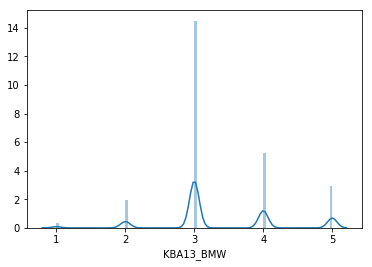

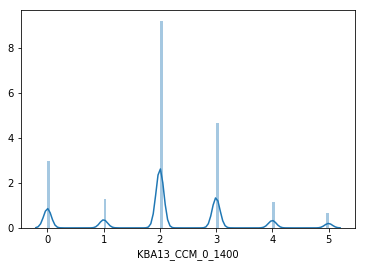

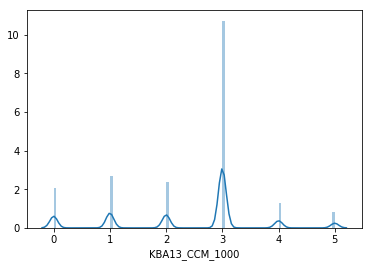

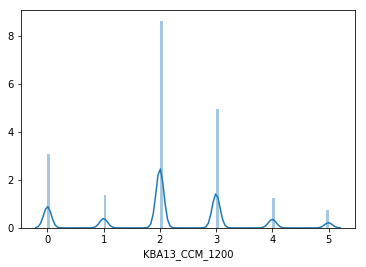

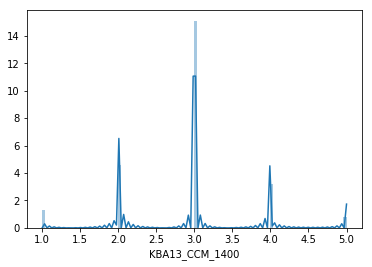

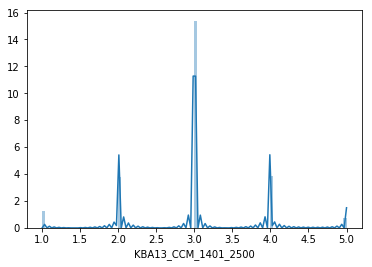

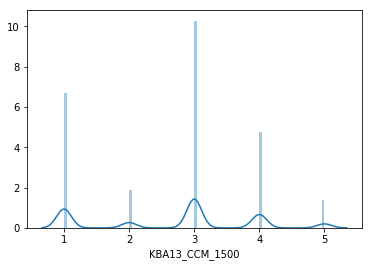

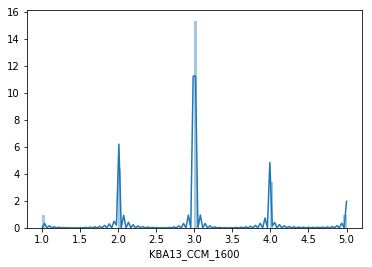

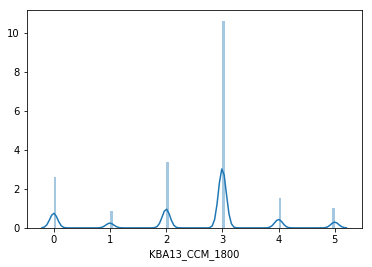

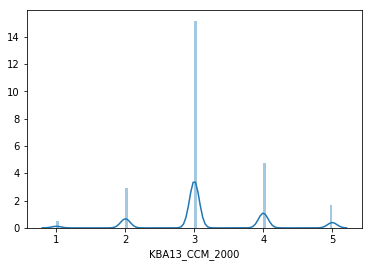

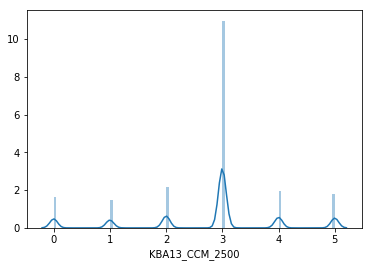

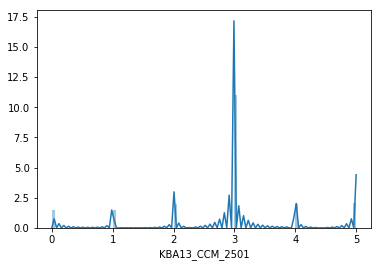

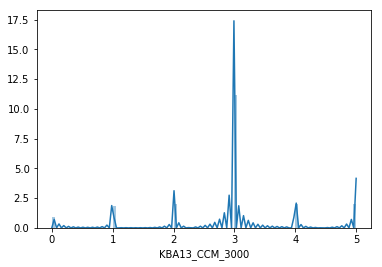

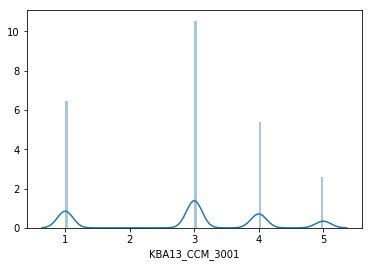

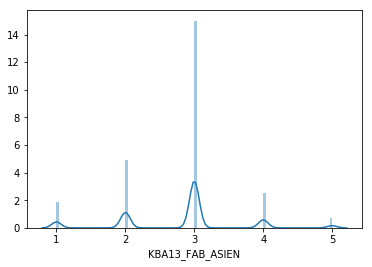

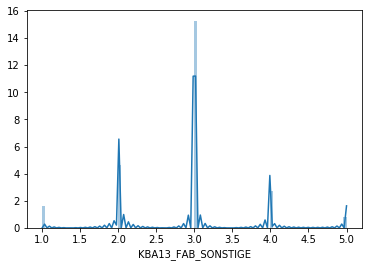

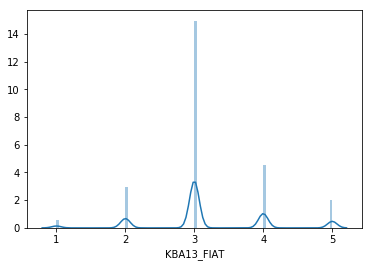

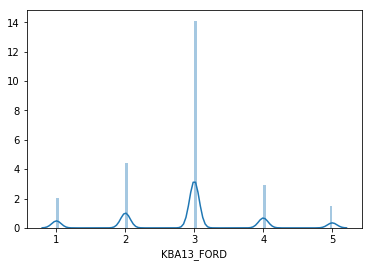

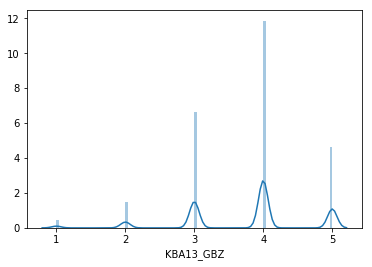

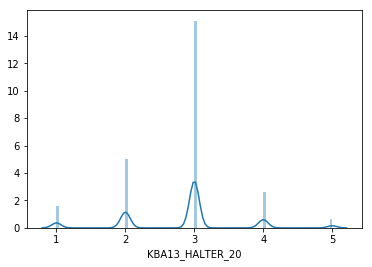

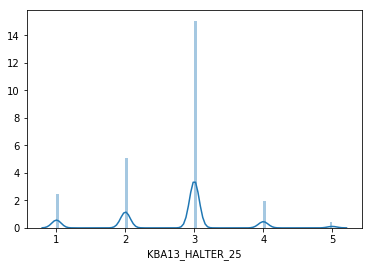

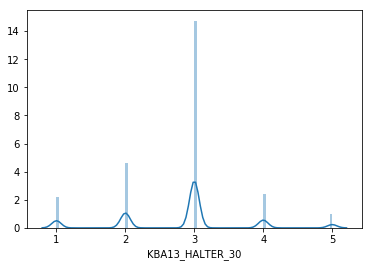

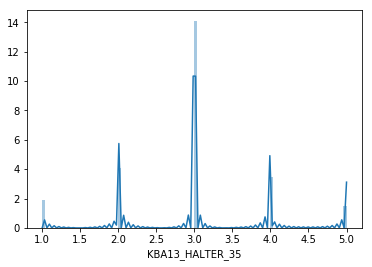

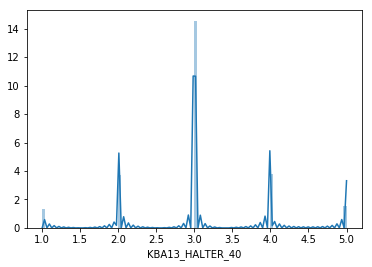

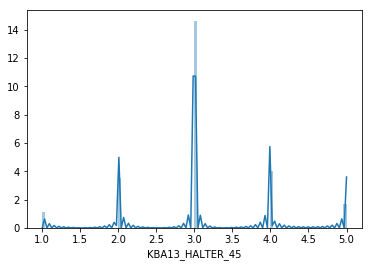

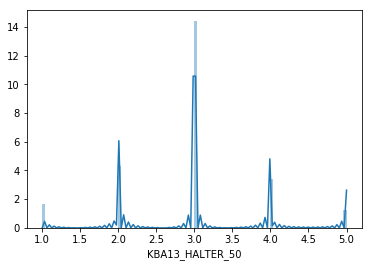

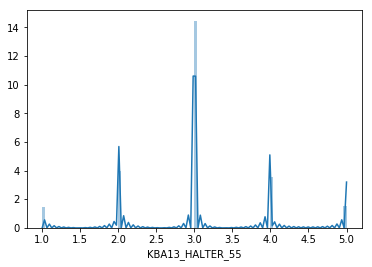

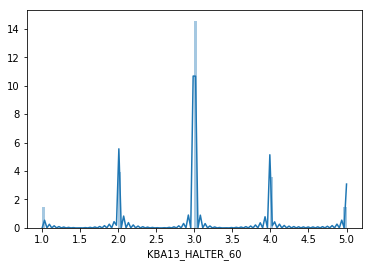

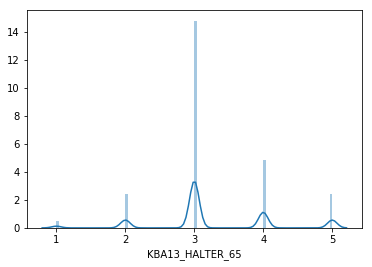

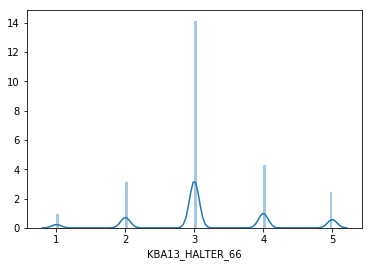

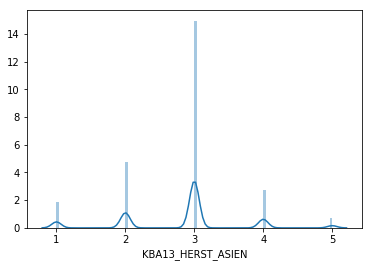

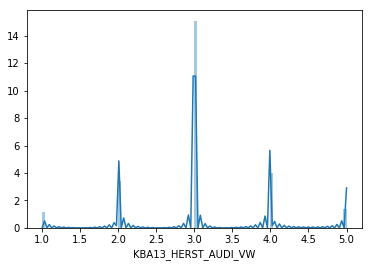

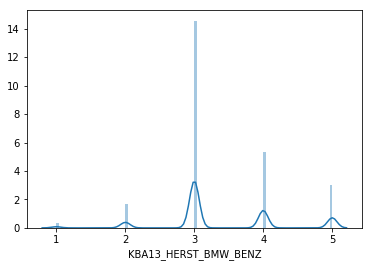

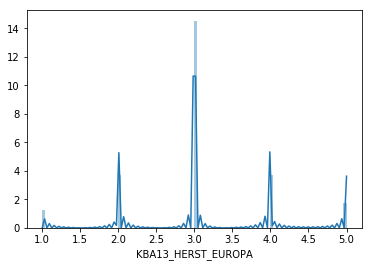

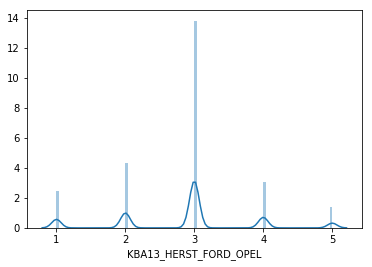

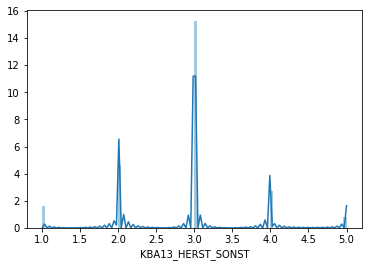

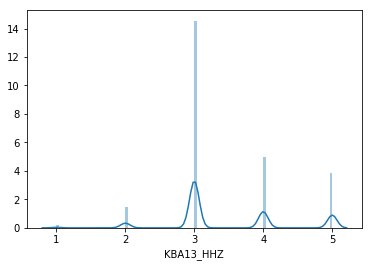

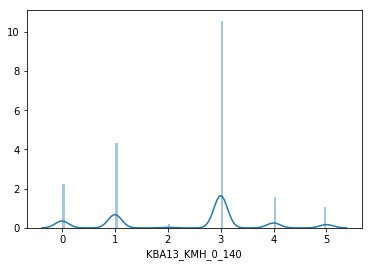

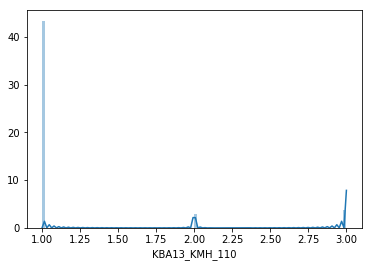

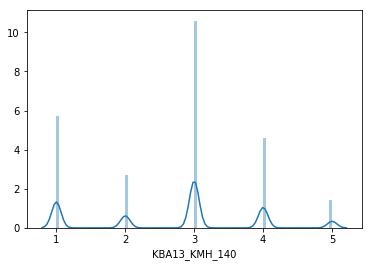

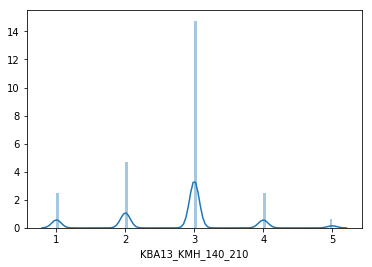

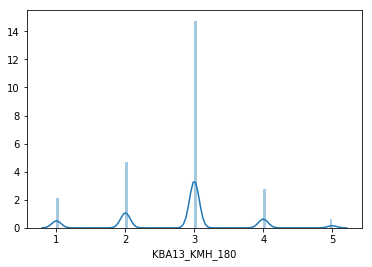

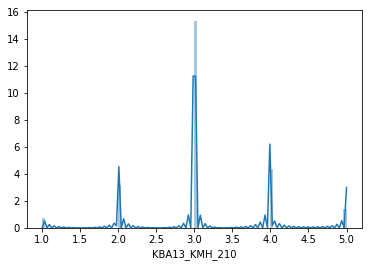

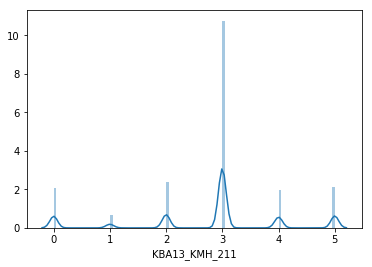

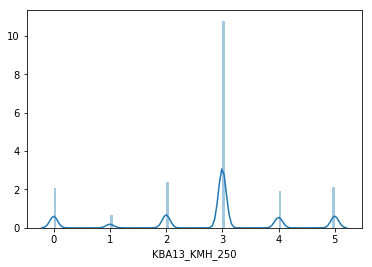

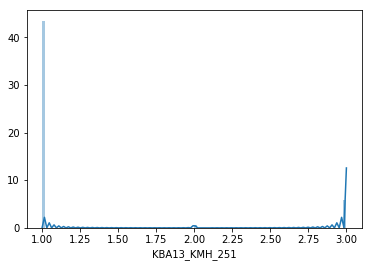

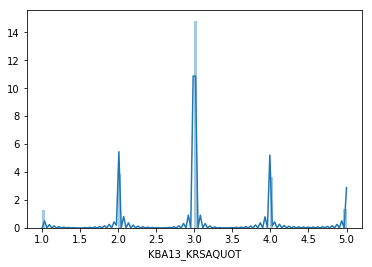

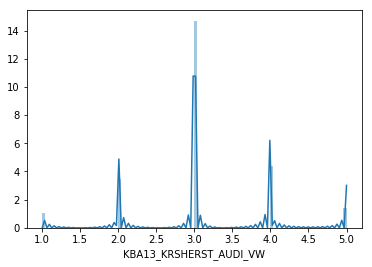

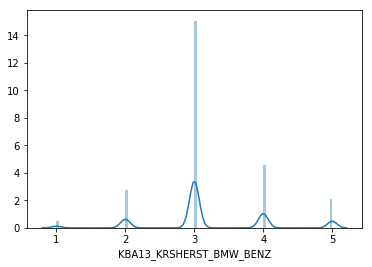

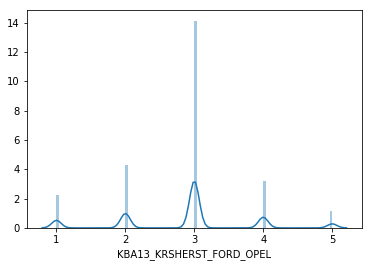

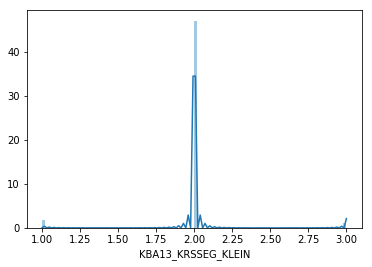

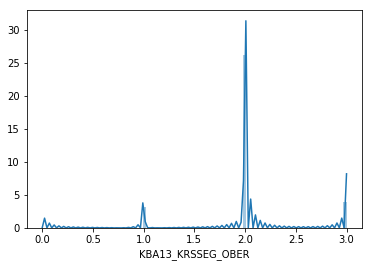

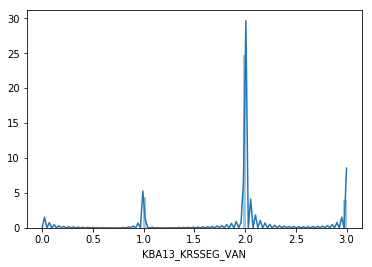

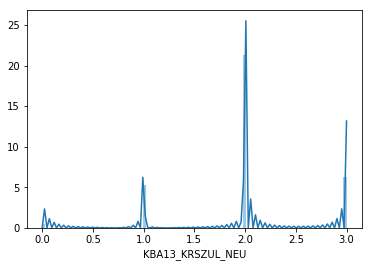

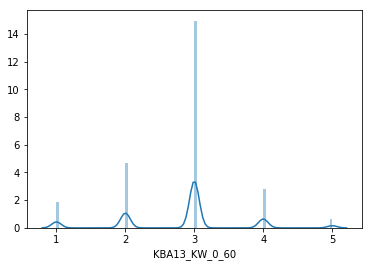

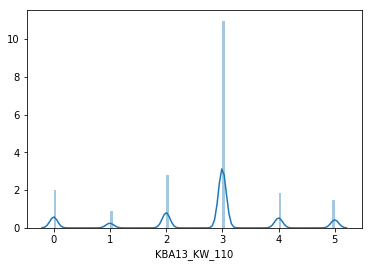

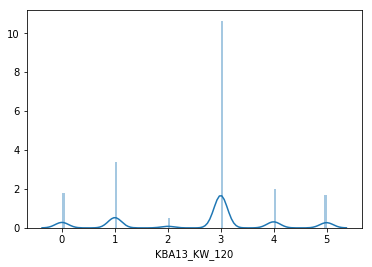

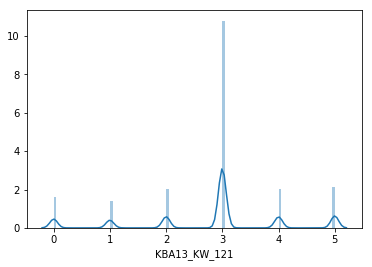

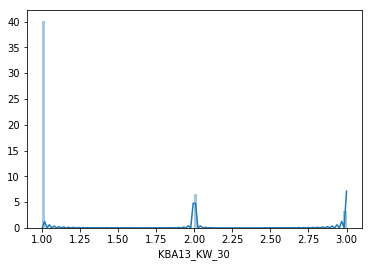

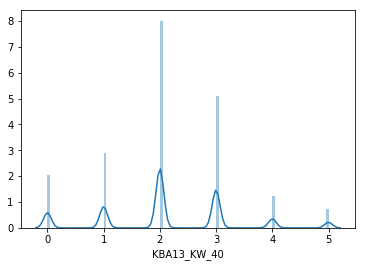

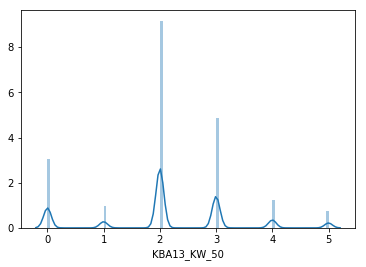

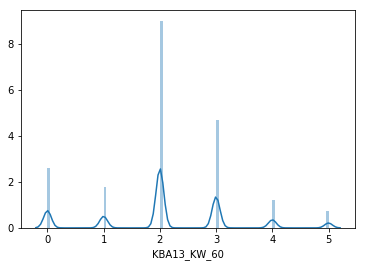

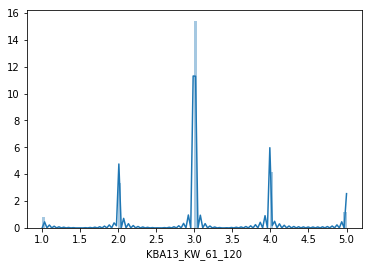

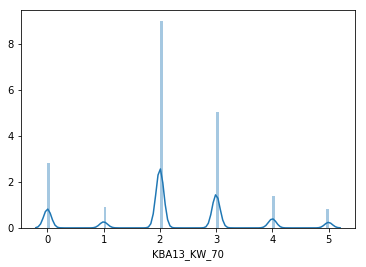

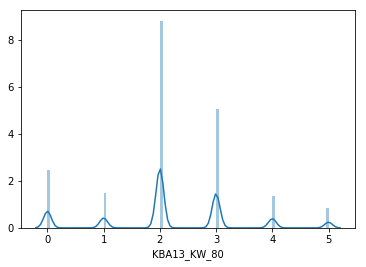

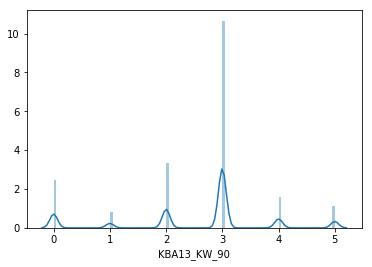

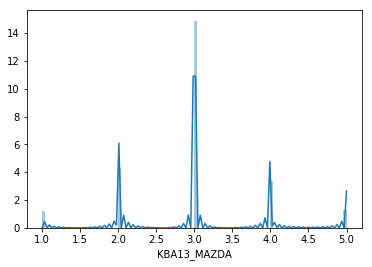

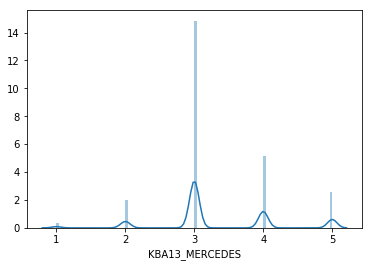

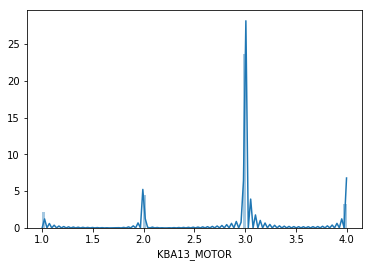

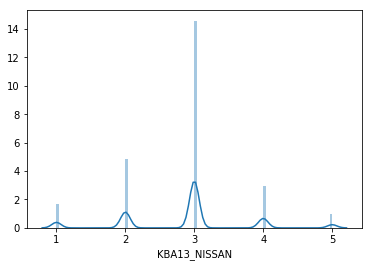

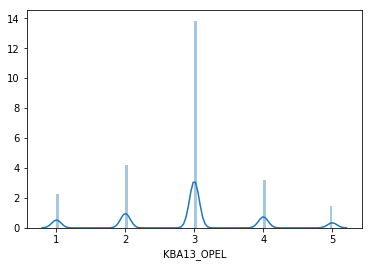

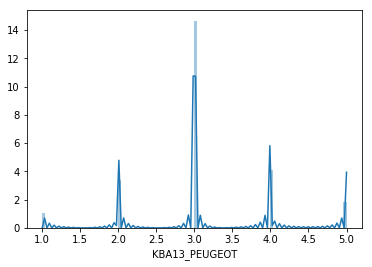

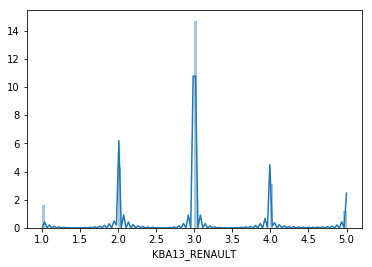

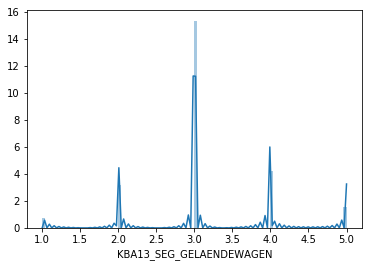

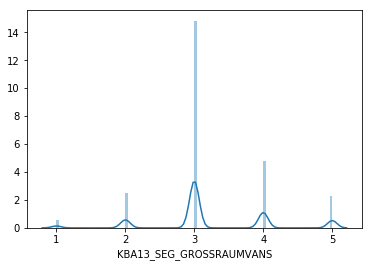

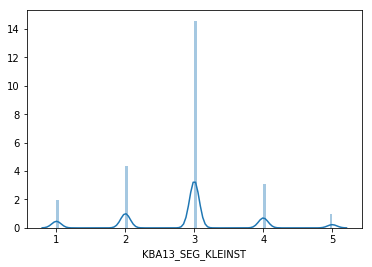

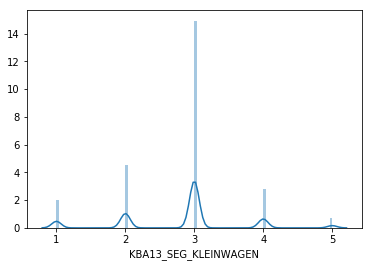

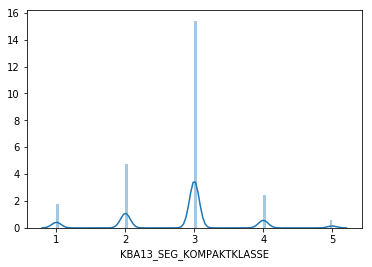

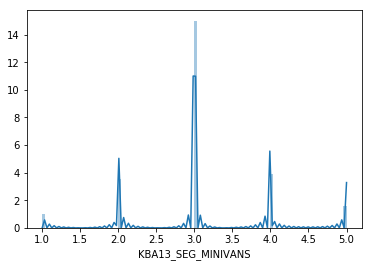

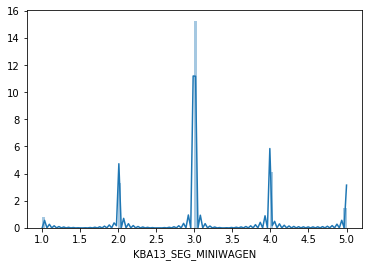

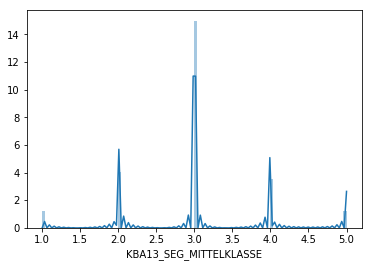

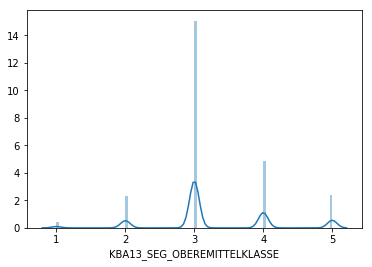

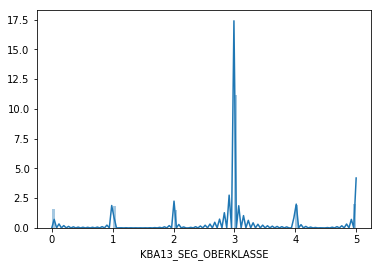

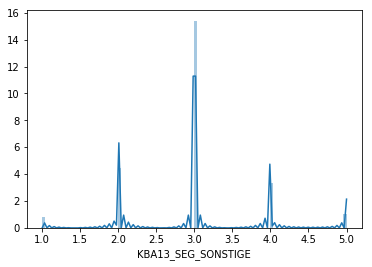

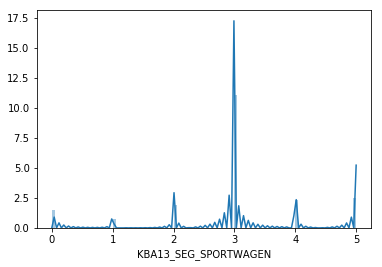

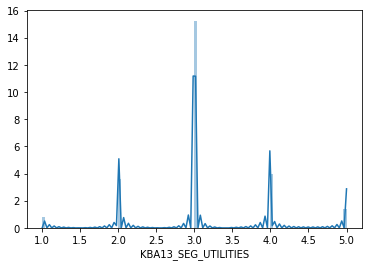

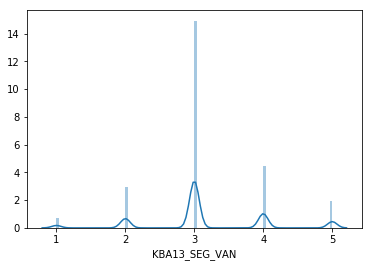

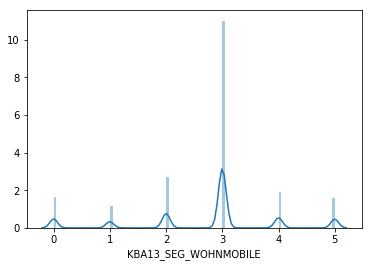

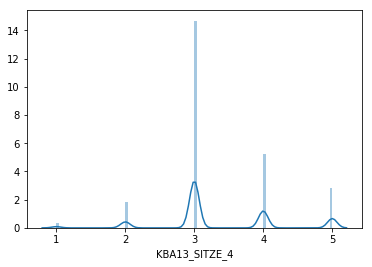

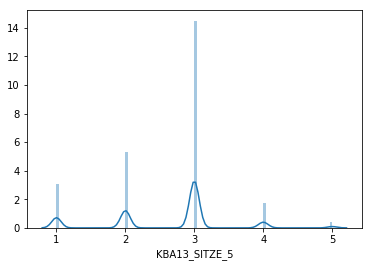

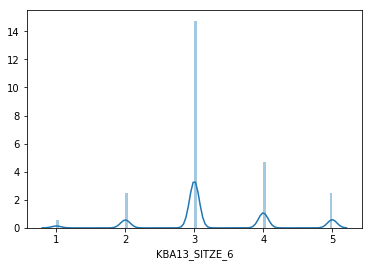

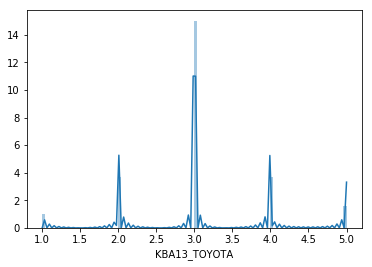

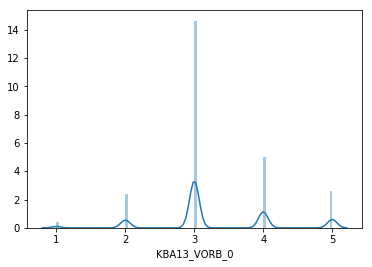

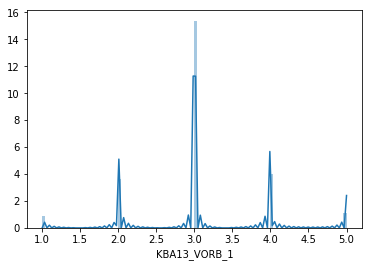

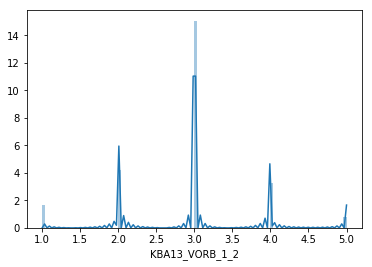

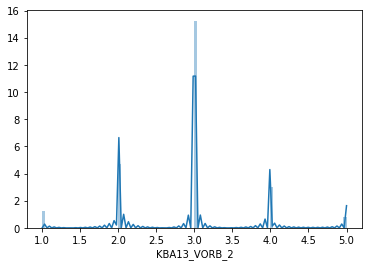

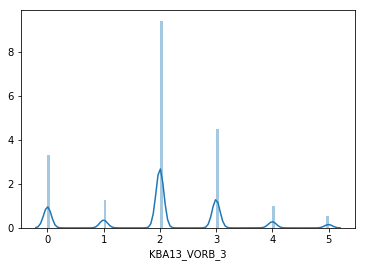

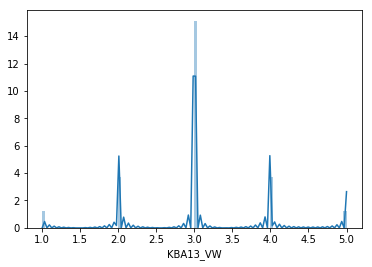

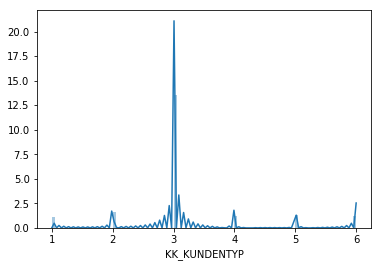

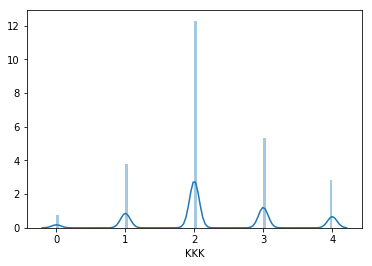

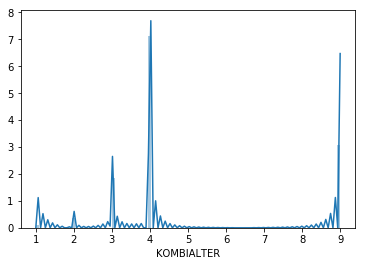

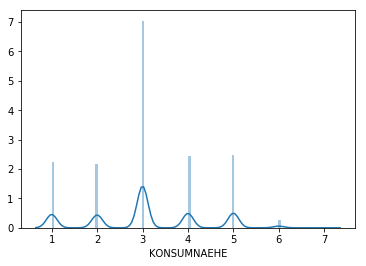

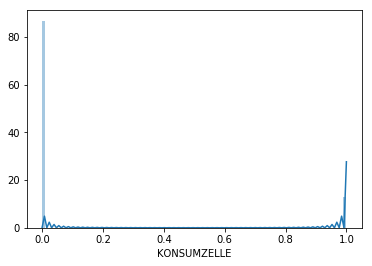

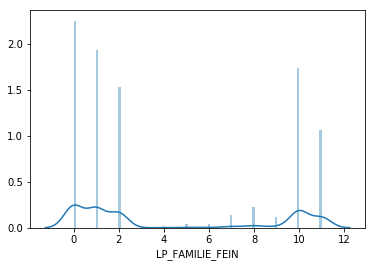

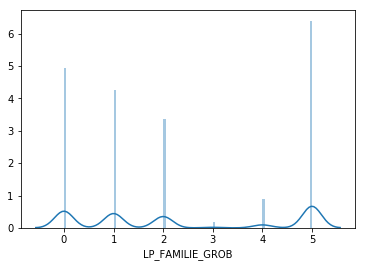

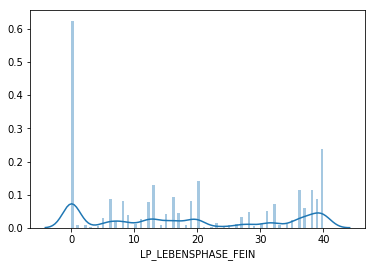

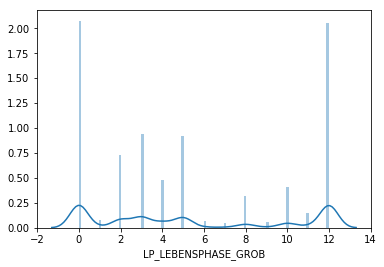

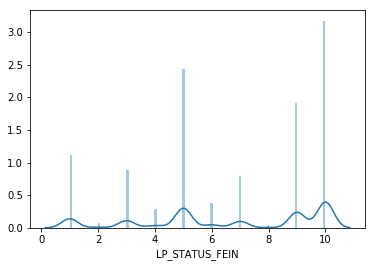

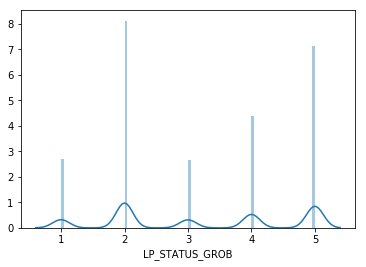

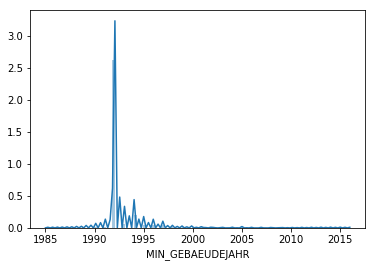

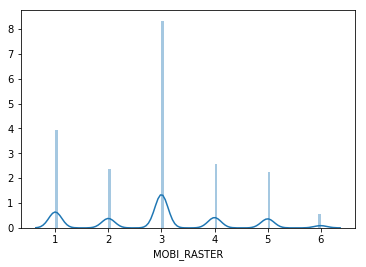

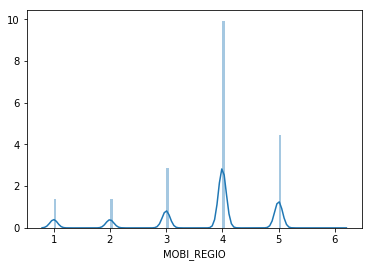

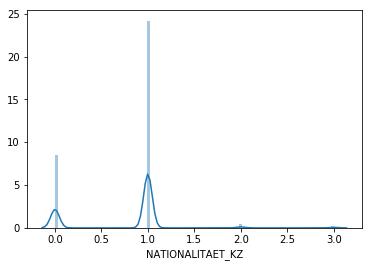

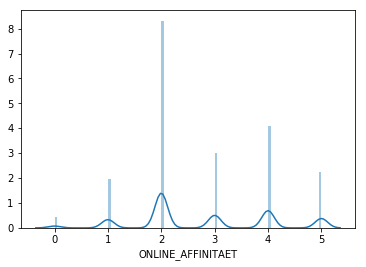

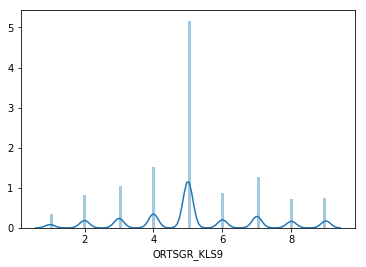

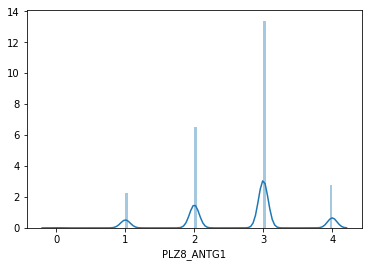

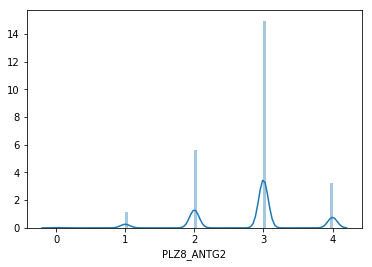

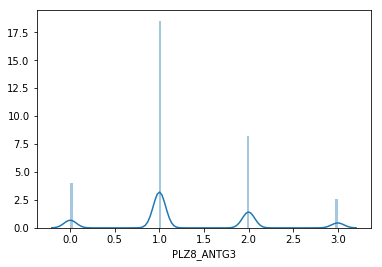

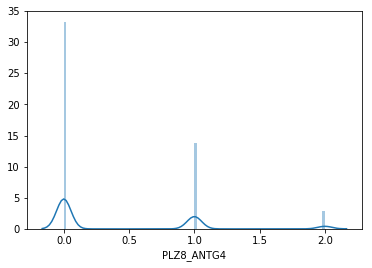

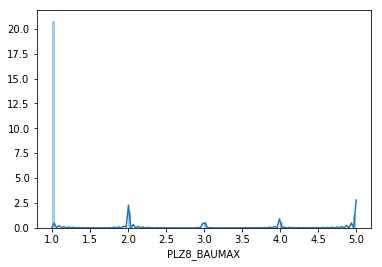

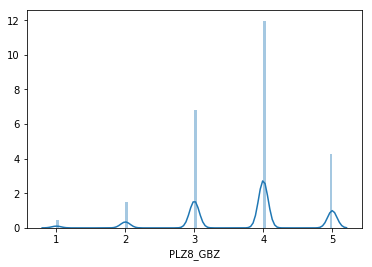

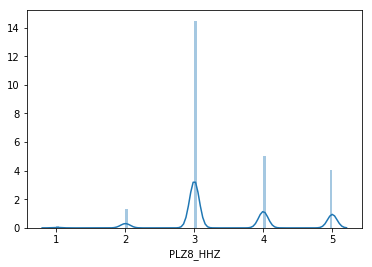

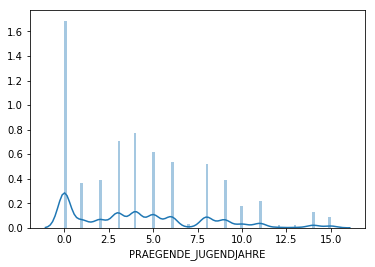

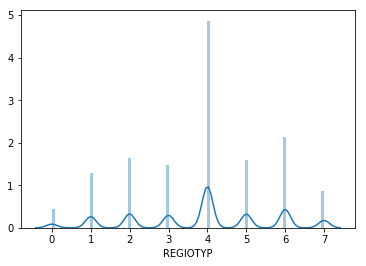

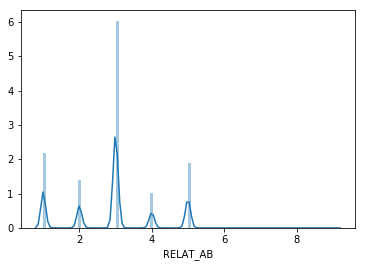

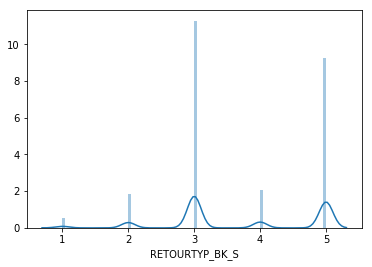

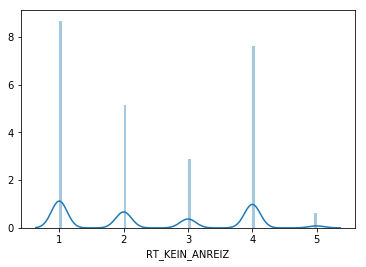

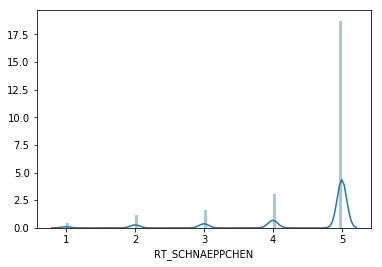

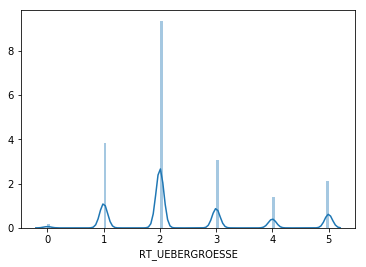

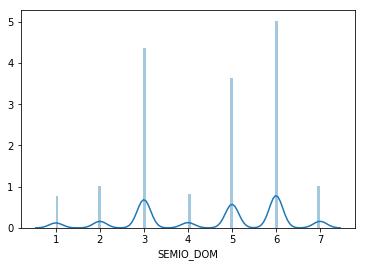

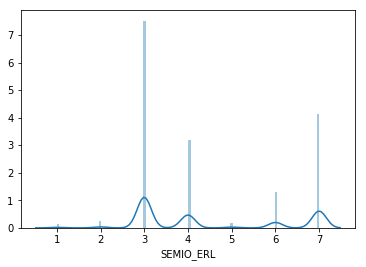

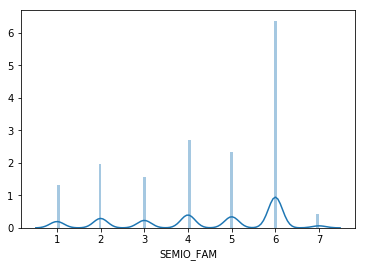

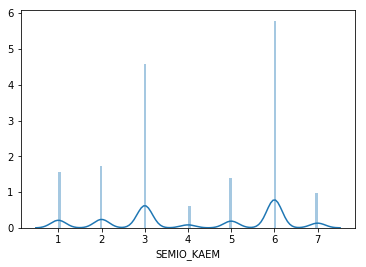

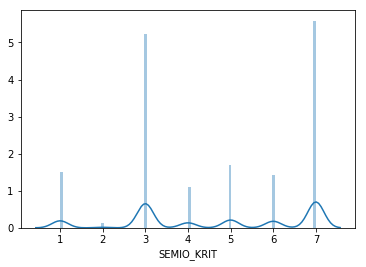

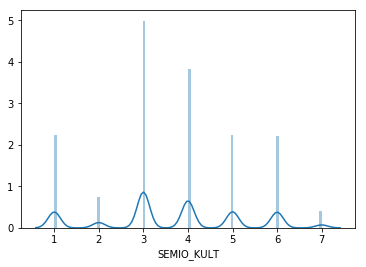

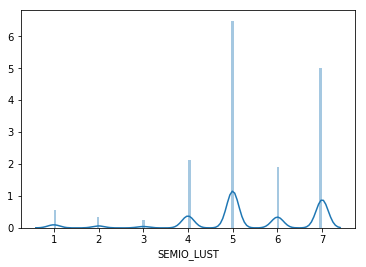

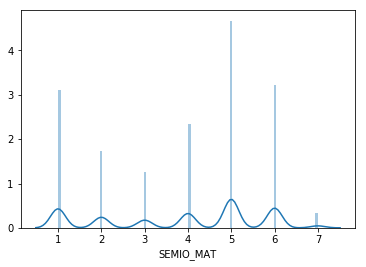

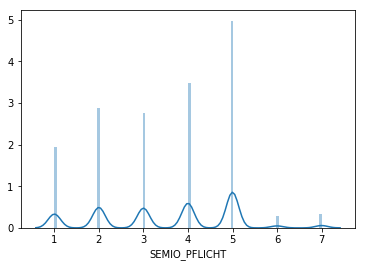

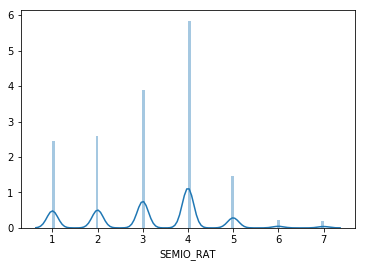

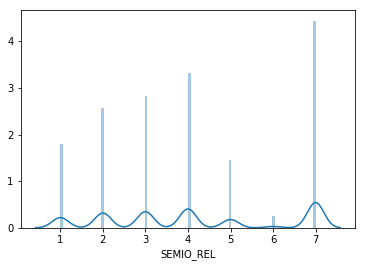

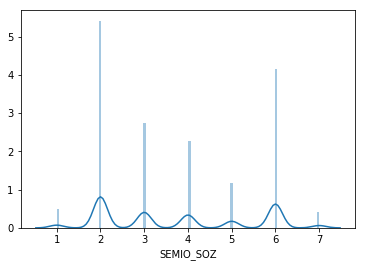

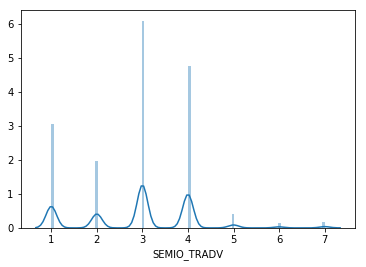

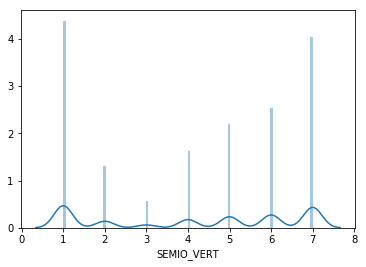

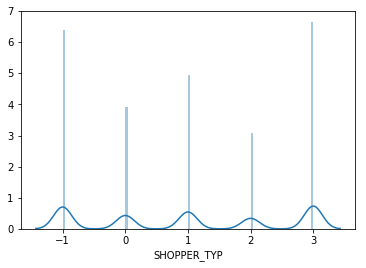

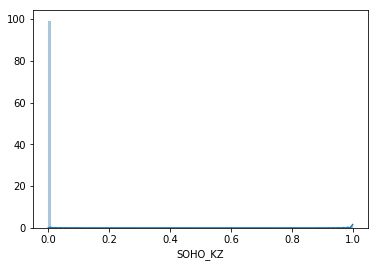

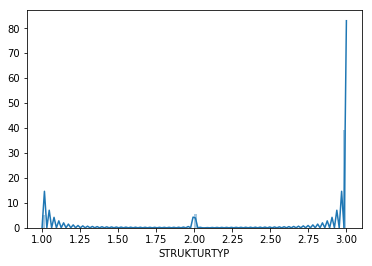

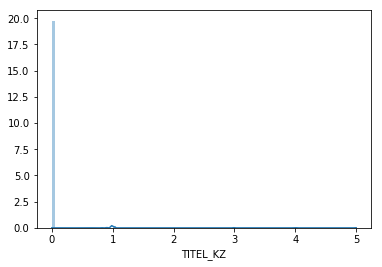

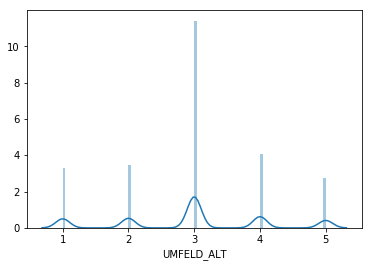

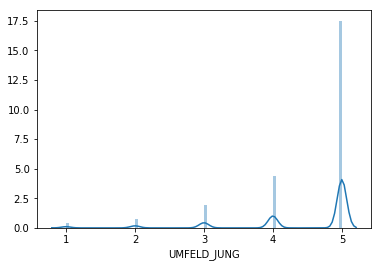

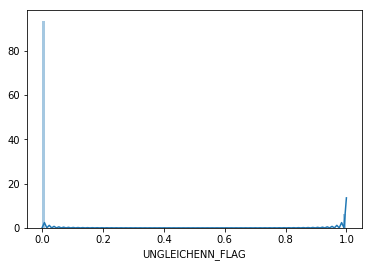

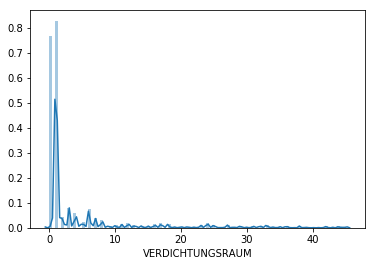

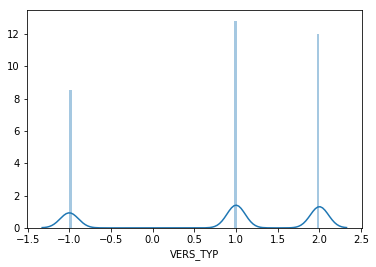

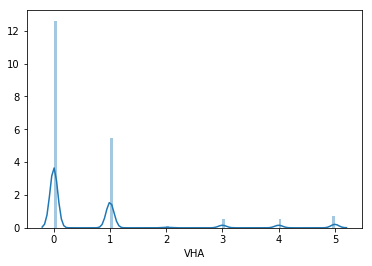

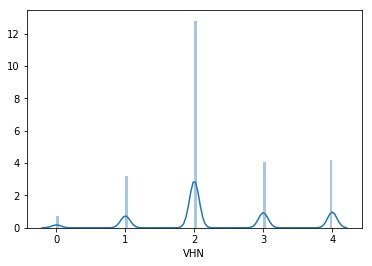

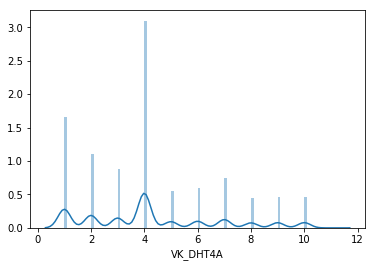

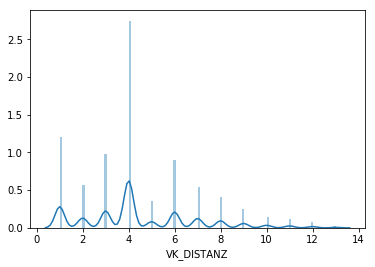

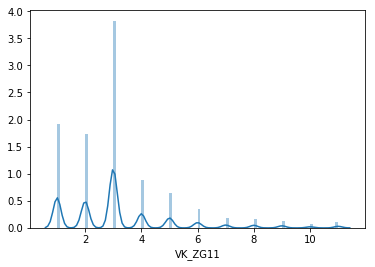

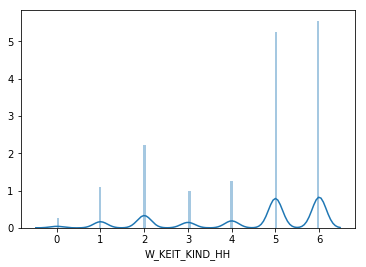

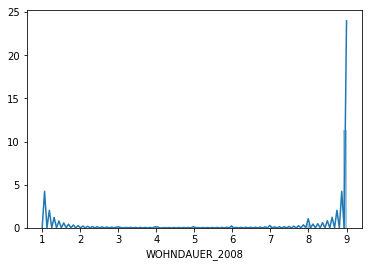

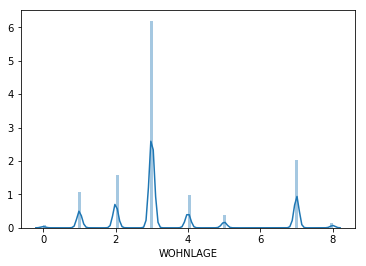

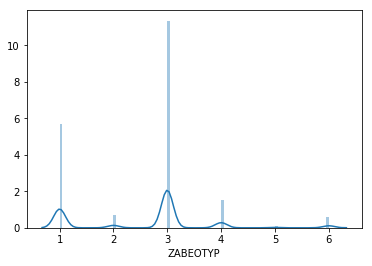

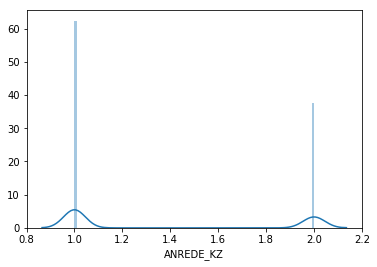

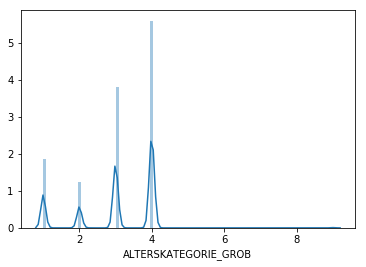

In [66]:
plt.style('seaborn')
for name in clean_customers_fillna.columns:

    plt.hist(clean_customers_fillna[name])
    plt.show()

In [ ]:
n_bins = 30

for name in clean_customers_dropna.columns:

    plt.title(name)
    plt.hist(clean_customers_dropna[name].values, bins=n_bins)
    plt.show()

In [64]:
clean_customers_dropna.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
6        2.0         1.0      10.0                  10.0                  1.0   
7        1.0         1.0      10.0                   9.0                  1.0   
11       1.0         1.0      10.0                  10.0                  1.0   
14       2.0         1.0       6.0                   6.0                  9.0   
15       2.0         5.0      17.0                  12.0                  1.0   

    ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
6            0.0         0.0           2.0                         1.0   
7            0.0         0.0           2.0                         1.0   
11           0.0         0.0           1.0                         1.0   
14           0.0         0.0           1.0                         9.0   
15           0.0         0.0           5.0                         1.0   

    ANZ_TITEL          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  \
6         0.0          ...           4.0       3.0         4.0      2.0   
7         0.0          ...           3.0       1.0         2.0      1.0   
11        0.0          ...           3.0       4.0         4.0      2.0   
14        0.0          ...           1.0       8.0         6.0      3.0   
15        0.0          ...           3.0       2.0         3.0      2.0   

    W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  \
6              6.0             9.0       7.0       1.0        1.0   
7              6.0             9.0       3.0       3.0        1.0   
11             6.0             3.0       4.0       1.0        1.0   
14             6.0             7.0       3.0       4.0        2.0   
15             2.0             9.0       2.0       1.0        1.0   

    ALTERSKATEGORIE_GROB  
6                    4.0  
7                    4.0  
11                   4.0  
14                   4.0  
15                   3.0  

[5 rows x 357 columns]

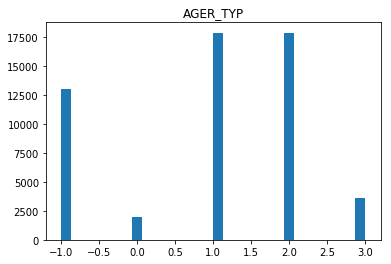

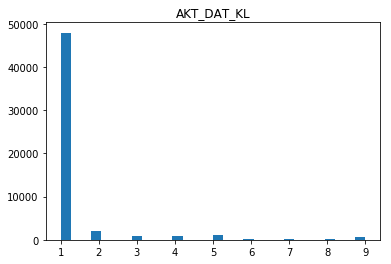

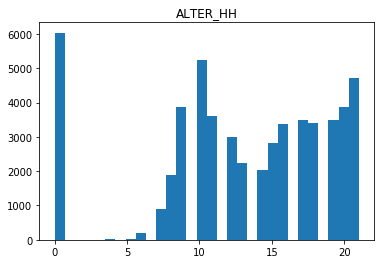

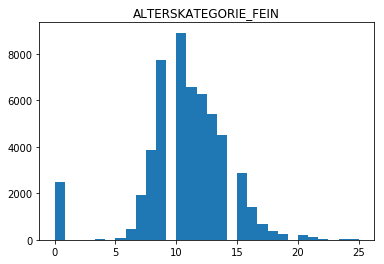

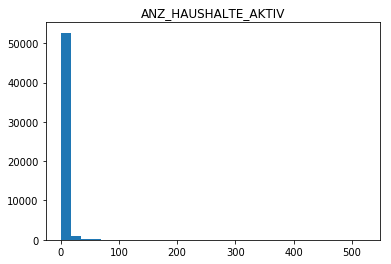

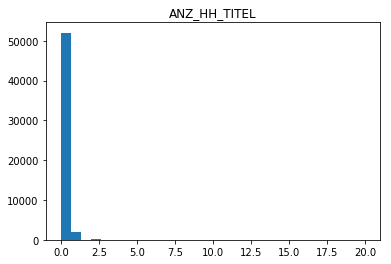

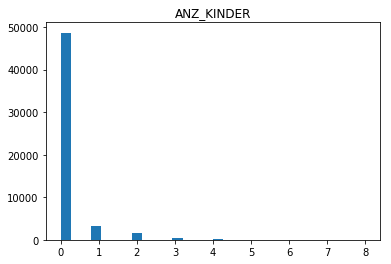

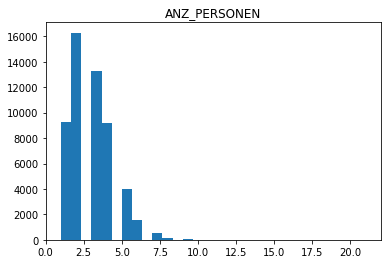

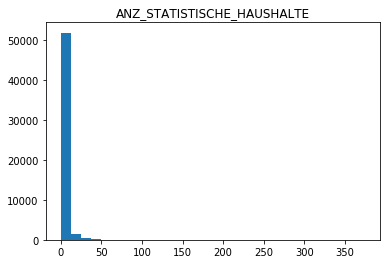

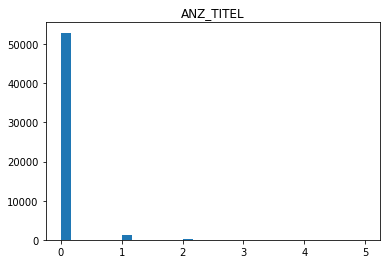

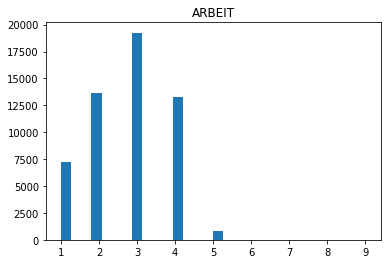

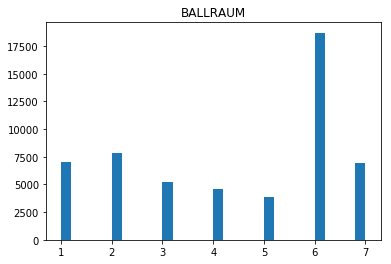

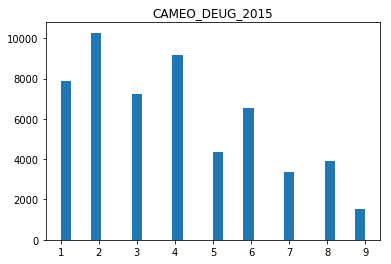

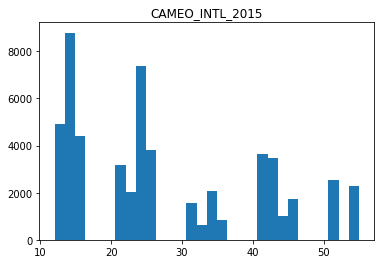

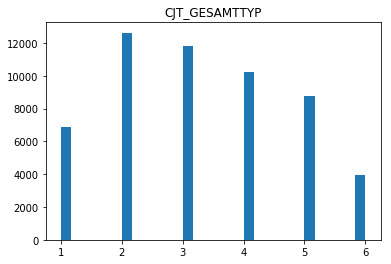

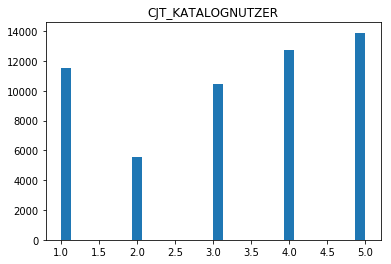

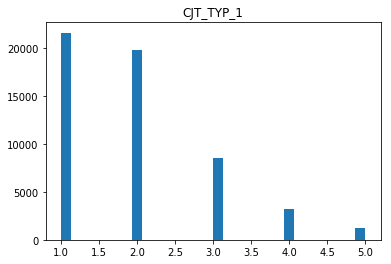

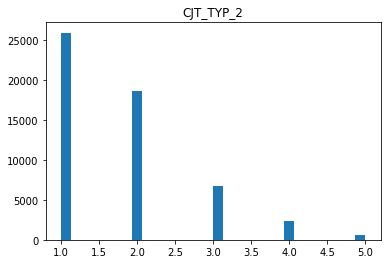

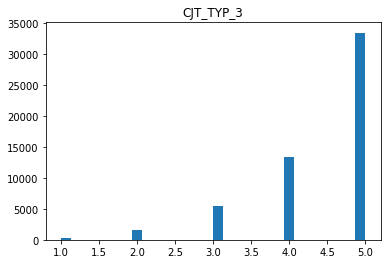

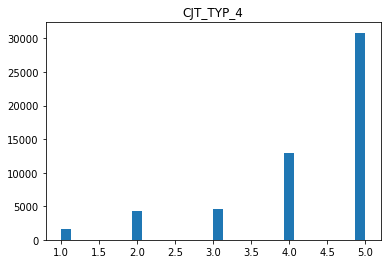

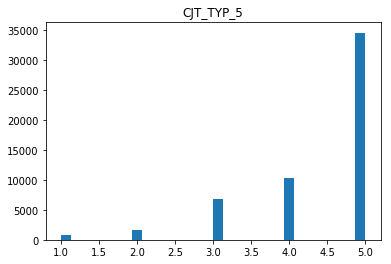

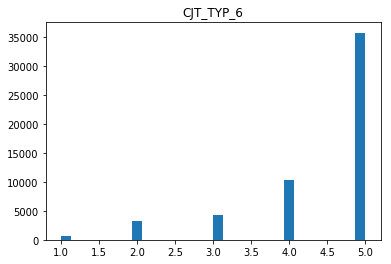

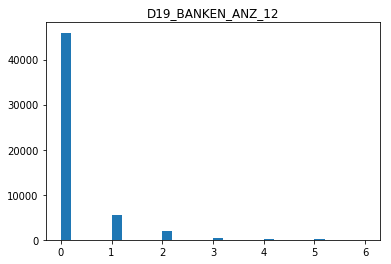

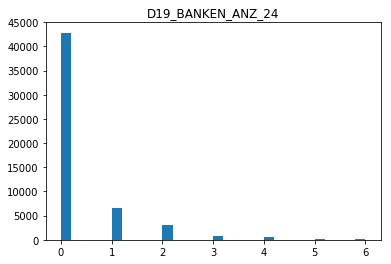

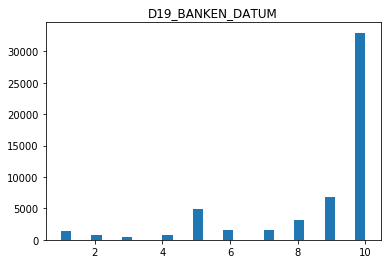

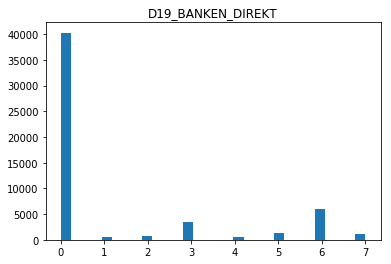

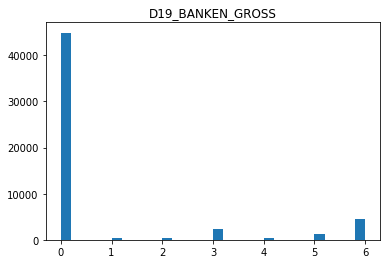

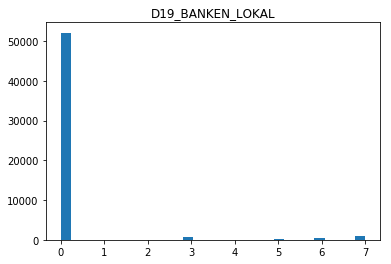

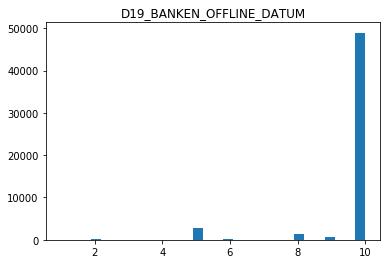

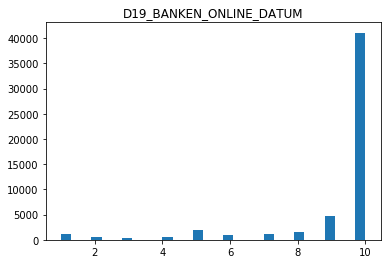

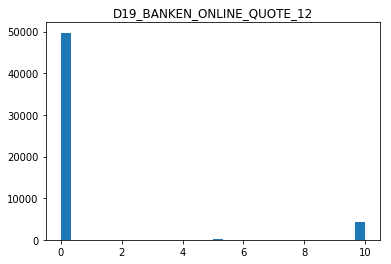

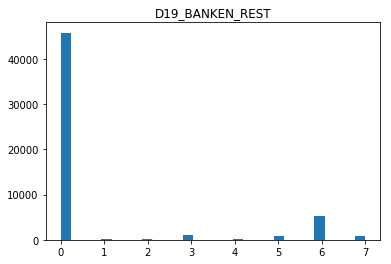

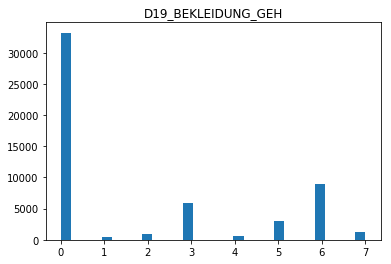

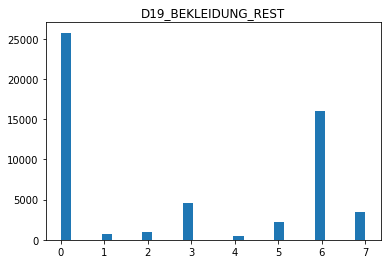

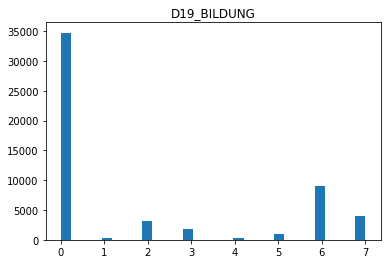

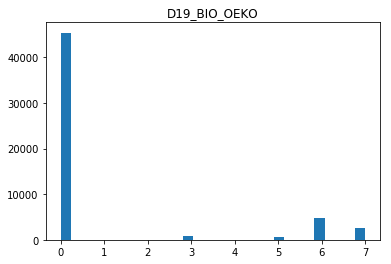

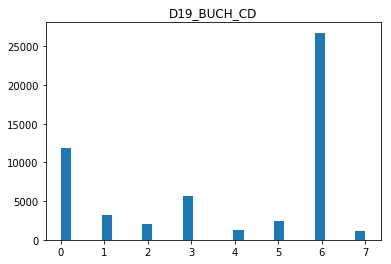

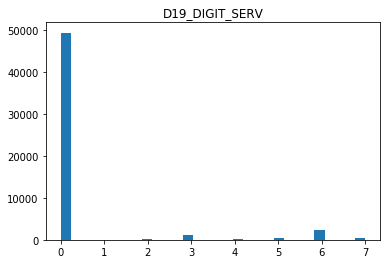

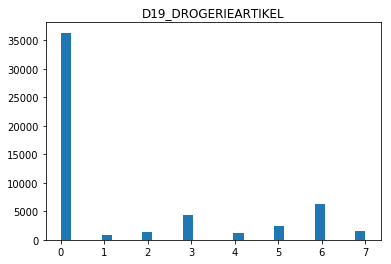

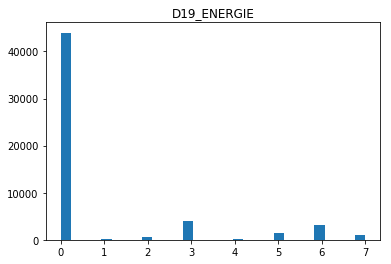

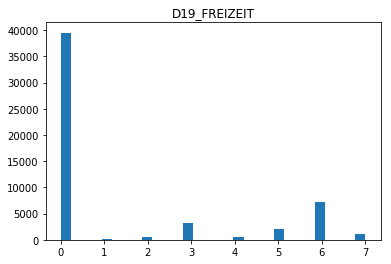

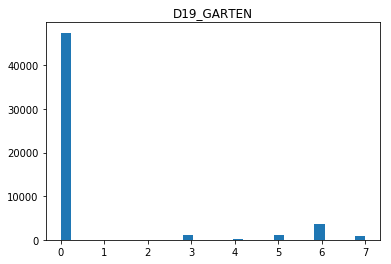

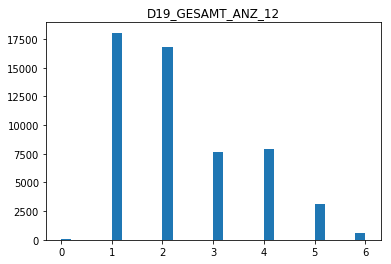

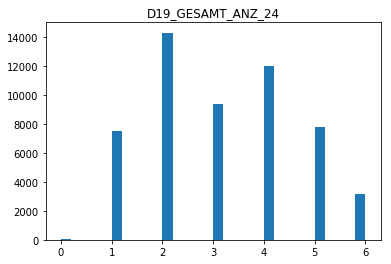

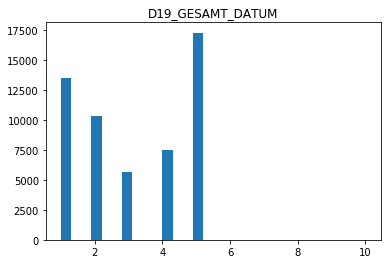

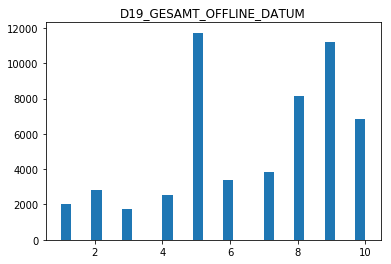

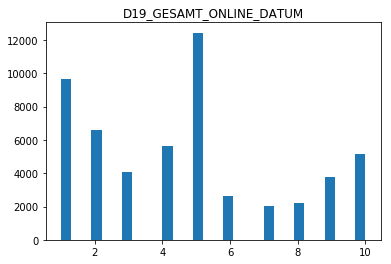

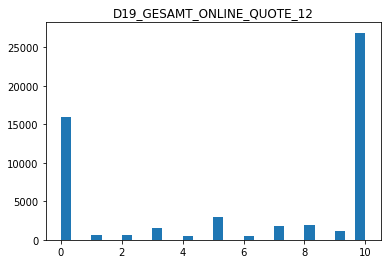

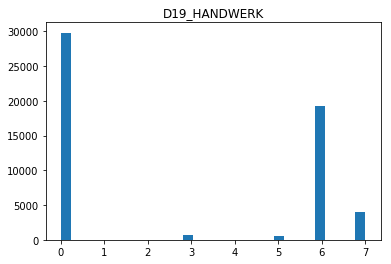

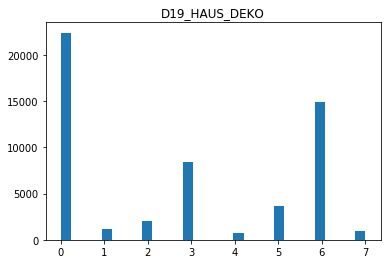

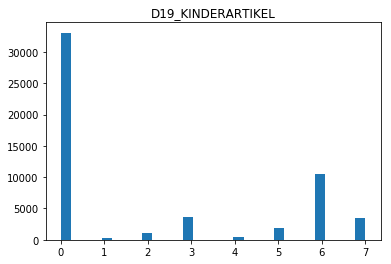

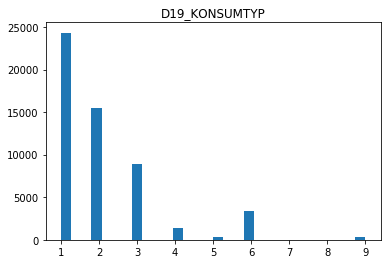

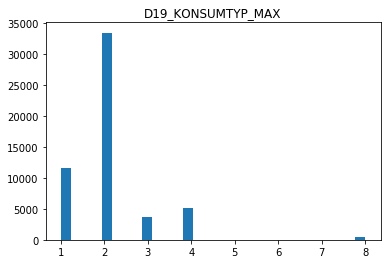

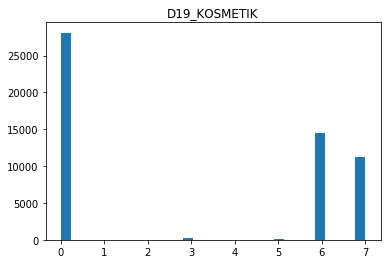

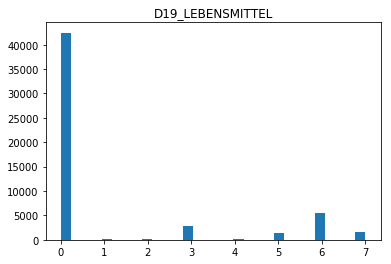

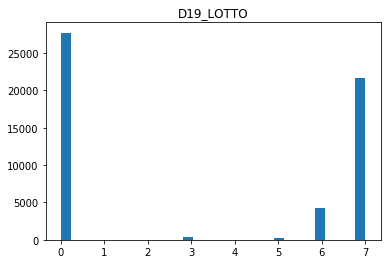

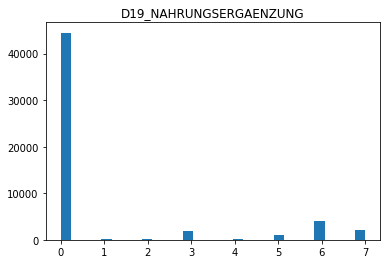

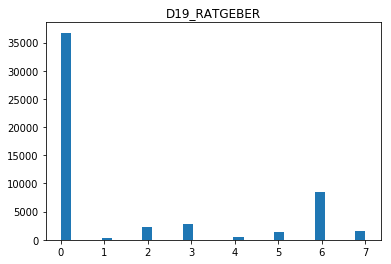

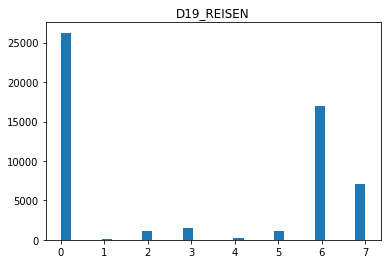

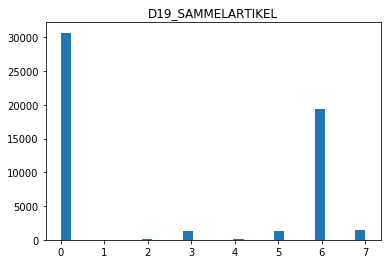

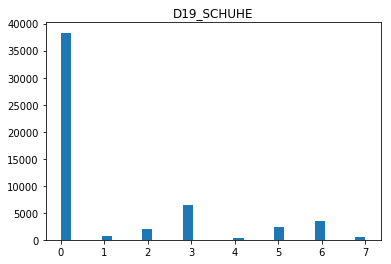

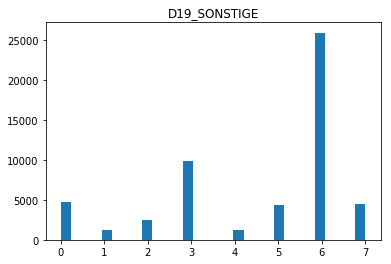

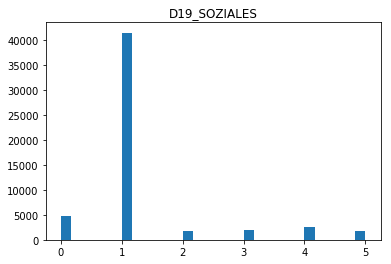

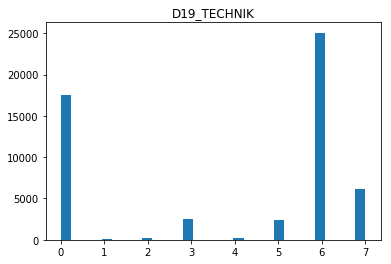

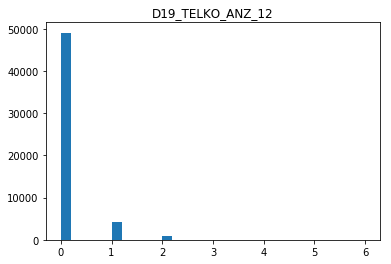

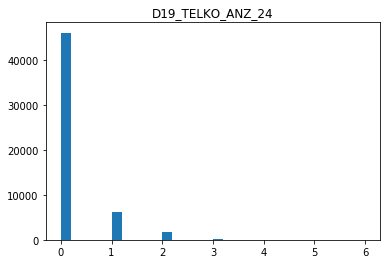

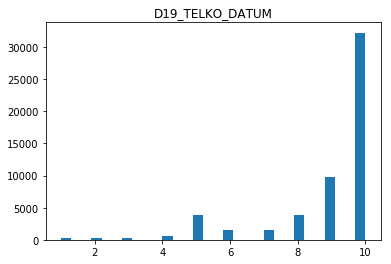

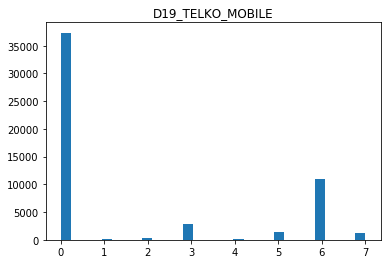

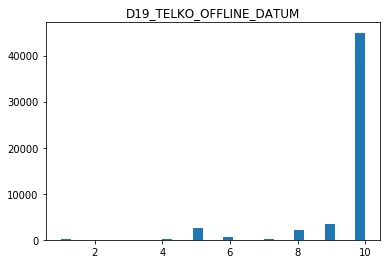

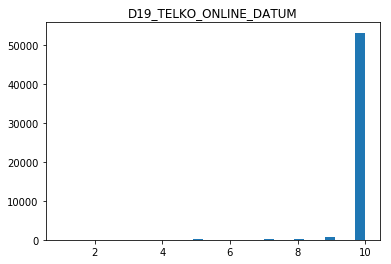

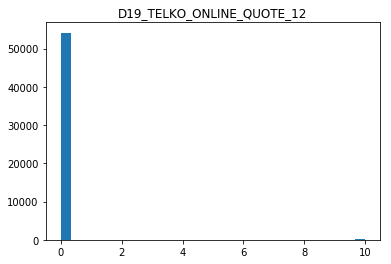

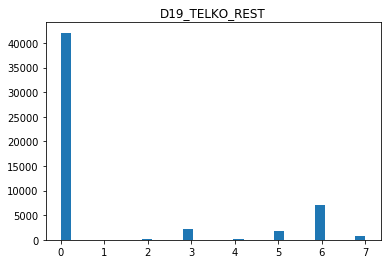

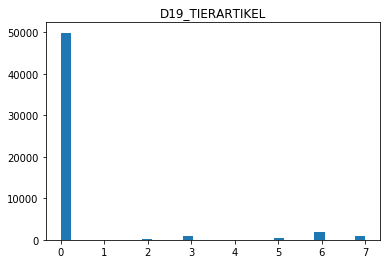

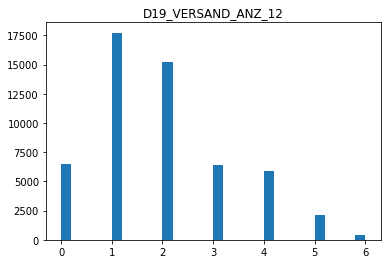

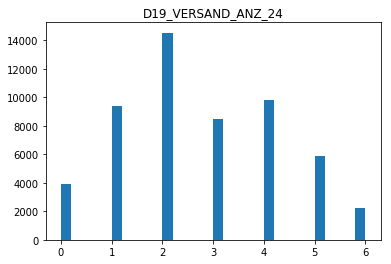

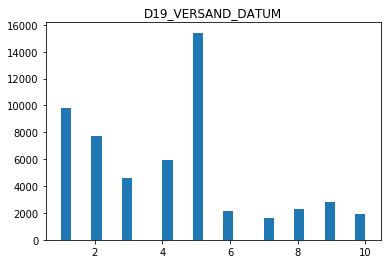

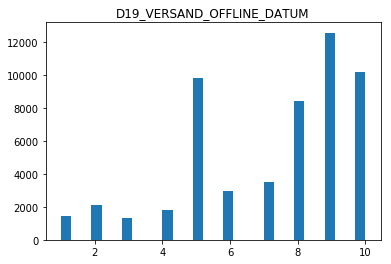

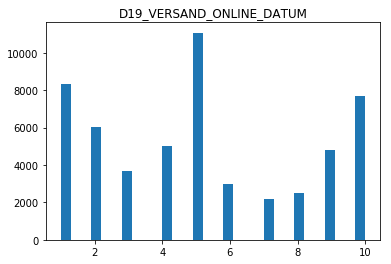

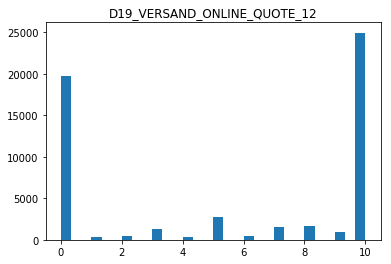

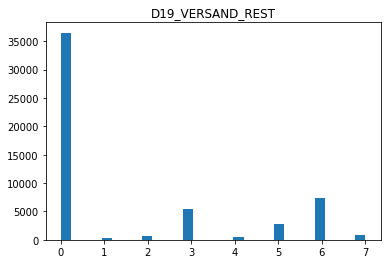

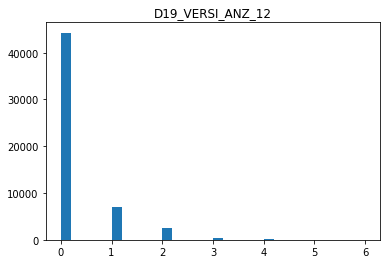

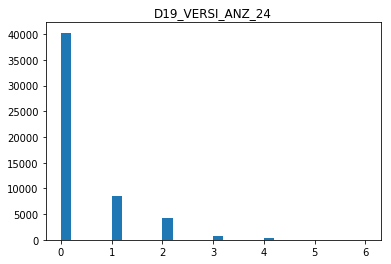

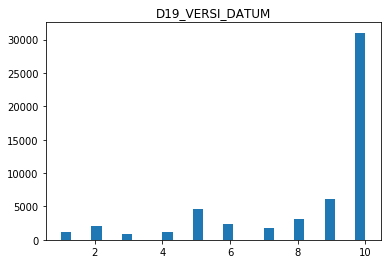

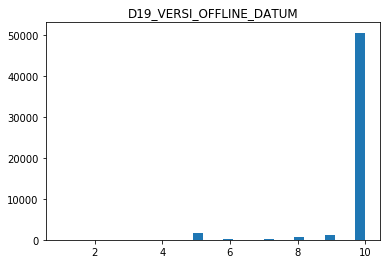

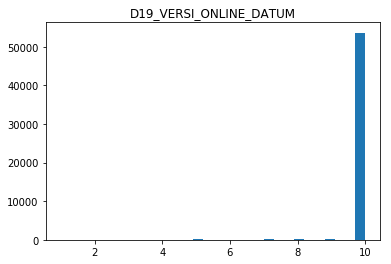

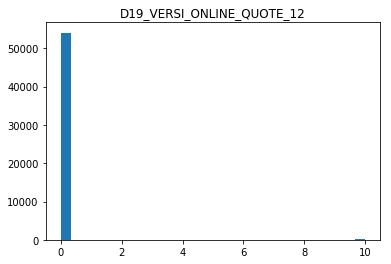

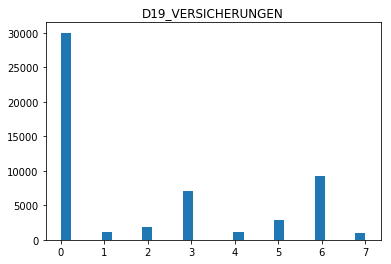

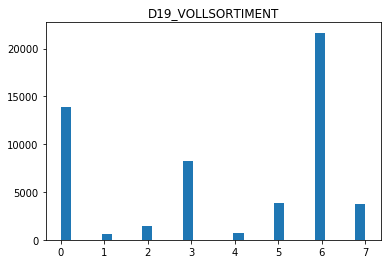

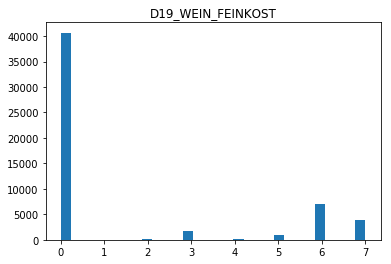

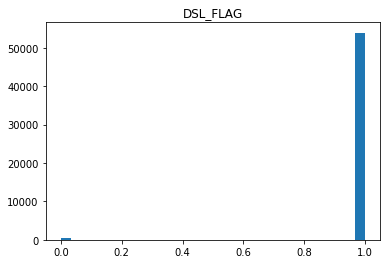

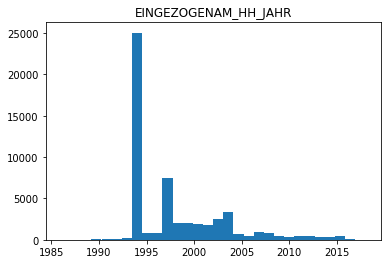

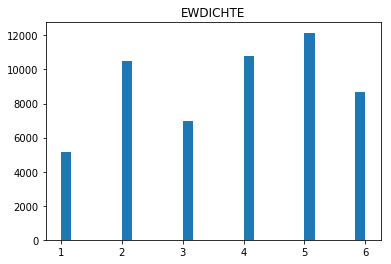

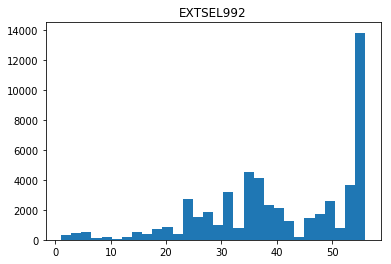

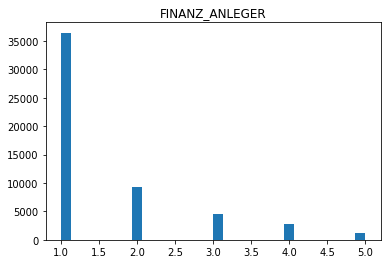

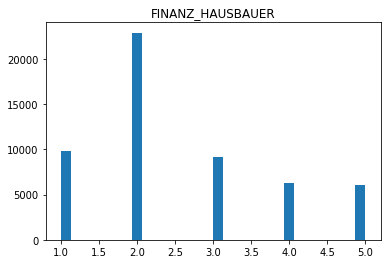

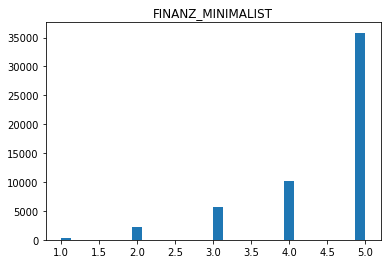

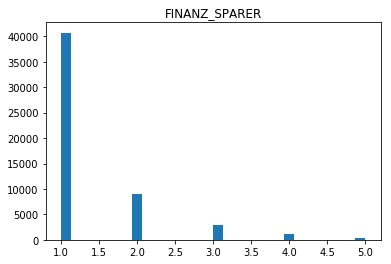

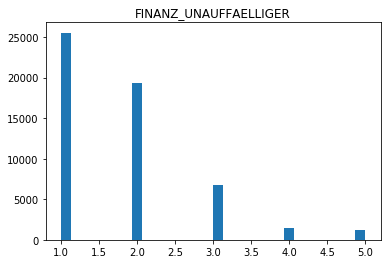

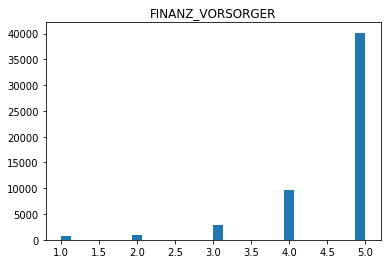

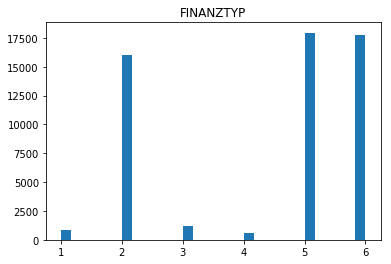

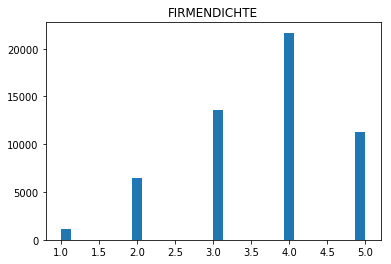

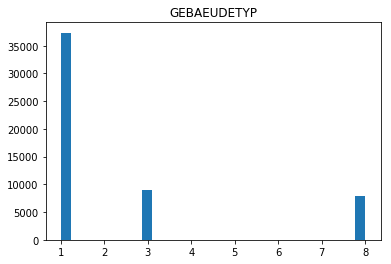

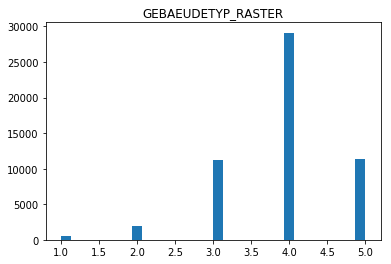

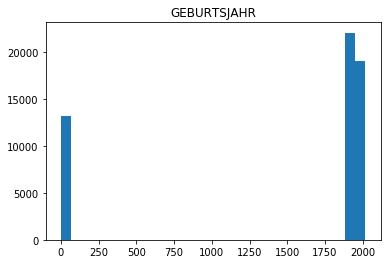

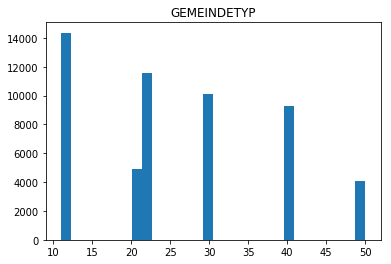

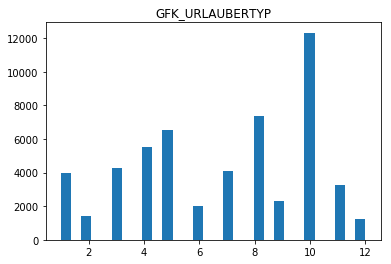

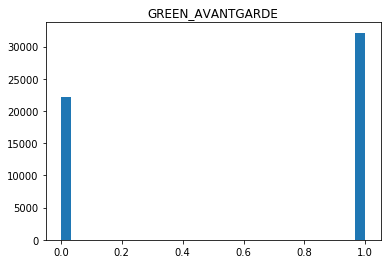

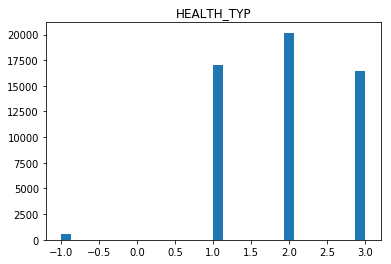

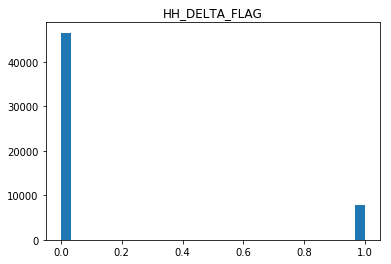

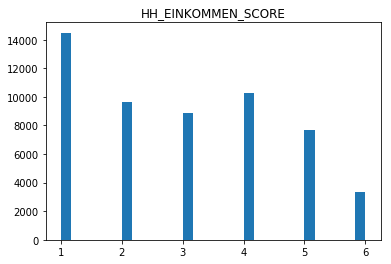

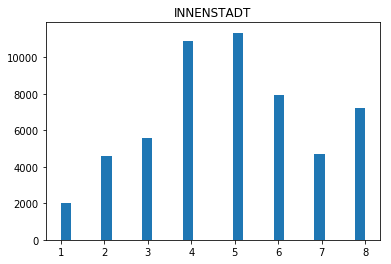

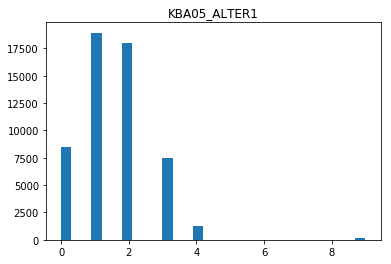

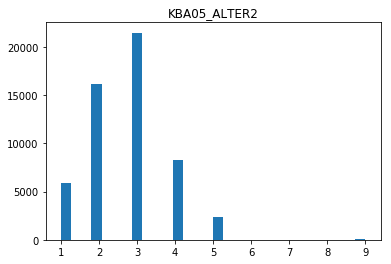

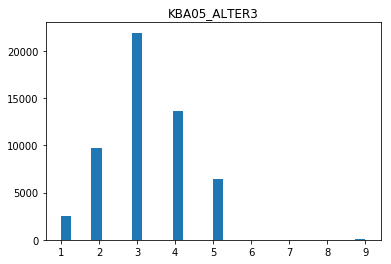

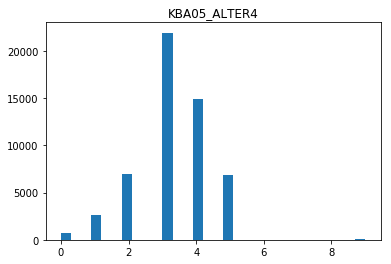

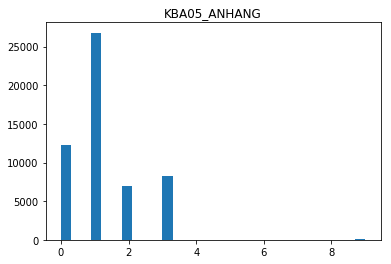

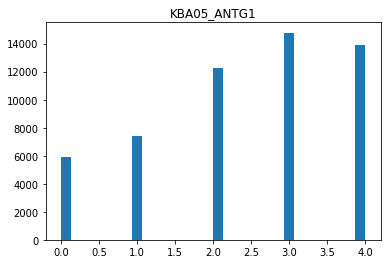

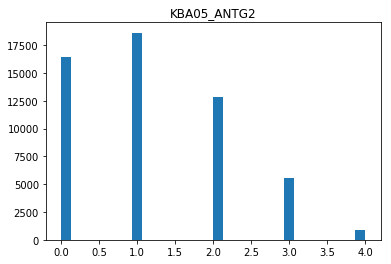

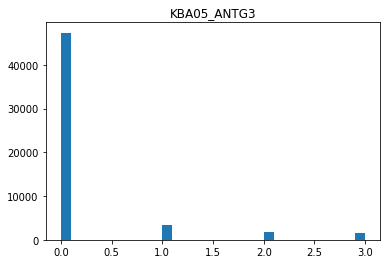

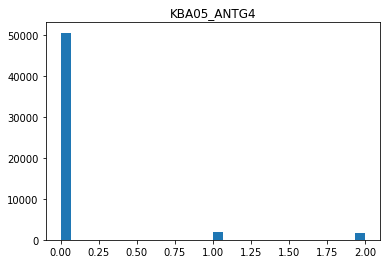

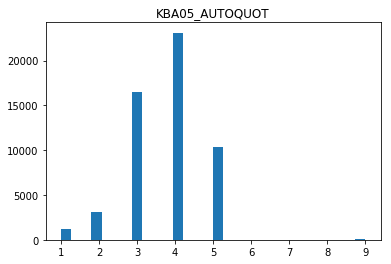

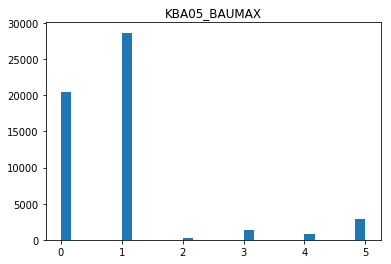

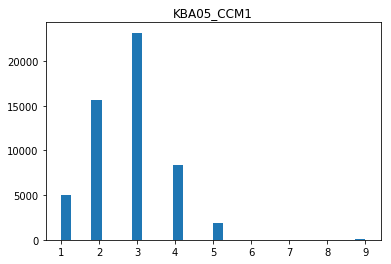

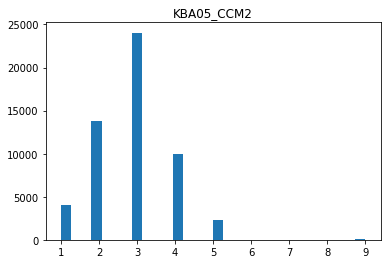

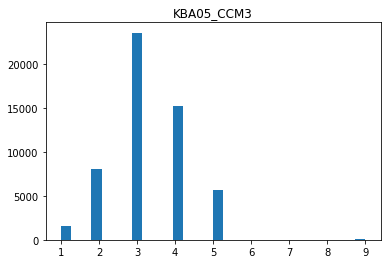

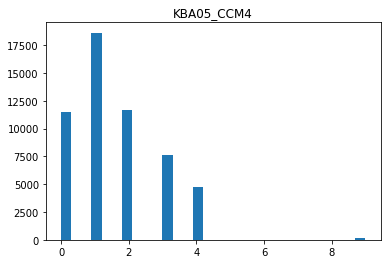

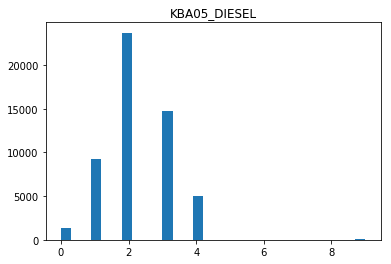

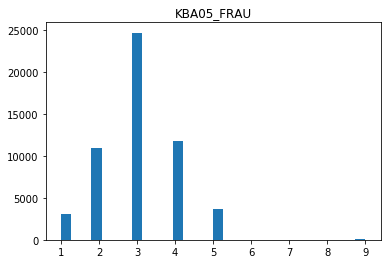

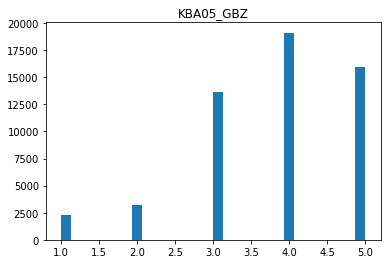

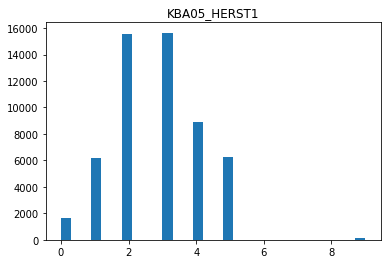

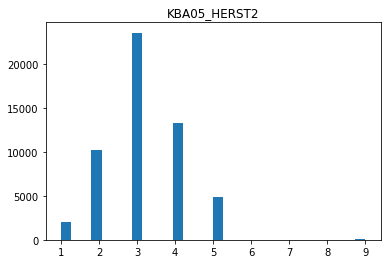

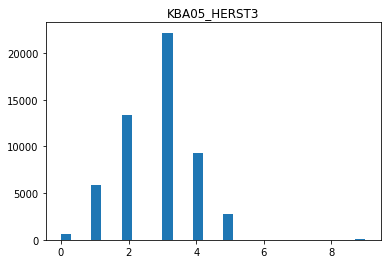

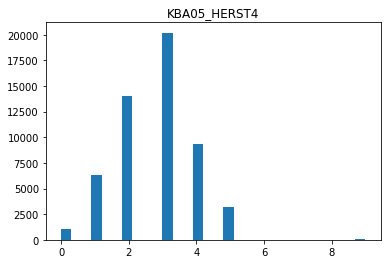

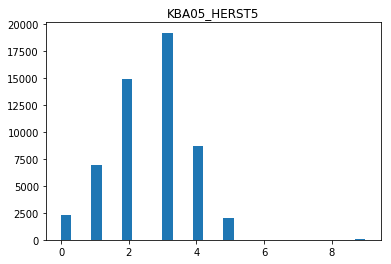

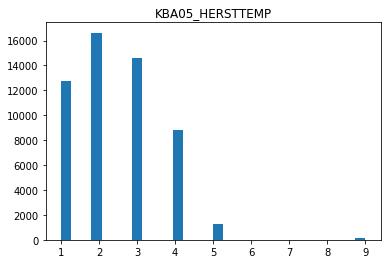

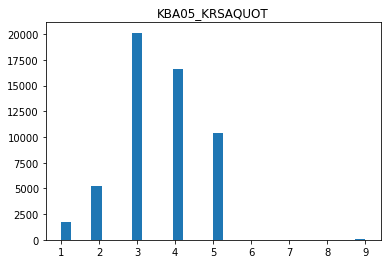

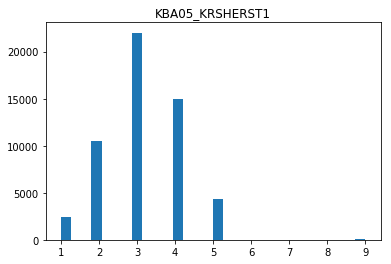

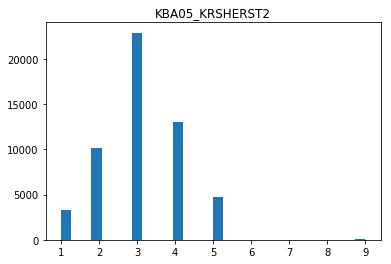

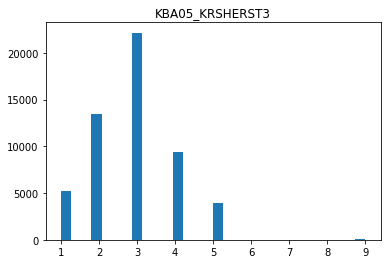

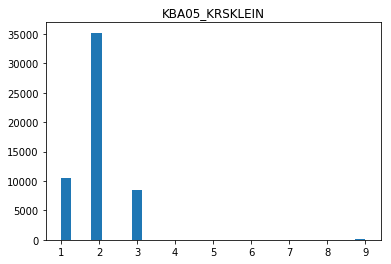

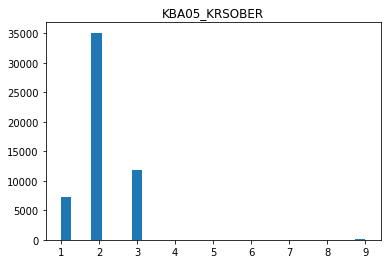

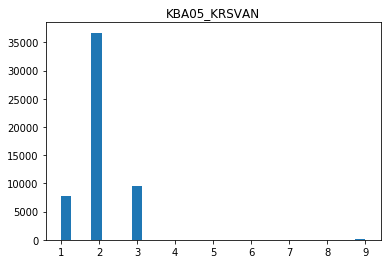

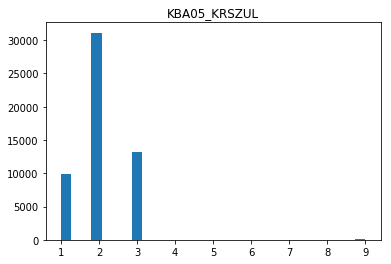

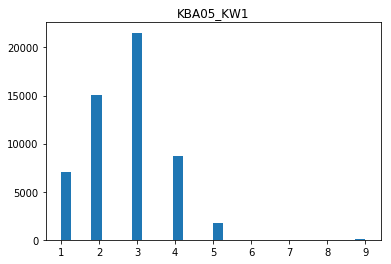

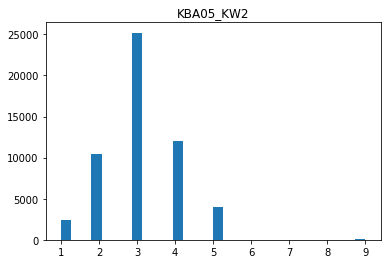

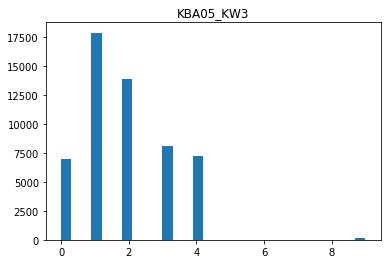

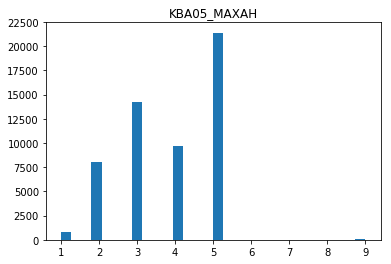

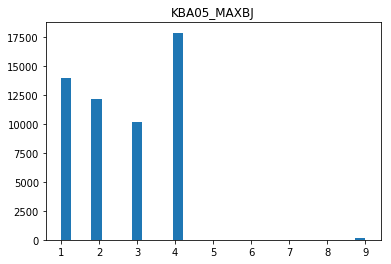

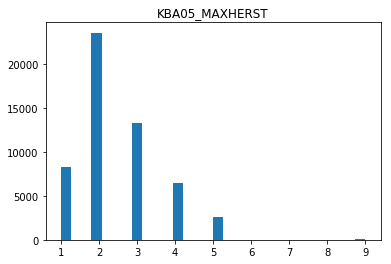

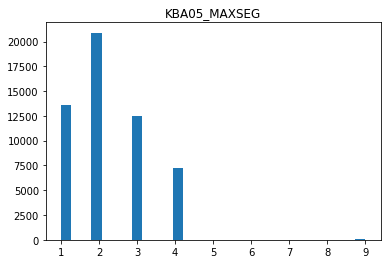

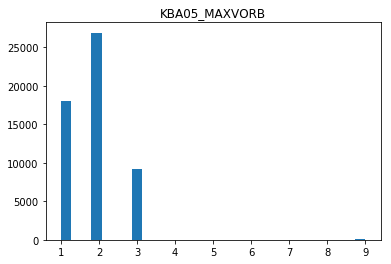

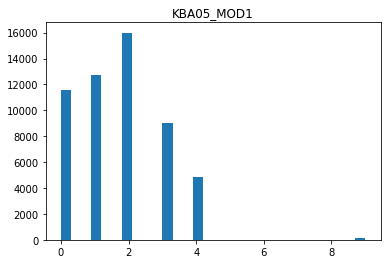

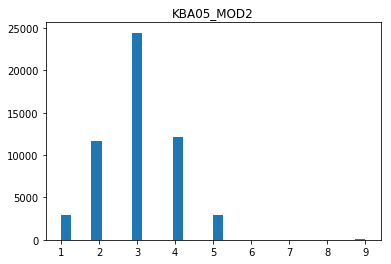

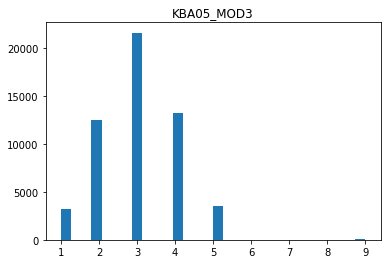

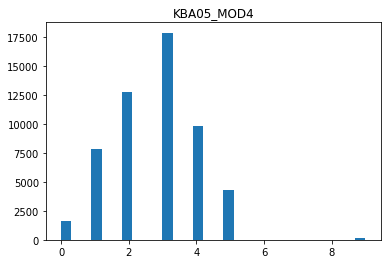

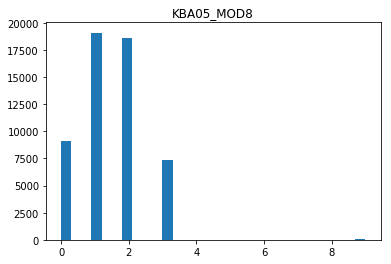

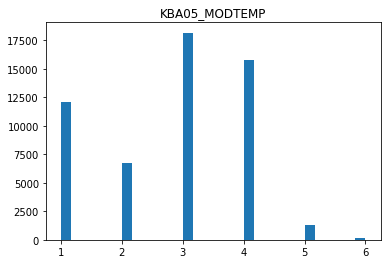

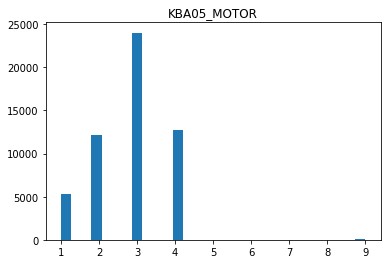

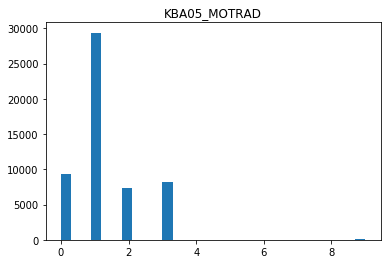

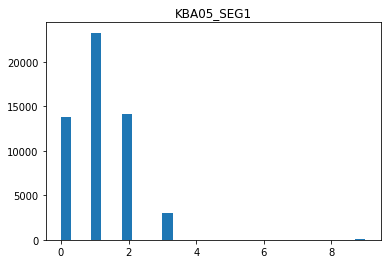

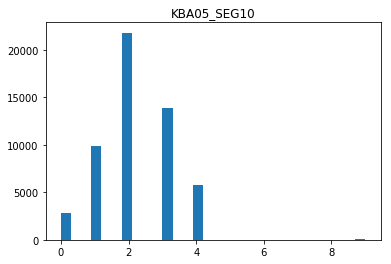

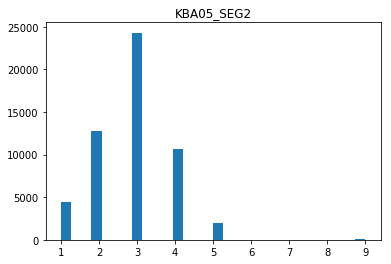

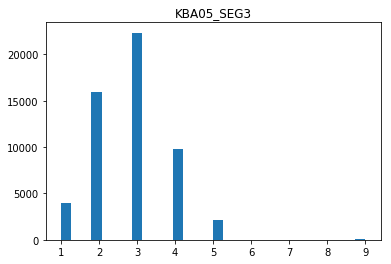

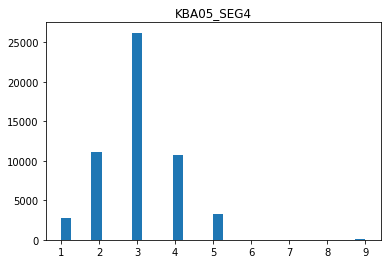

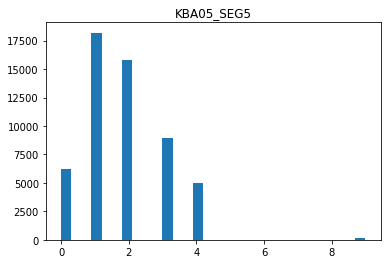

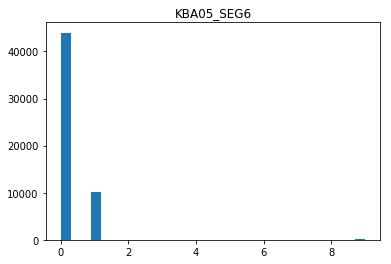

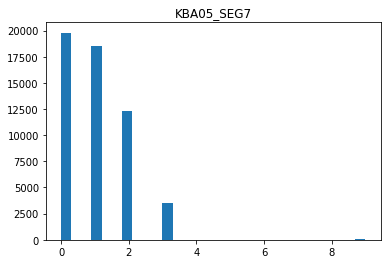

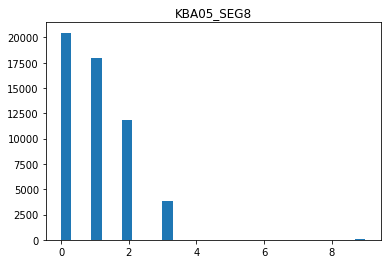

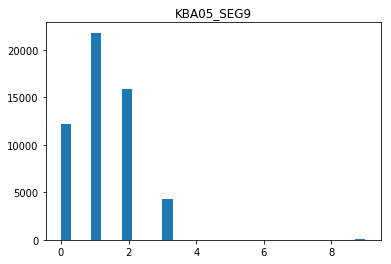

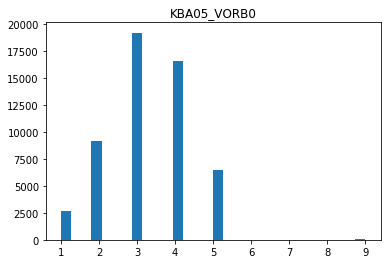

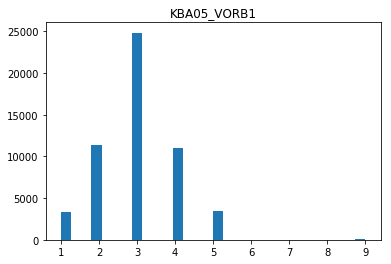

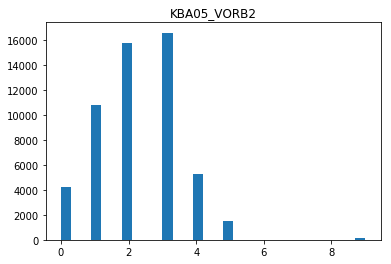

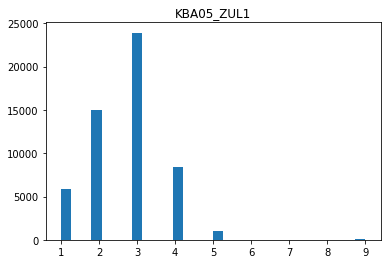

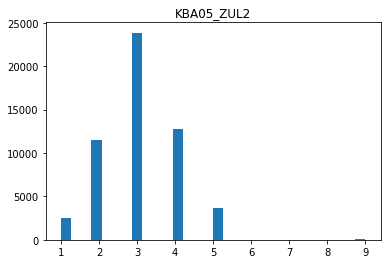

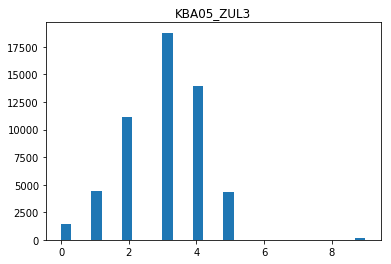

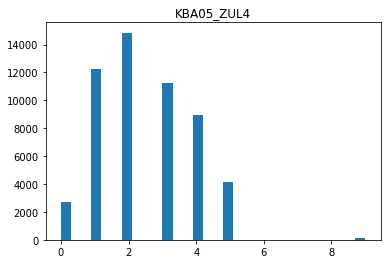

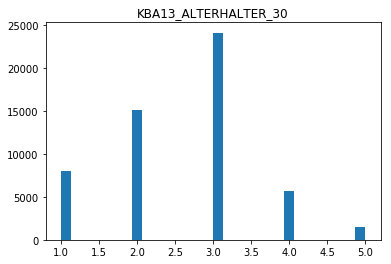

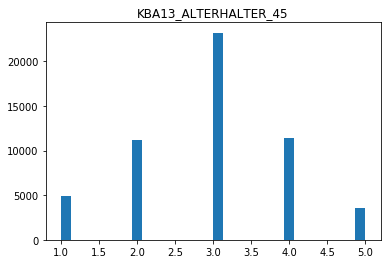

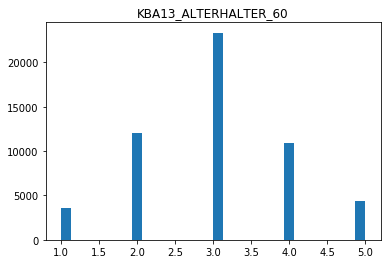

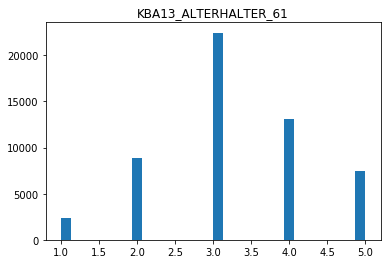

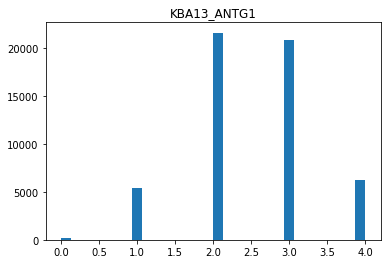

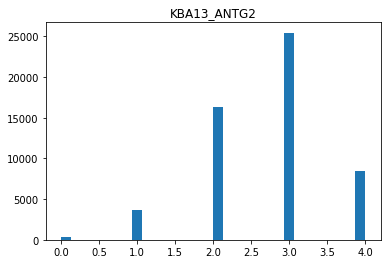

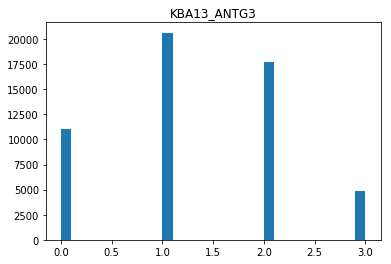

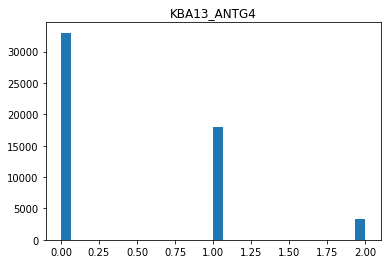

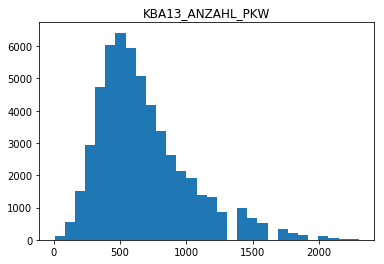

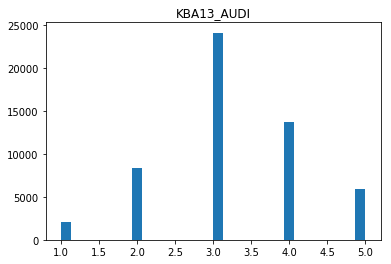

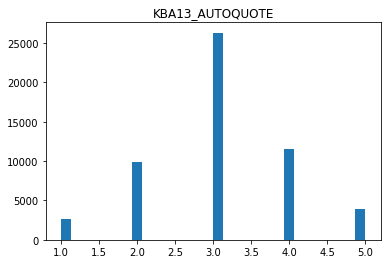

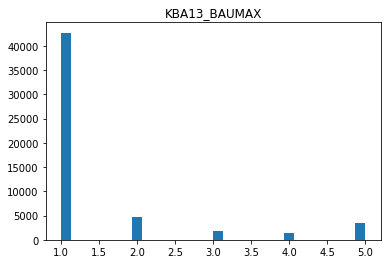

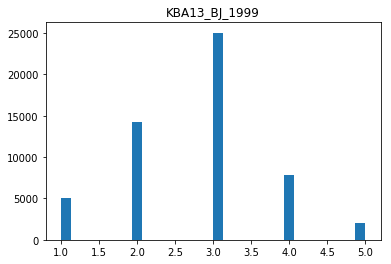

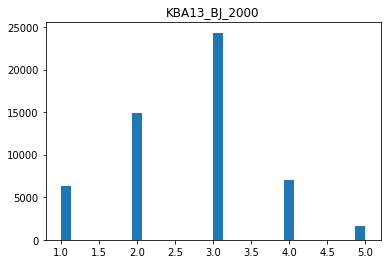

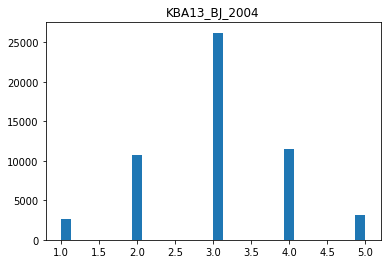

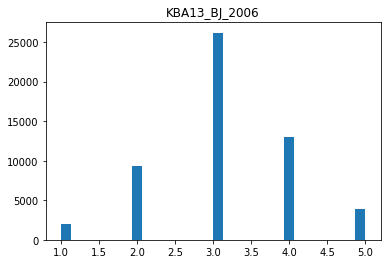

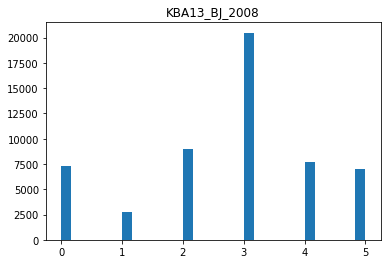

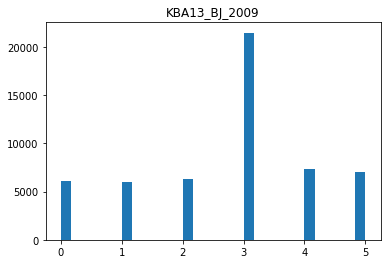

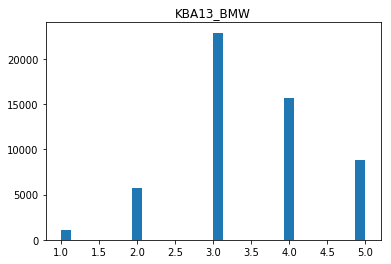

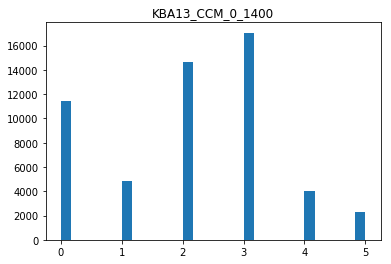

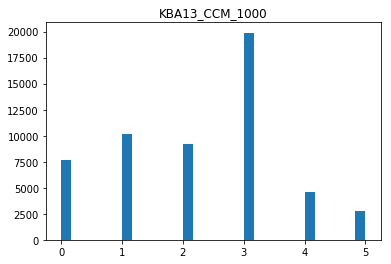

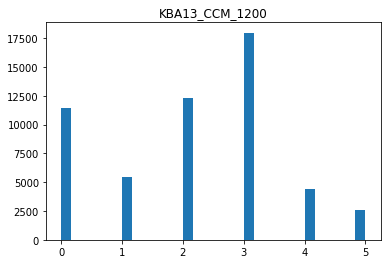

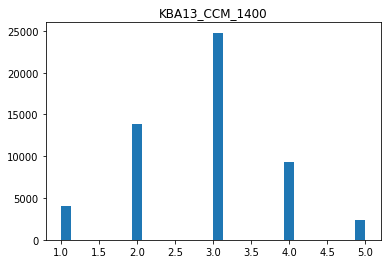

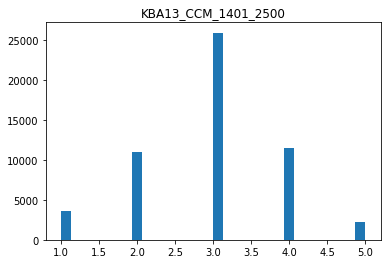

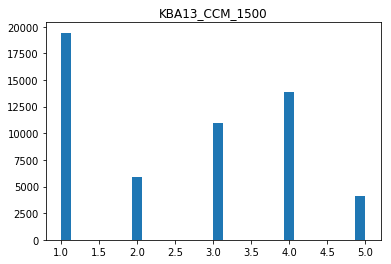

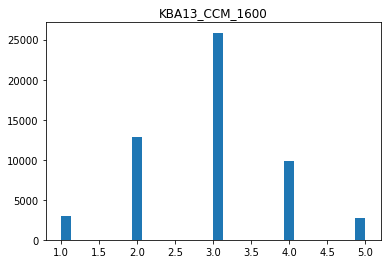

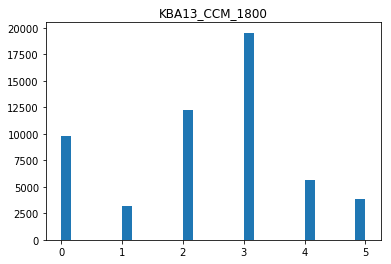

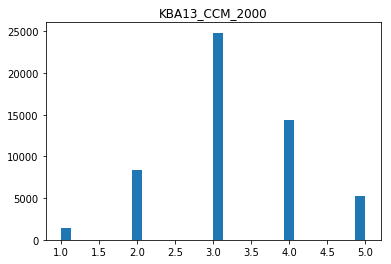

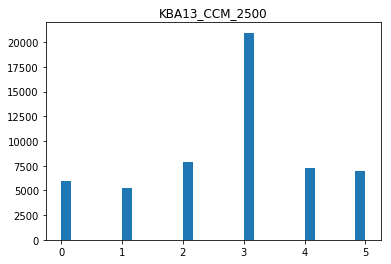

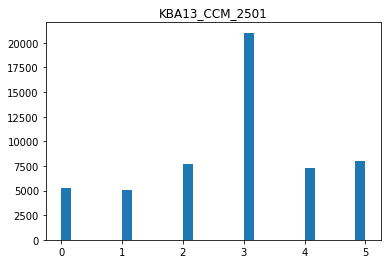

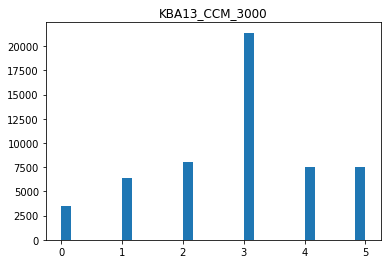

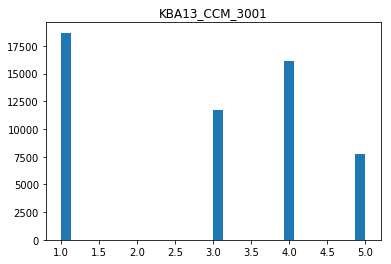

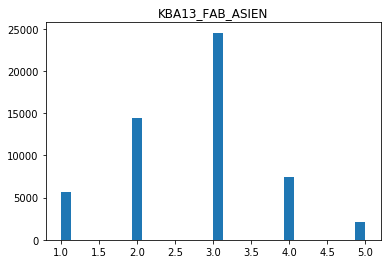

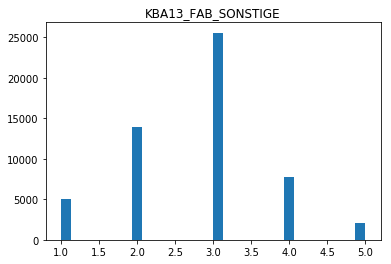

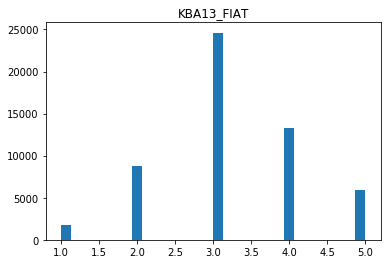

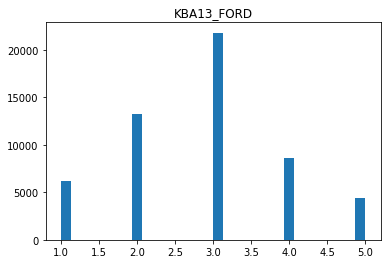

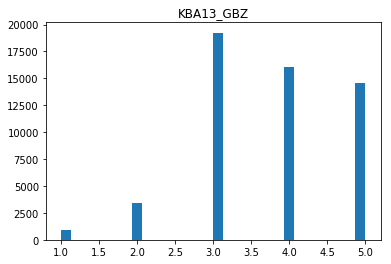

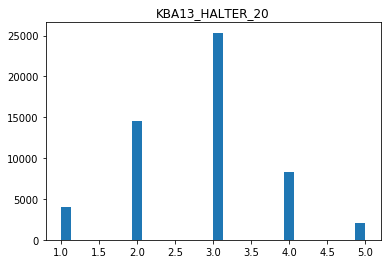

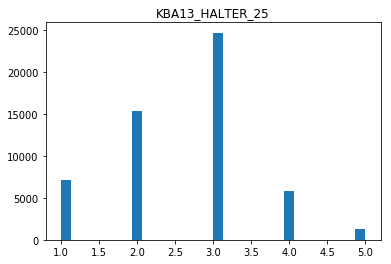

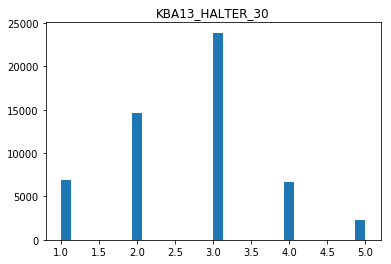

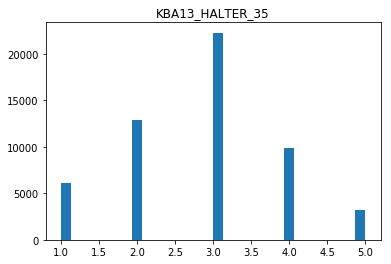

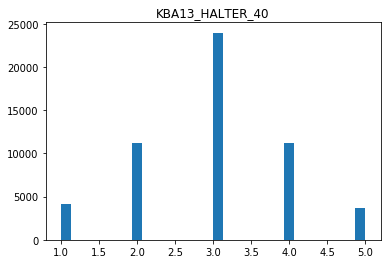

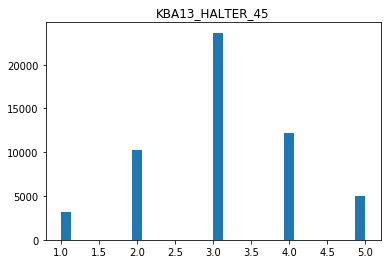

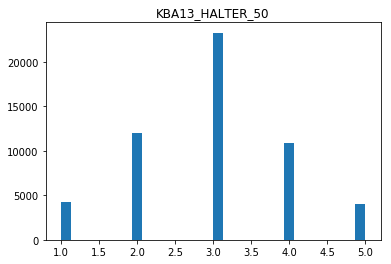

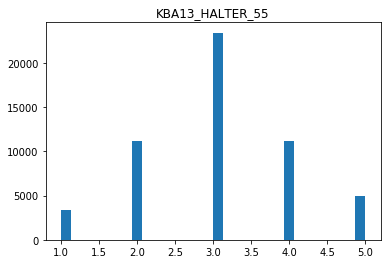

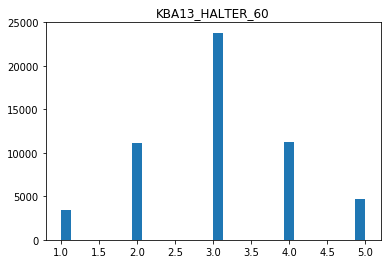

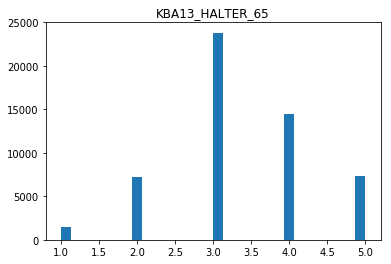

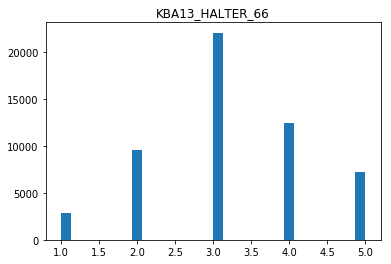

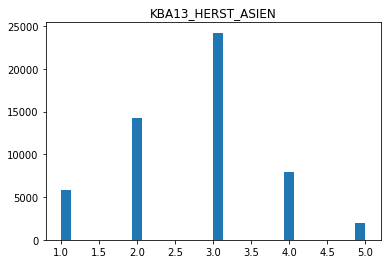

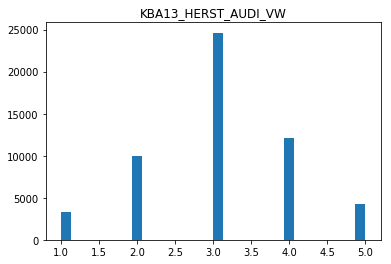

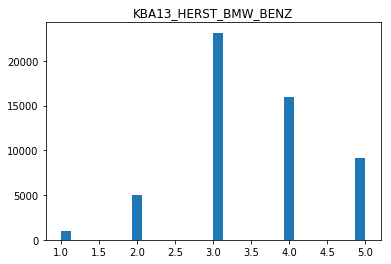

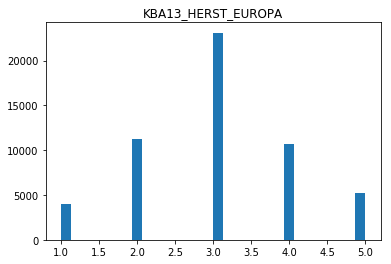

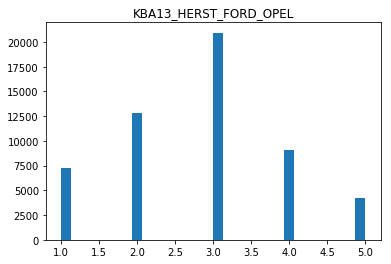

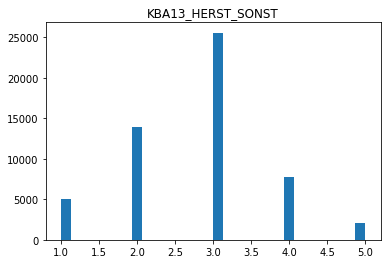

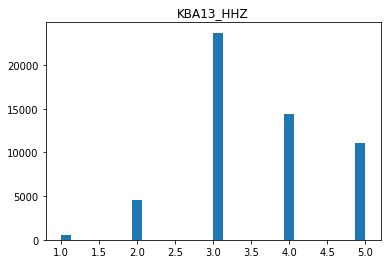

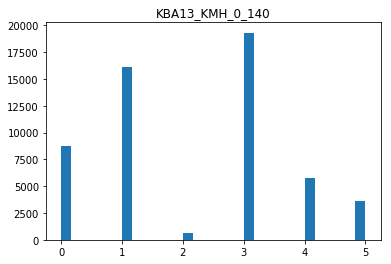

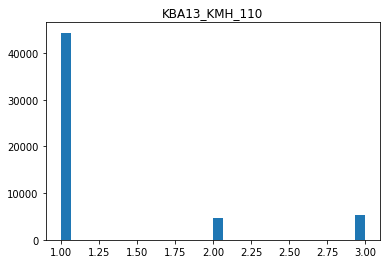

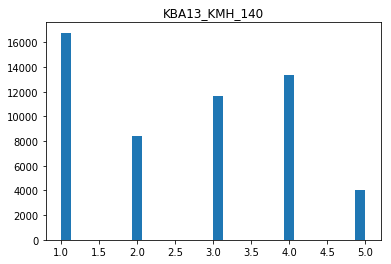

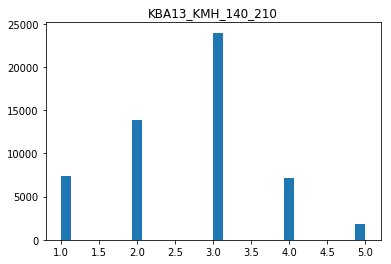

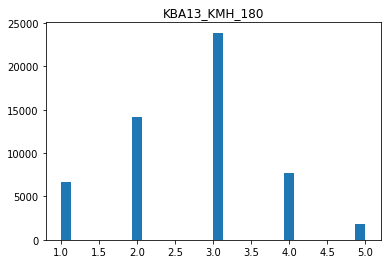

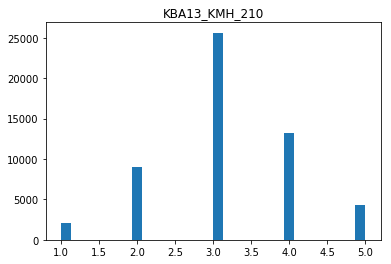

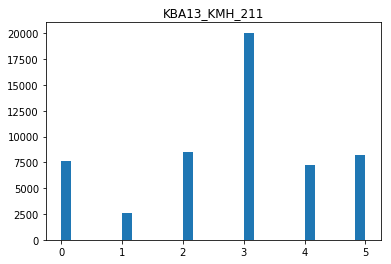

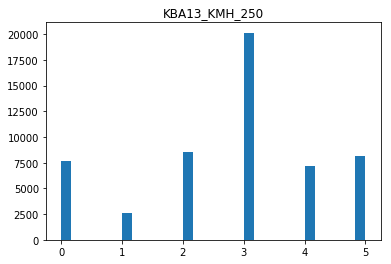

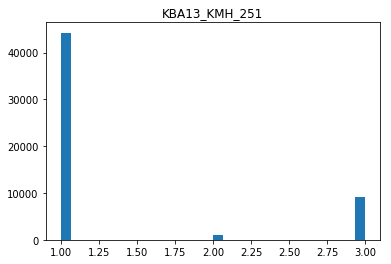

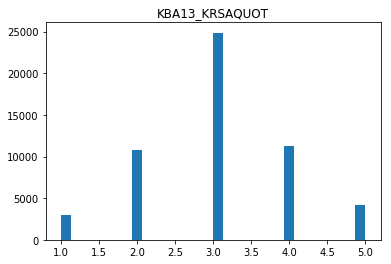

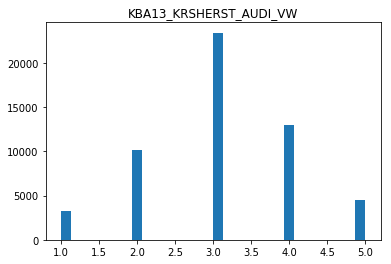

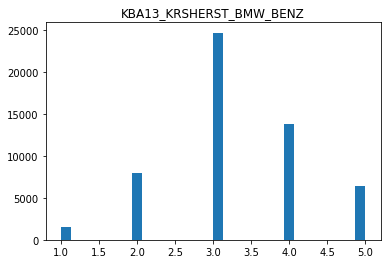

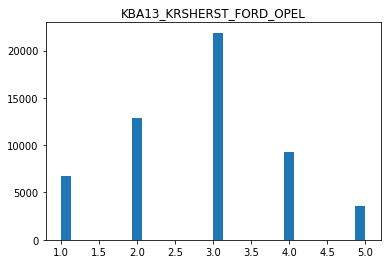

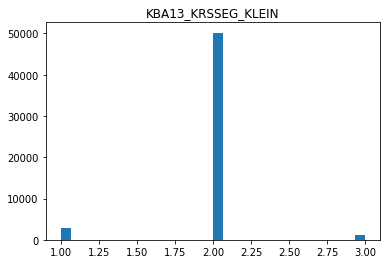

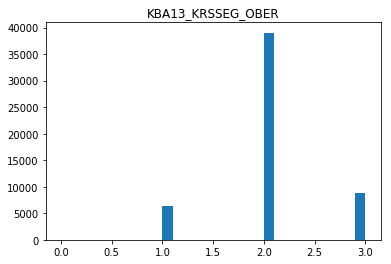

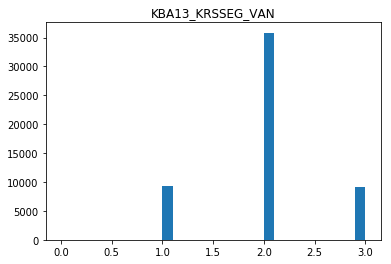

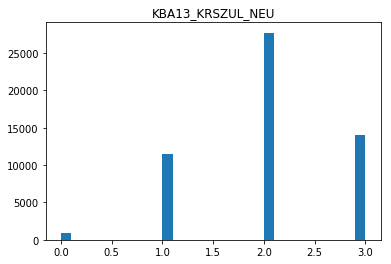

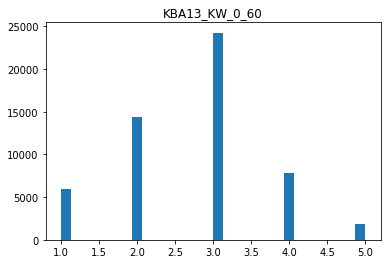

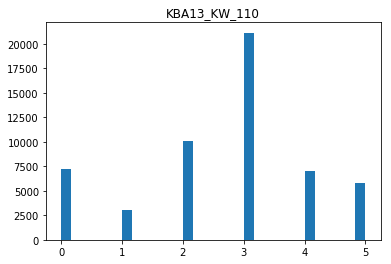

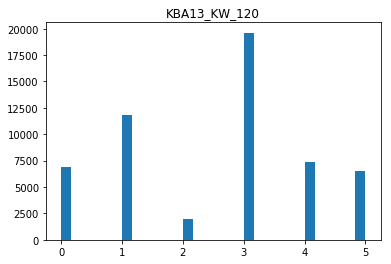

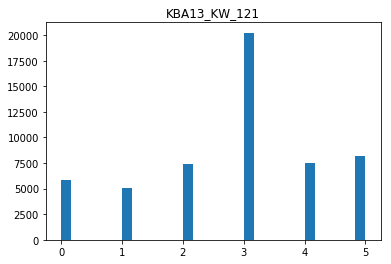

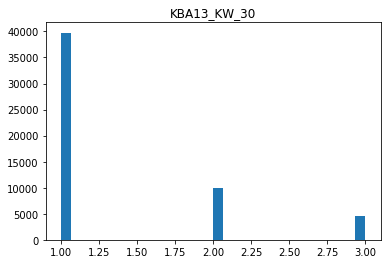

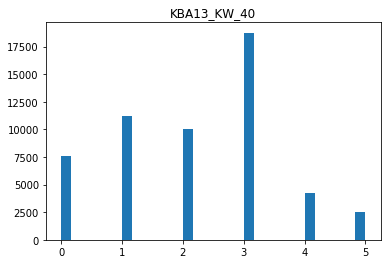

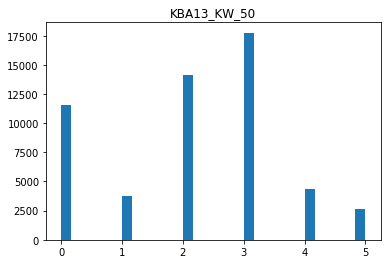

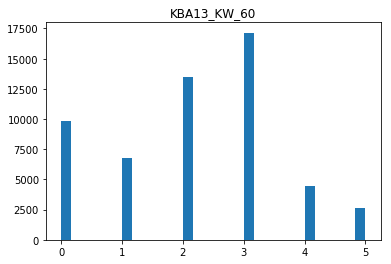

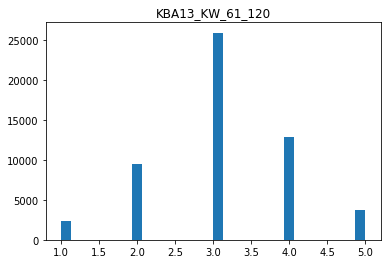

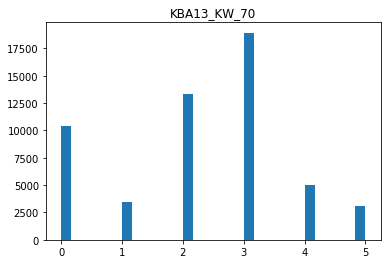

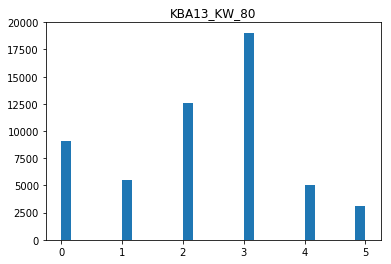

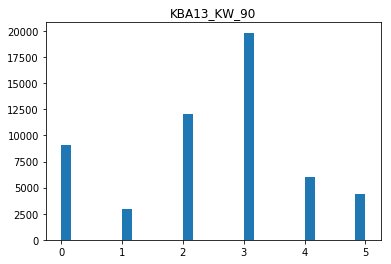

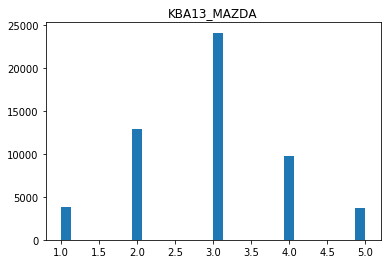

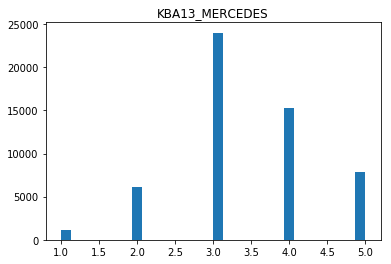

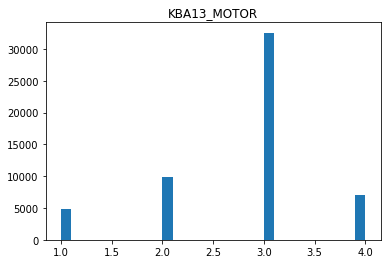

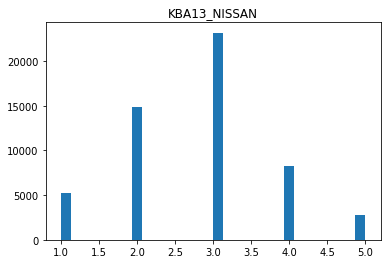

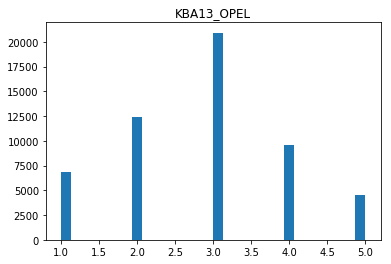

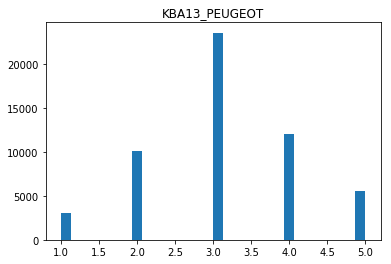

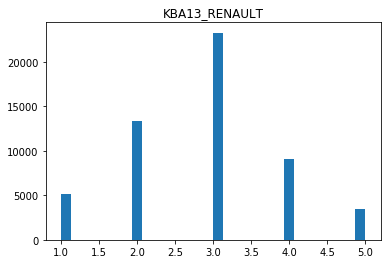

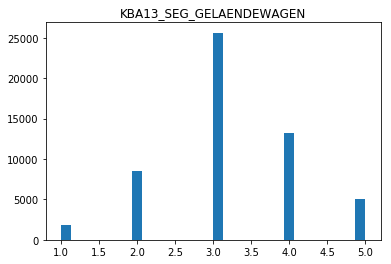

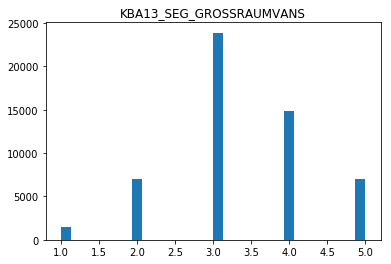

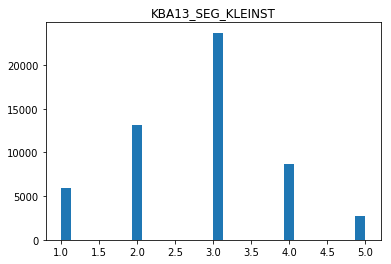

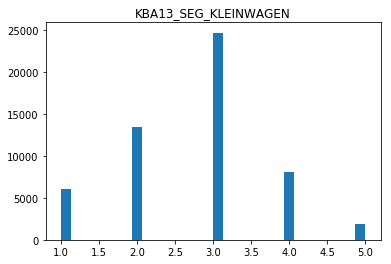

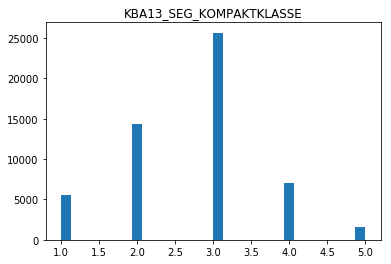

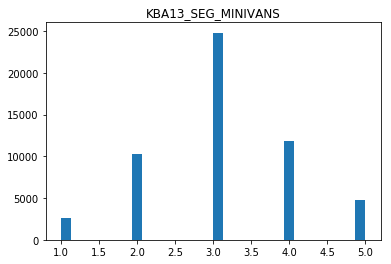

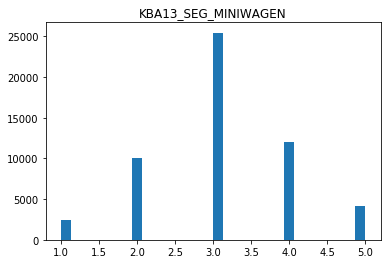

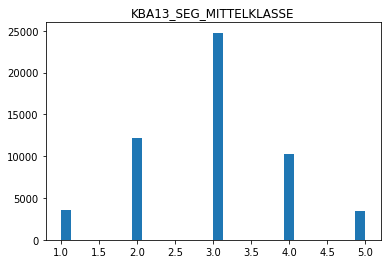

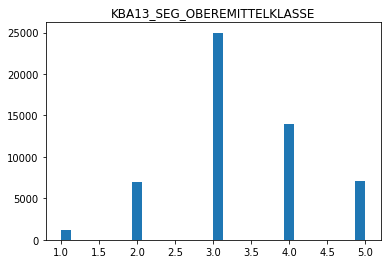

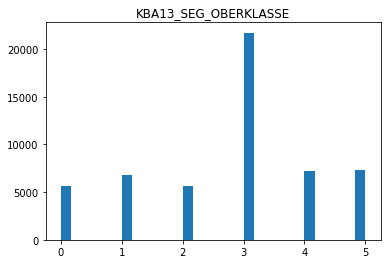

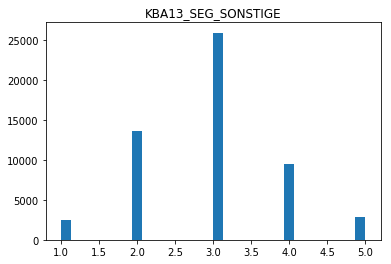

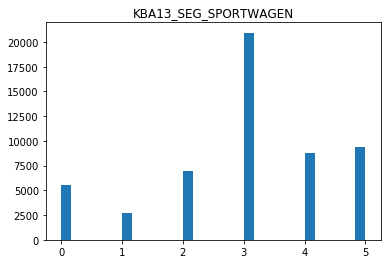

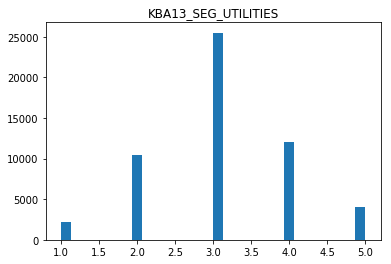

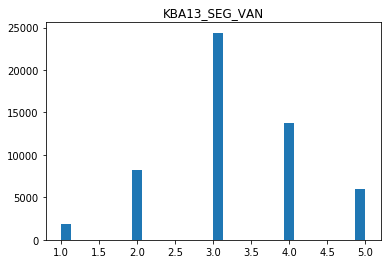

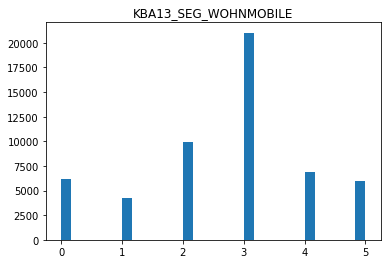

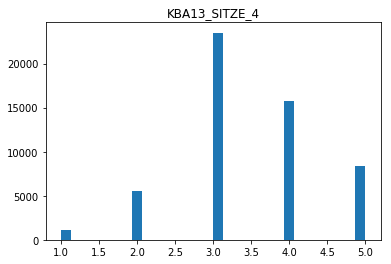

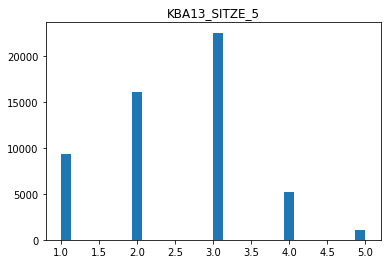

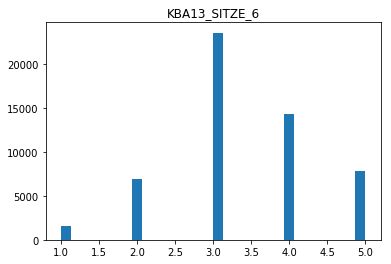

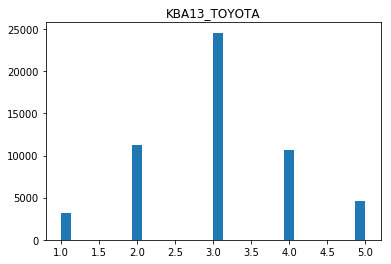

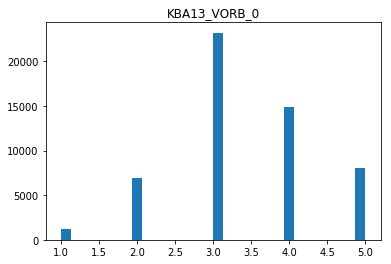

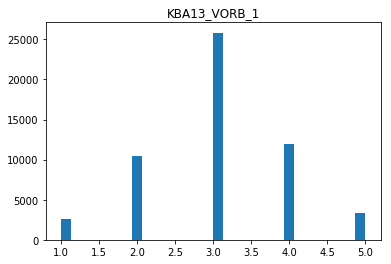

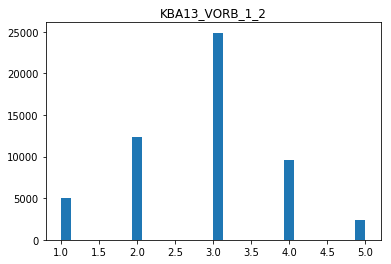

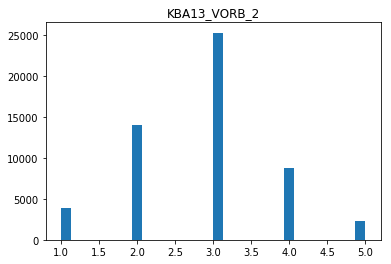

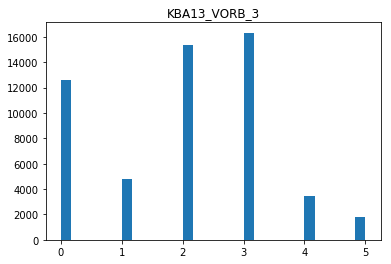

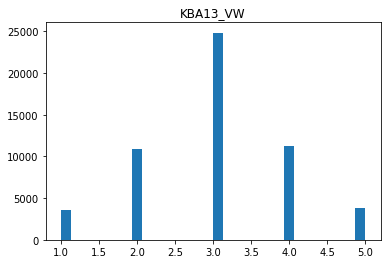

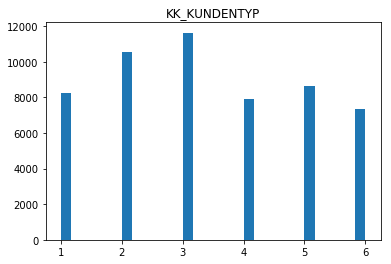

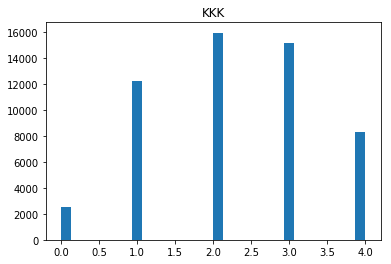

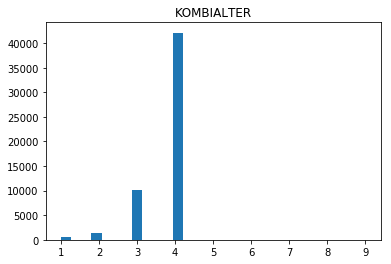

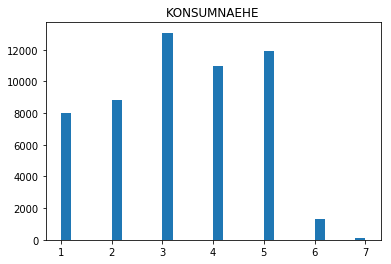

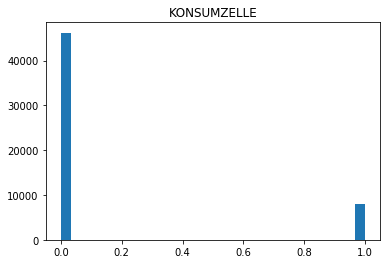

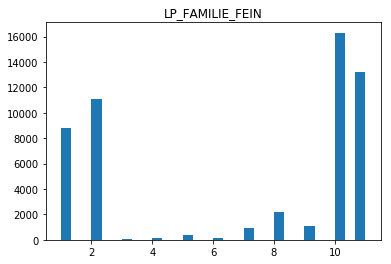

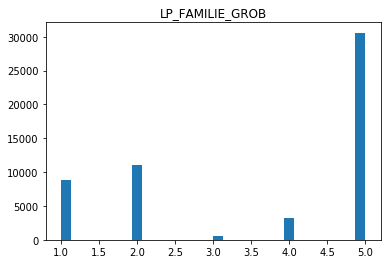

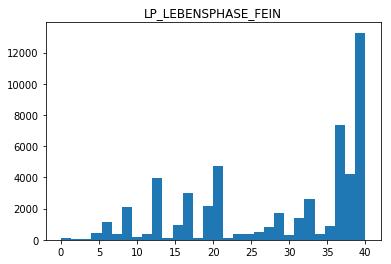

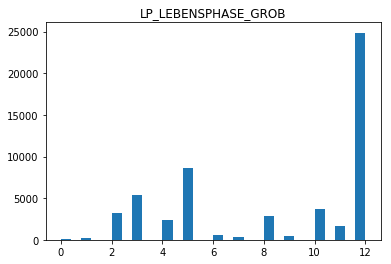

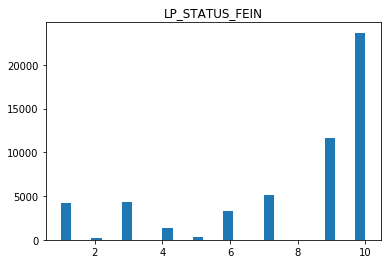

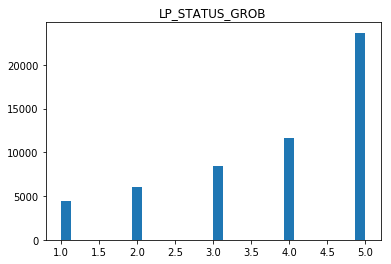

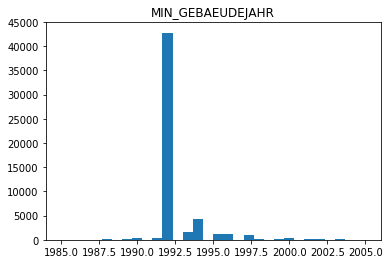

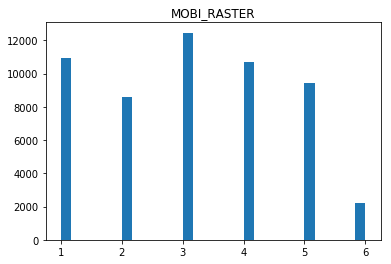

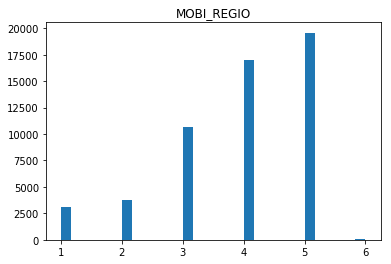

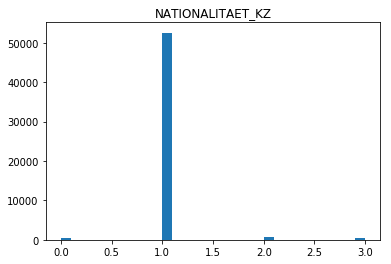

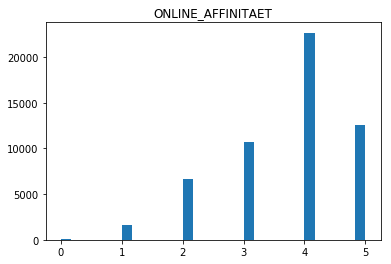

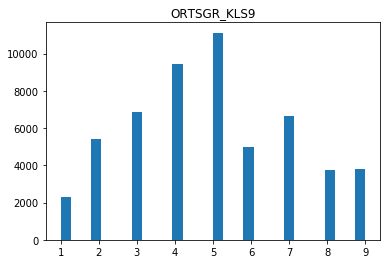

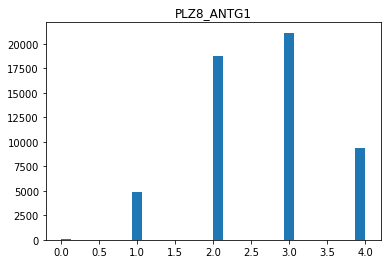

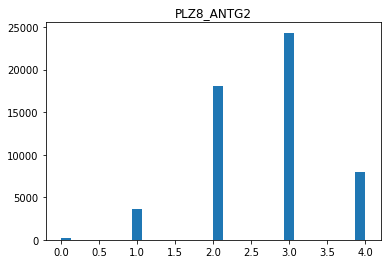

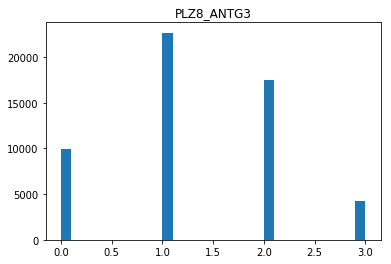

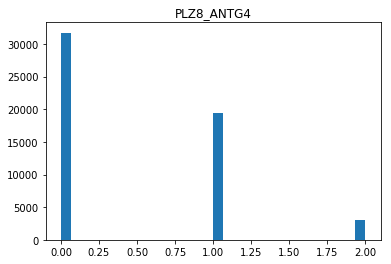

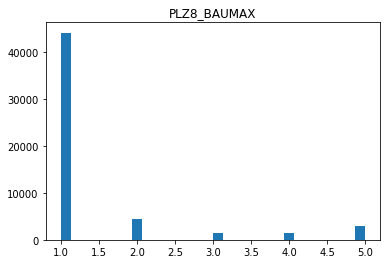

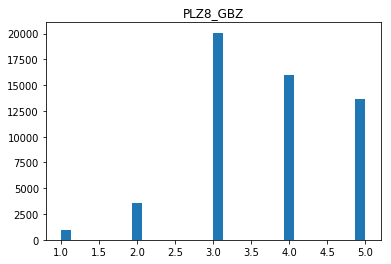

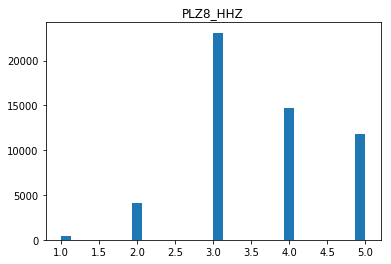

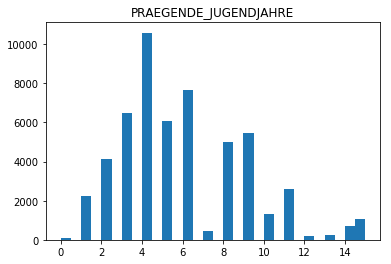

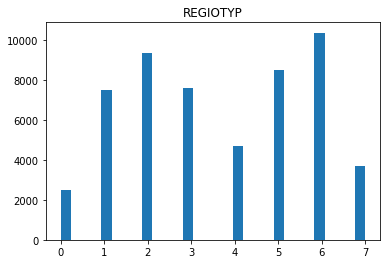

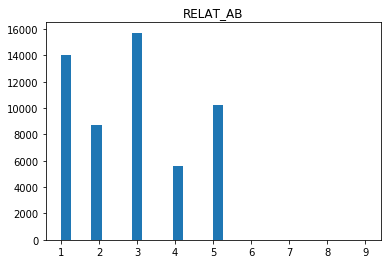

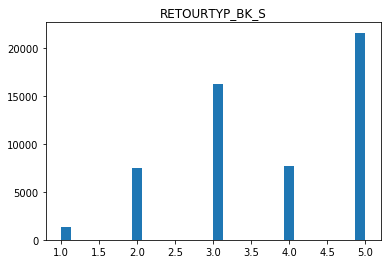

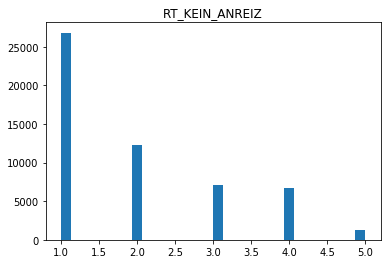

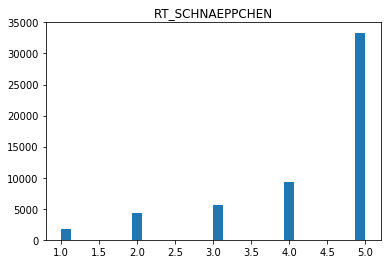

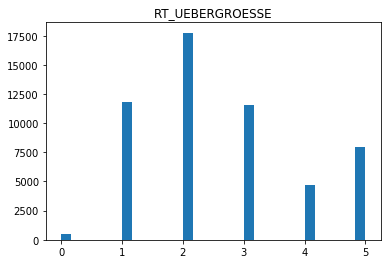

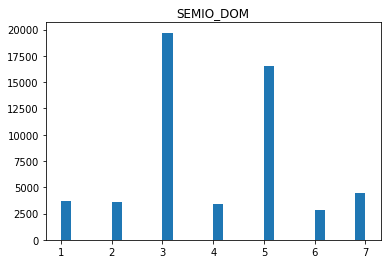

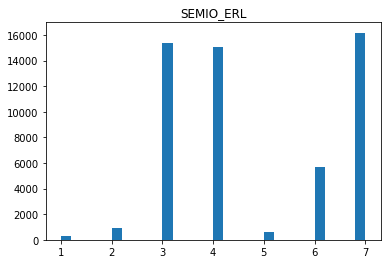

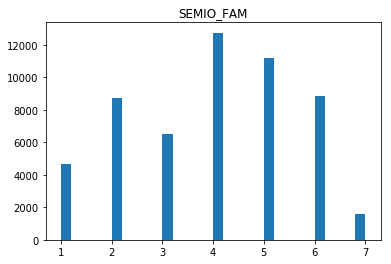

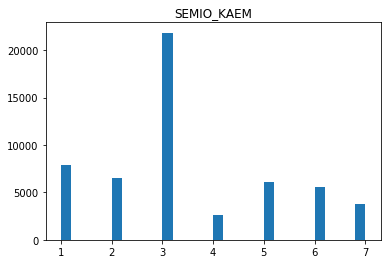

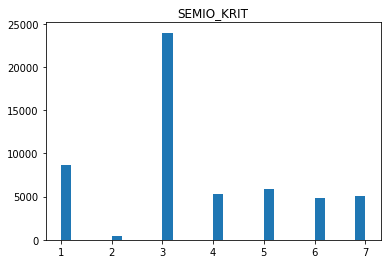

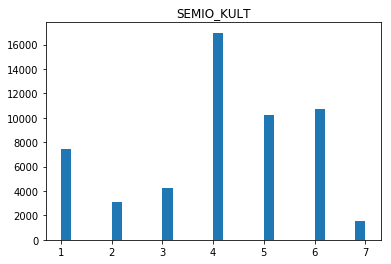

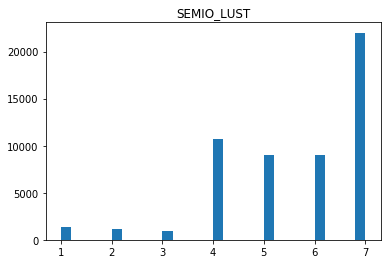

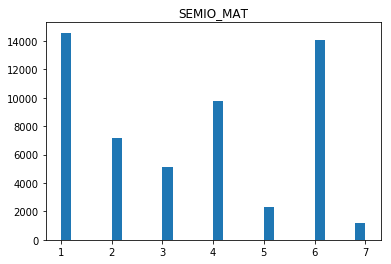

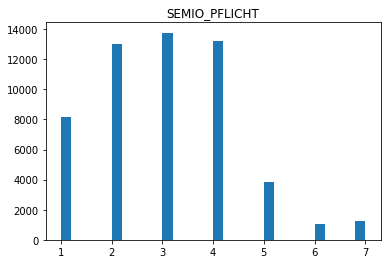

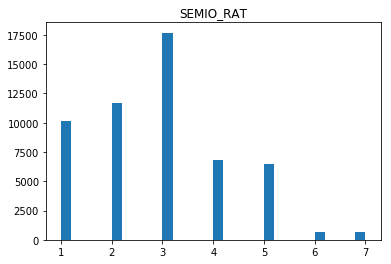

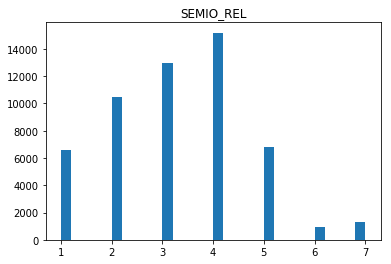

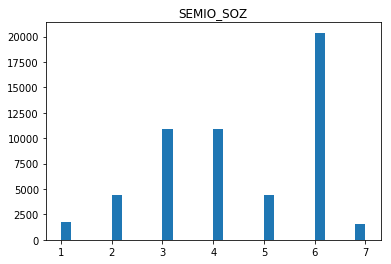

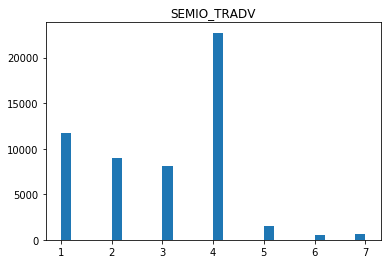

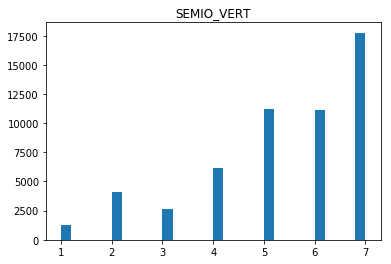

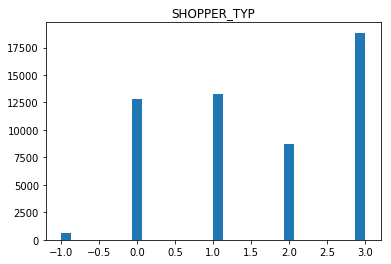

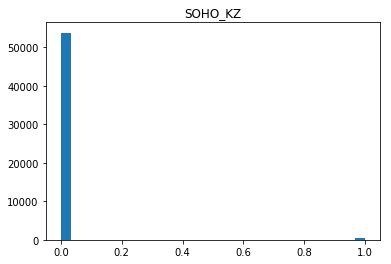

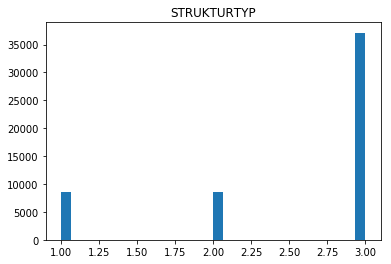

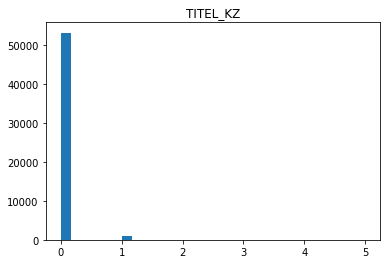

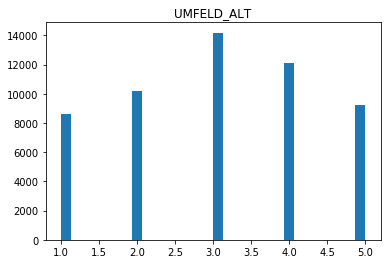

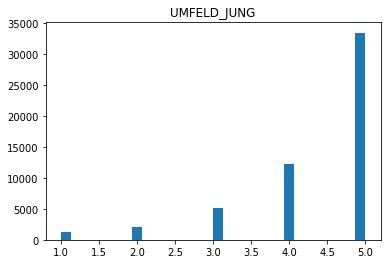

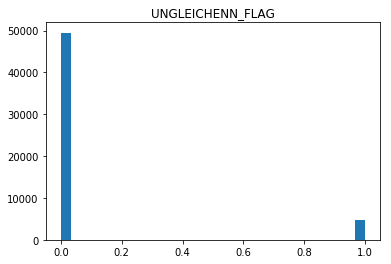

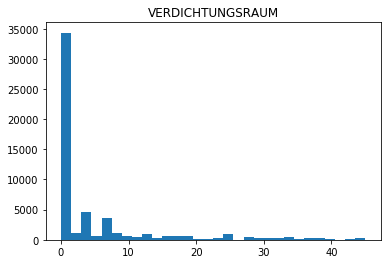

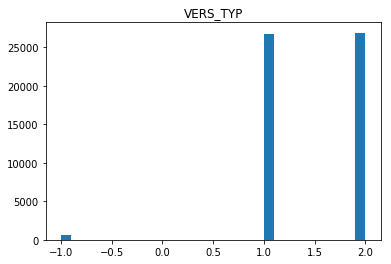

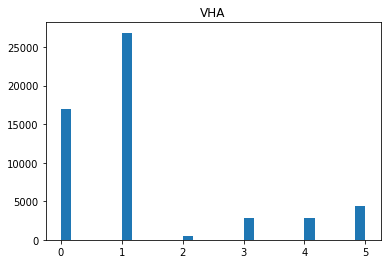

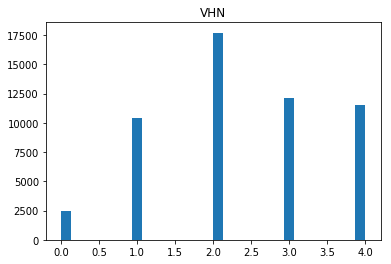

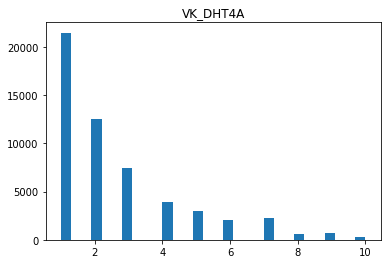

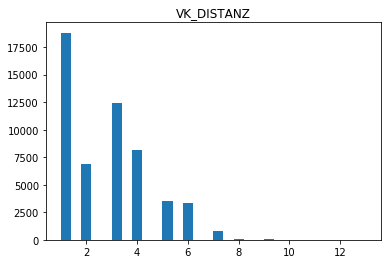

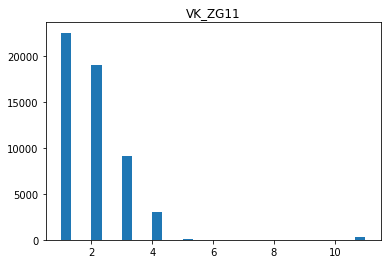

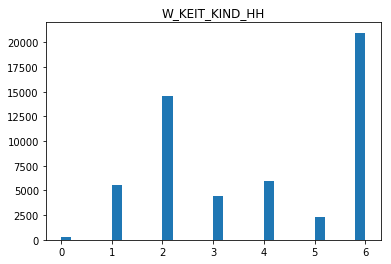

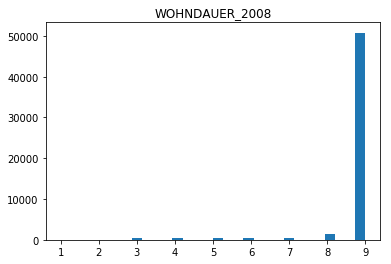

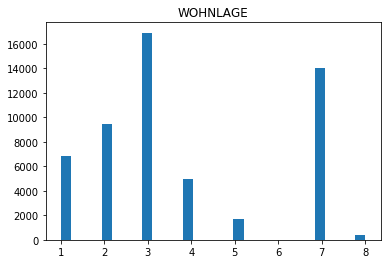

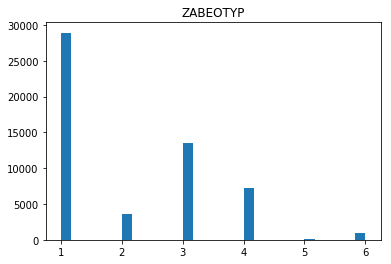

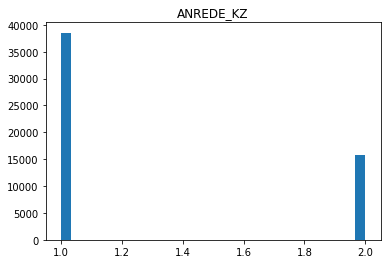

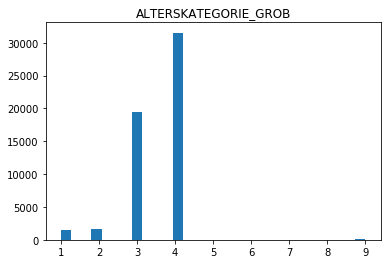

In [115]:
clean_azdias.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
0        -1         1.0      18.0         12.0         14.0         15.0   
1        -1         1.0      18.0         11.0         11.0         13.0   
2        -1         1.0      20.0         15.0         15.0         17.0   
3        -1         1.0      17.0          8.0          8.0         13.0   
4        -1         9.0      18.0          6.0          8.0         13.0   

   ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0         16.0                  16.0                  3.0           0.0   
1         13.0                  16.0                  1.0           0.0   
2         17.0                  14.0                  1.0           0.0   
3         16.0                  17.0                  2.0           0.0   
4         15.0                  16.0                  1.0           0.0   

           ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0          ...           1.0       2.0         1.0      2.0             1.0   
1          ...           4.0       1.0         1.0      1.0             1.0   
2          ...           4.0       3.0         3.0      2.0             1.0   
3          ...           1.0       2.0         3.0      4.0             1.0   
4          ...           2.0       2.0         3.0      4.0             1.0   

   WOHNDAUER_2008 WOHNLAGE ZABEOTYP ANREDE_KZ  ALTERSKATEGORIE_GROB  
0             9.0      5.0        4         1                     2  
1             9.0      8.0        2         1                     2  
2             9.0      3.0        1         1                     3  
3             9.0      7.0        4         2                     1  
4             9.0      3.0        2         2                     3  

[5 rows x 365 columns]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')